# WINTER

In [ ]:
import pandas as pd

In [ ]:
data_winter = pd.read_csv('DATASET/SEASON/data_Winter.csv')

In [ ]:
data_winter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6419 entries, 0 to 6418
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  6419 non-null   int64  
 1   city_name   6419 non-null   object 
 2   date        6419 non-null   object 
 3   season      6419 non-null   object 
 4   avg_temp_c  6181 non-null   float64
 5   min_temp_c  6142 non-null   float64
 6   max_temp_c  6419 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 351.2+ KB


In [ ]:
data_winter

station_id city_name        date  season  avg_temp_c  min_temp_c  \
0          47662     Tokyo  1951-01-01  Winter         NaN        -3.6   
1          47662     Tokyo  1951-01-02  Winter         NaN        -1.4   
2          47662     Tokyo  1951-01-03  Winter         NaN        -2.2   
3          47662     Tokyo  1951-01-04  Winter         NaN        -1.4   
4          47662     Tokyo  1951-01-05  Winter         NaN        -3.3   
...          ...       ...         ...     ...         ...         ...   
6414       47662     Tokyo  2023-02-24  Winter         8.9         6.2   
6415       47662     Tokyo  2023-02-25  Winter         7.7         4.3   
6416       47662     Tokyo  2023-02-26  Winter         5.9         2.1   
6417       47662     Tokyo  2023-02-27  Winter         8.5         3.7   
6418       47662     Tokyo  2023-02-28  Winter        11.5         3.8   

      max_temp_c  
0            7.0  
1            8.2  
2            8.1  
3            9.2  
4            9.7  
...          ...  
6414        11.9  
6415        11.7  
6416        10.1  
6417        13.9  
6418        18.5  

[6419 rows x 7 columns]

## PREDIKSI 1 HARI

### RNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_winter  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1044710312.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1044710312.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6412, 7, 1)
Shape of y: (6412,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# RNN configurations based on the table provided
rnn_configs = [
    {'hidden_units': [11], 'epochs': 50},
    {'hidden_units': [4, 5], 'epochs': 263},
    {'hidden_units': [5, 7, 3], 'epochs': 92}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(rnn_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'RNN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/50

257/257 [==============================] - 2s 3ms/step - loss: 0.0153 - val_loss: 0.0131
Epoch 2/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0131
Epoch 3/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0128
Epoch 4/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0127
Epoch 5/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 6/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0127
Epoch 7/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0128
Epoch 8/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0127
Epoch 9/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0126
Epoch 10/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.013

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2
0  RNN 1         [11]      50  2.912240  2.298620  0.253798
1  RNN 2       [4, 5]     263  2.922438  2.307895  0.248563
2  RNN 3    [5, 7, 3]      92  2.982284  2.380174  0.217472

In [ ]:
results_df.to_csv(f'HASIL/RNN_WINTER.csv', index=False)

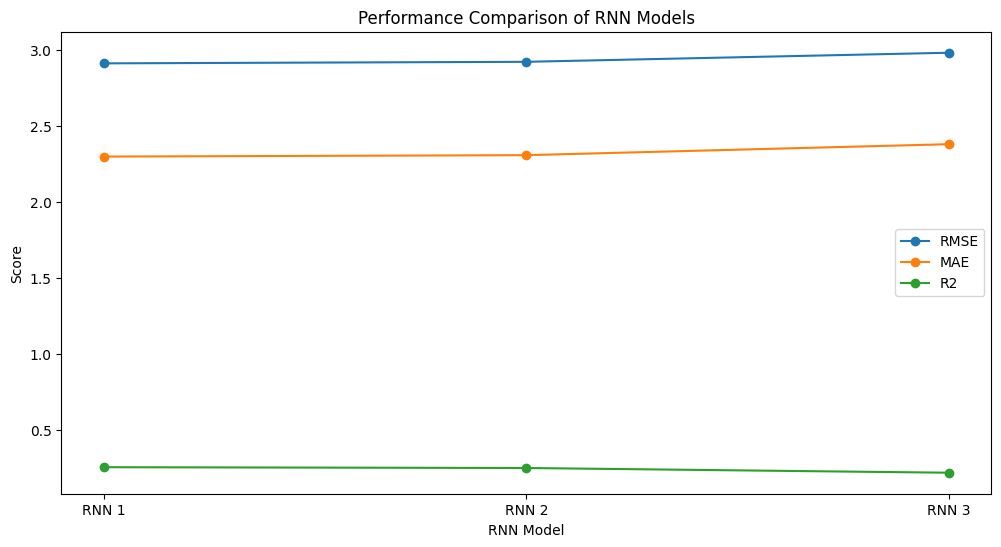

In [ ]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("RNN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of RNN Models")
plt.legend()
plt.show()

### LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
# Load data
data = data_winter  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1044710312.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1044710312.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6412, 7, 1)
Shape of y: (6412,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# LSTM configurations based on the table provided
lstm_configs = [
    {'hidden_units': [10], 'epochs': 20},
    {'hidden_units': [12, 4], 'epochs': 91},
    {'hidden_units': [11, 11, 1], 'epochs': 98}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(lstm_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'LSTM {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/20
257/257 [==============================] - 2s 4ms/step - loss: 0.0752 - val_loss: 0.0135
Epoch 2/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0144 - val_loss: 0.0135
Epoch 3/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0143 - val_loss: 0.0134
Epoch 4/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0142 - val_loss: 0.0134
Epoch 5/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0141 - val_loss: 0.0133
Epoch 6/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0140 - val_loss: 0.0134
Epoch 7/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 8/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0138 - val_loss: 0.0129
Epoch 9/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0136 - val_loss: 0.0128
Epoch 10/20
257/257 [==============================] - 1s 5ms/step - loss: 0.0135 - val_loss: 0.0127

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2
0  LSTM 1         [10]      20  2.887353  2.268372  0.266497
1  LSTM 2      [12, 4]      91  2.935565  2.317615  0.241797
2  LSTM 3  [11, 11, 1]      98  3.376096  2.693159 -0.002840

In [ ]:
results_df.to_csv(f'HASIL/LSTM_WINTER.csv', index=False)

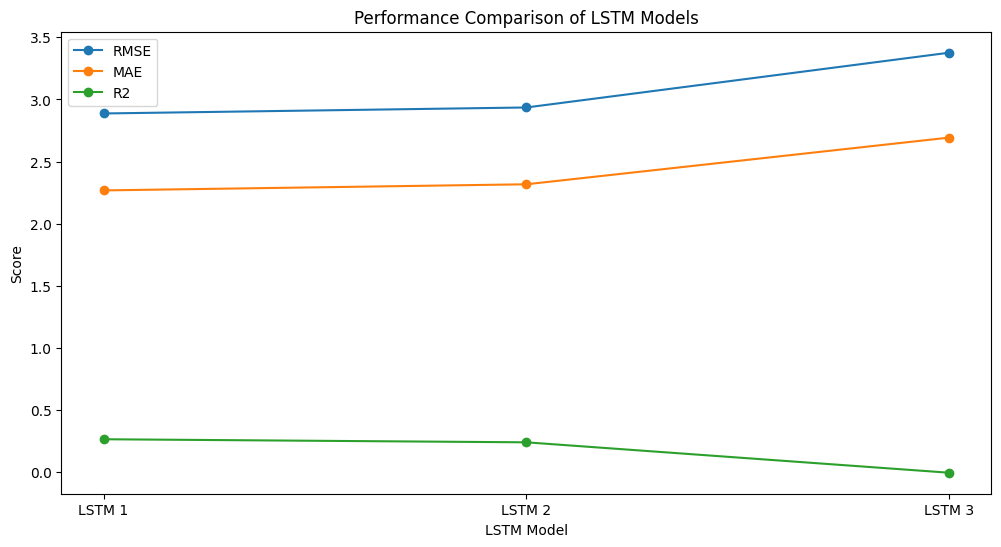

In [ ]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("LSTM Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_winter  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1044710312.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1044710312.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6412, 7, 1)
Shape of y: (6412,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))

    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))

    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')

    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# ANN configurations based on the table provided
ann_configs = [
    {'hidden_units': [8], 'epochs': 161},
    {'hidden_units': [4, 16], 'epochs': 193},
    {'hidden_units': [3, 10, 12], 'epochs': 285}
]

In [ ]:
# Train and evaluate each configuration
results = []
for i, config in enumerate(ann_configs):
    rmse, mae, r2 = train_evaluate_ann_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'ANN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/161
257/257 [==============================] - 1s 3ms/step - loss: 0.0172 - val_loss: 0.0141
Epoch 2/161
257/257 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0134
Epoch 3/161
257/257 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.0131
Epoch 4/161
257/257 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.0129
Epoch 5/161
257/257 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0129
Epoch 6/161
257/257 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0128
Epoch 7/161
257/257 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0129
Epoch 8/161
257/257 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0128
Epoch 9/161
257/257 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0128
Epoch 10/161
257/257 [==============================] - 0s 2ms/step - loss: 0.0132 - val_lo

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2
0  ANN 1          [8]     161  2.897909  2.252071  0.261124
1  ANN 2      [4, 16]     193  2.910707  2.299889  0.254584
2  ANN 3  [3, 10, 12]     285  2.906482  2.280585  0.256746

In [ ]:
results_df.to_csv(f'HASIL/ANN_WINTER.csv', index=False)

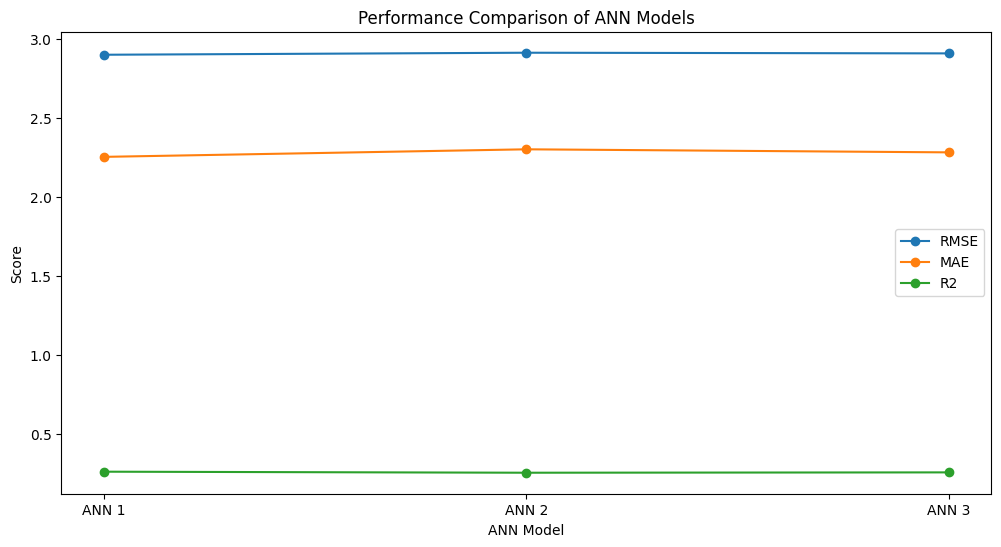

In [ ]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("ANN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of ANN Models")
plt.legend()
plt.show()

## PREDIKSI 15 HARI

### RNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Load data
data = data_winter  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_54296\1740994759.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_54296\1740994759.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
def create_sequences(data, target, sequence_length=26, predict_days=15):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))

        # Simulate prediction for the next 15 days (lag of 26)
        labels.append(np.nan)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]
        avg_last_two_values = np.mean(last_two_values)

        labels[-1] = avg_last_two_values

    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=26)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6393, 26, 1)
Shape of y: (6393,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2, model

In [ ]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Start with the last available sequence

    for _ in range(days):
        # Predict the next day (model expects input in 3D: batch_size, sequence_length, features)
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))

        predictions.append(pred[0, 0])

        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)

        # Ensure the new sequence shape is correct for the next prediction
        current_input = current_input.reshape(-1, 1)

    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [ ]:
# Define list containing different configurations for evaluation purposes
rnn_configs = [
    {'hidden_units': [11], 'epochs': 50},
    {'hidden_units': [4, 5], 'epochs': 263},
    {'hidden_units': [5, 7, 3], 'epochs': 92}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(rnn_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])

    # Append evaluation results to the list
    results.append({
        'Model': f'RNN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)



Epoch 1/50

256/256 [==============================] - 2s 5ms/step - loss: 0.2390 - val_loss: 0.0042
Epoch 2/50
256/256 [==============================] - 1s 4ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 3/50
256/256 [==============================] - 1s 4ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/50
256/256 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/50
256/256 [==============================] - 1s 4ms/step - loss: 8.3102e-04 - val_loss: 6.6900e-04
Epoch 6/50
256/256 [==============================] - 1s 3ms/step - loss: 5.2220e-04 - val_loss: 4.1704e-04
Epoch 7/50
256/256 [==============================] - 1s 4ms/step - loss: 3.2582e-04 - val_loss: 2.4850e-04
Epoch 8/50
256/256 [==============================] - 1s 4ms/step - loss: 1.8125e-04 - val_loss: 1.1481e-04
Epoch 9/50
256/256 [==============================] - 1s 5ms/step - loss: 8.7590e-05 - val_loss: 4.8546e-05
Epoch 10/50
256/256 [==============================] - 1s 

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2  \
0  RNN 1         [11]      50  0.011773  0.011258  0.999983   
1  RNN 2       [4, 5]     263  2.846321  2.235603 -0.000930   
2  RNN 3    [5, 7, 3]      92  0.009468  0.004075  0.999989   

                                        Model_Object  
0  <keras.src.engine.sequential.Sequential object...  
1  <keras.src.engine.sequential.Sequential object...  
2  <keras.src.engine.sequential.Sequential object...

In [ ]:
results_df.to_csv(f'HASIL/15_RNN_WINTER.csv', index=False)

In [ ]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model               RNN 3
Hidden Units    [5, 7, 3]
Epochs                 92
RMSE             0.009468
MAE              0.004075
R2               0.999989
Name: 2, dtype: object
1/1 [==============================] - 0s 26ms/step

Predictions for the next 15 days using the best model:
[7.85261   8.124228  7.9912295 8.055804  8.017657  8.039765  8.0253525
 8.034919  8.027334  8.031043  8.028585  8.028962  8.028183  8.02774
 8.027413 ]


In [ ]:
predictions_rescaled

array([[7.85261  ],
       [8.124228 ],
       [7.9912295],
       [8.055804 ],
       [8.017657 ],
       [8.039765 ],
       [8.0253525],
       [8.034919 ],
       [8.027334 ],
       [8.031043 ],
       [8.028585 ],
       [8.028962 ],
       [8.028183 ],
       [8.02774  ],
       [8.027413 ]], dtype=float32)

In [ ]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [ ]:
df_predictions

Predicted_Value
0          7.852610
1          8.124228
2          7.991230
3          8.055804
4          8.017657
5          8.039765
6          8.025352
7          8.034919
8          8.027334
9          8.031043
10         8.028585
11         8.028962
12         8.028183
13         8.027740
14         8.027413

In [ ]:
df_predictions.to_csv(f'HASIL_PREDICT/15_RNN_WINTER.csv', index=False)

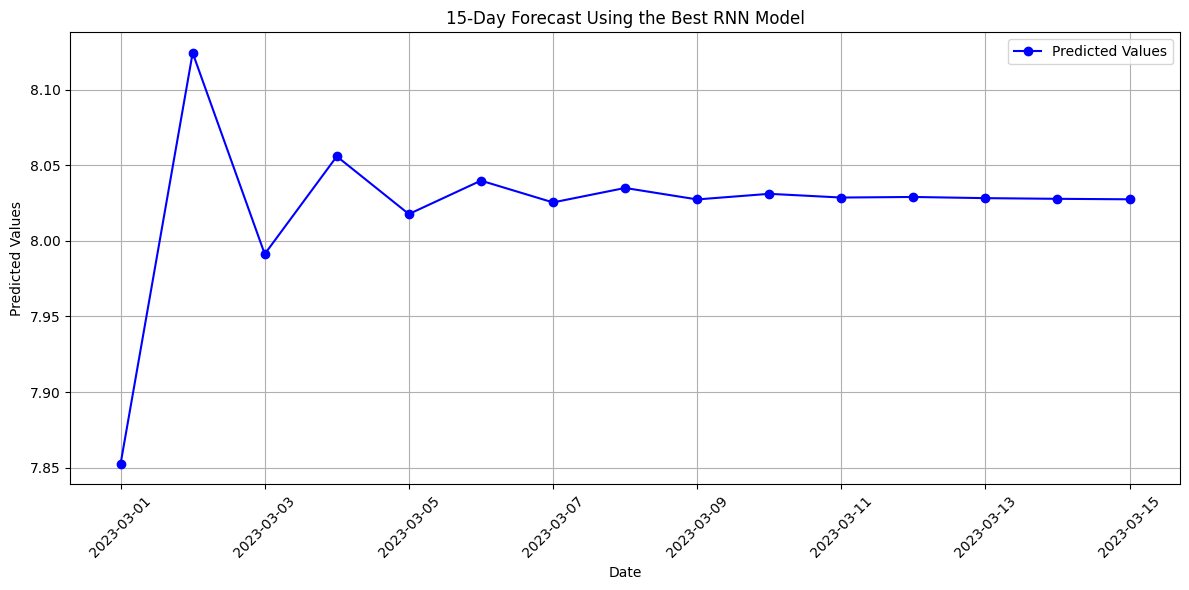

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_winter['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best RNN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

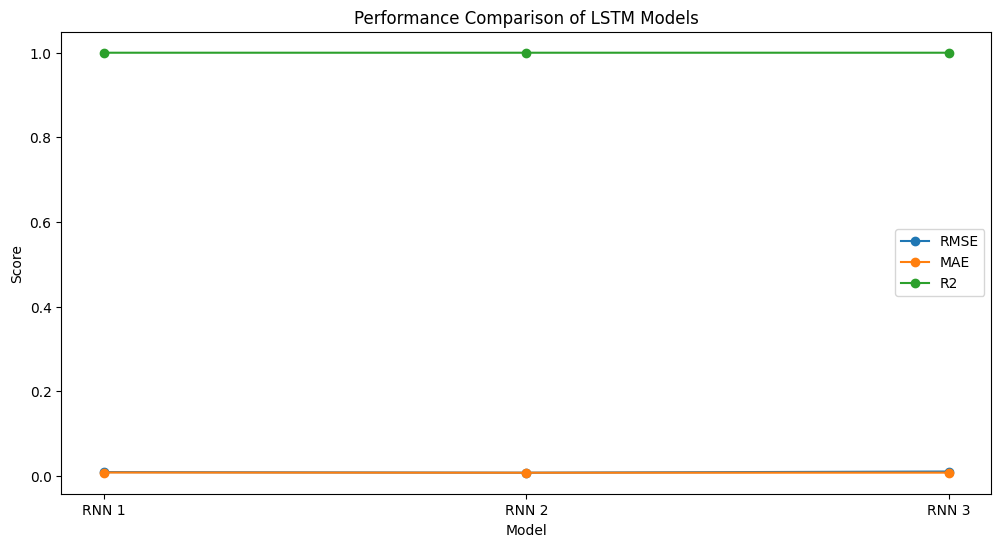

In [ ]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Load data
data = data_winter  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1740994759.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1740994759.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
def create_sequences(data, target, sequence_length=25, predict_days=15):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)

        # Simulate prediction for the next 15 days (lag of 25)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)

        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values

    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=25)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6394, 25, 1)
Shape of y: (6394,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    # Return RMSE, MAE, R2, and model
    return rmse, mae, r2, model


In [ ]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Start with the last available sequence

    for _ in range(days):
        # Predict the next day (model expects input in 3D: batch_size, sequence_length, features)
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))

        predictions.append(pred[0, 0])  # Append the scalar prediction value

        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)

        # Ensure the new sequence shape is correct for the next prediction
        current_input = current_input.reshape(-1, 1)

    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [ ]:
# Define list containing different configurations for evaluation purposes
lstm_configs = [
    {'hidden_units': [10], 'epochs': 20},
    {'hidden_units': [12, 4], 'epochs': 91},
    {'hidden_units': [11, 11, 1], 'epochs': 98}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(lstm_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_lstm_model(config['hidden_units'], config['epochs'])

    # Append evaluation results to the list
    results.append({
        'Model': f'LSTM {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)


Epoch 1/20
256/256 [==============================] - 5s 11ms/step - loss: 0.0422 - val_loss: 0.0073
Epoch 2/20
256/256 [==============================] - 2s 8ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 3/20
256/256 [==============================] - 2s 9ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 4/20
256/256 [==============================] - 3s 13ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 5/20
256/256 [==============================] - 3s 10ms/step - loss: 9.3630e-04 - val_loss: 6.2176e-04
Epoch 6/20
256/256 [==============================] - 2s 8ms/step - loss: 5.9744e-04 - val_loss: 4.9366e-04
Epoch 7/20
256/256 [==============================] - 2s 7ms/step - loss: 4.6234e-04 - val_loss: 3.9792e-04
Epoch 8/20
256/256 [==============================] - 2s 7ms/step - loss: 3.8718e-04 - val_loss: 3.3499e-04
Epoch 9/20
256/256 [==============================] - 2s 7ms/step - loss: 3.3015e-04 - val_loss: 2.8765e-04
Epoch 10/20
256/256 [==============================] - 2s

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2  \
0  LSTM 1         [10]      20  0.043554  0.033979  0.999759   
1  LSTM 2      [12, 4]      91  0.041490  0.031877  0.999781   
2  LSTM 3  [11, 11, 1]      98  2.806857  2.220786 -0.000347   

                                        Model_Object  
0  <keras.src.engine.sequential.Sequential object...  
1  <keras.src.engine.sequential.Sequential object...  
2  <keras.src.engine.sequential.Sequential object...

In [ ]:
results_df.to_csv(f'HASIL/15_LSTM_WINTER.csv', index=False)

In [ ]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model             LSTM 2
Hidden Units     [12, 4]
Epochs                91
RMSE             0.04149
MAE             0.031877
R2              0.999781
Name: 1, dtype: object
1/1 [==============================] - 0s 28ms/step

Predictions for the next 15 days using the best model:
[14.929795  14.858264  14.909451  14.896449  14.924283  14.931254
 14.944196  14.954317  14.964445  14.973204  14.981665  14.987951
 14.993435  14.9977045 15.002039 ]


In [ ]:
predictions_rescaled

array([[14.929795 ],
       [14.858264 ],
       [14.909451 ],
       [14.896449 ],
       [14.924283 ],
       [14.931254 ],
       [14.944196 ],
       [14.954317 ],
       [14.964445 ],
       [14.973204 ],
       [14.981665 ],
       [14.987951 ],
       [14.993435 ],
       [14.9977045],
       [15.002039 ]], dtype=float32)

In [ ]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [ ]:
df_predictions

Predicted_Value
0         14.929795
1         14.858264
2         14.909451
3         14.896449
4         14.924283
5         14.931254
6         14.944196
7         14.954317
8         14.964445
9         14.973204
10        14.981665
11        14.987951
12        14.993435
13        14.997705
14        15.002039

In [ ]:
df_predictions.to_csv(f'HASIL_PREDICT/15_LSTM_WINTER.csv', index=False)

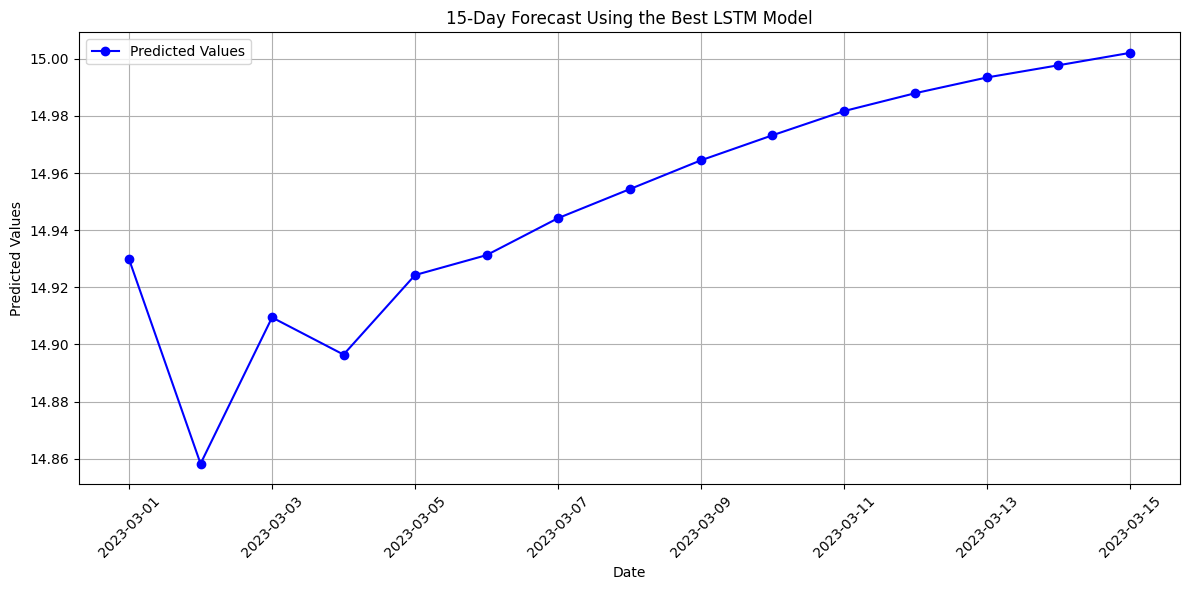

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_winter['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best LSTM Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

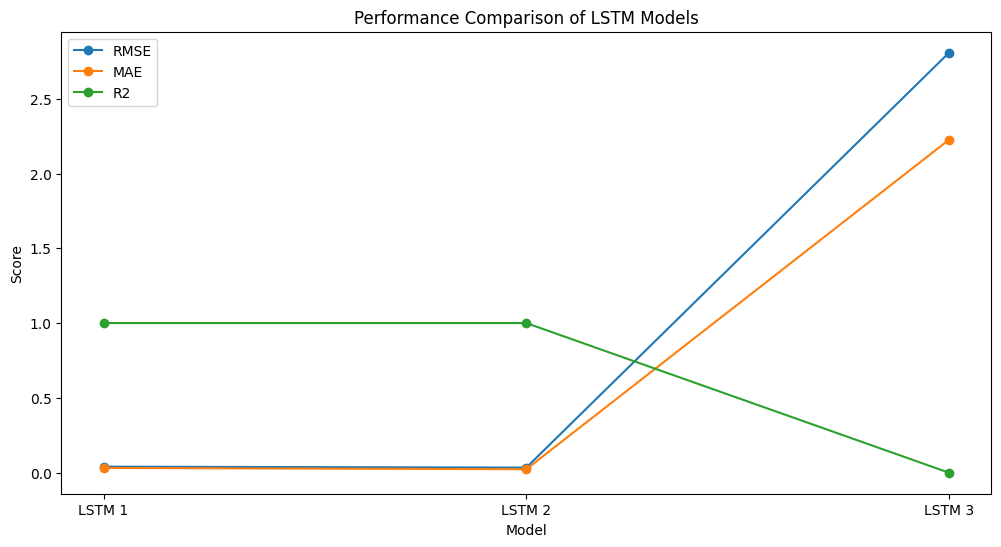

In [ ]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Load data
data = data_winter  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1740994759.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1740994759.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
def create_sequences(data, target, sequence_length=19, predict_days=15):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)

        # Simulate prediction for the next 15 days (lag of 19)
        labels.append(np.nan)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]
        avg_last_two_values = np.mean(last_two_values)

        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values

    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=19)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6400, 19, 1)
Shape of y: (6400,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))

    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))

    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')

    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2, model

In [ ]:
last_sequence = X_test[-1].reshape(1, -1)

In [ ]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence.flatten()

    for _ in range(days):
        # Predict the next day using the flattened input
        pred = model.predict(current_input.reshape(1, -1))

        predictions.append(pred[0, 0])

        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)

    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled


In [ ]:
# Define list containing different configurations for evaluation purposes
ann_configs = [
    {'hidden_units': [8], 'epochs': 161},
    {'hidden_units': [4, 16], 'epochs': 193},
    {'hidden_units': [3, 10, 12], 'epochs': 285}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(ann_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_ann_model(config['hidden_units'], config['epochs'])

    # Append evaluation results to the list
    results.append({
        'Model': f'ANN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)


Epoch 1/161
256/256 [==============================] - 2s 3ms/step - loss: 0.1013 - val_loss: 0.0278
Epoch 2/161
256/256 [==============================] - 1s 2ms/step - loss: 0.0229 - val_loss: 0.0186
Epoch 3/161
256/256 [==============================] - 1s 3ms/step - loss: 0.0149 - val_loss: 0.0121
Epoch 4/161
256/256 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0079
Epoch 5/161
256/256 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 6/161
256/256 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 7/161
256/256 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 8/161
256/256 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/161
256/256 [==============================] - 0s 2ms/step - loss: 8.0179e-04 - val_loss: 7.7637e-04
Epoch 10/161
256/256 [==============================] - 1s 3ms/step - loss: 4.4598e

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2  \
0  ANN 1          [8]     161  0.030263  0.003335  0.999882   
1  ANN 2      [4, 16]     193  0.039436  0.030050  0.999799   
2  ANN 3  [3, 10, 12]     285  0.000626  0.000557  1.000000   

                                        Model_Object  
0  <keras.src.engine.sequential.Sequential object...  
1  <keras.src.engine.sequential.Sequential object...  
2  <keras.src.engine.sequential.Sequential object...

In [ ]:
results_df.to_csv(f'HASIL/15_ANN_WINTER.csv', index=False)

In [ ]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model                 ANN 3
Hidden Units    [3, 10, 12]
Epochs                  285
RMSE               0.000626
MAE                0.000557
R2                      1.0
Name: 2, dtype: object
1/1 [==============================] - 0s 38ms/step

Predictions for the next 15 days using the best model:
[14.050894  14.626416  14.339779  14.483815  14.412538  14.449043
 14.431726  14.441111  14.437006  14.439961  14.439222  14.4405155
 14.440839  14.44144   14.4422455]


In [ ]:
predictions_rescaled

array([[14.050894 ],
       [14.626416 ],
       [14.339779 ],
       [14.483815 ],
       [14.412538 ],
       [14.449043 ],
       [14.431726 ],
       [14.441111 ],
       [14.437006 ],
       [14.439961 ],
       [14.439222 ],
       [14.4405155],
       [14.440839 ],
       [14.44144  ],
       [14.4422455]], dtype=float32)

In [ ]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [ ]:
df_predictions

Predicted_Value
0         14.050894
1         14.626416
2         14.339779
3         14.483815
4         14.412538
5         14.449043
6         14.431726
7         14.441111
8         14.437006
9         14.439961
10        14.439222
11        14.440516
12        14.440839
13        14.441440
14        14.442245

In [ ]:
df_predictions.to_csv(f'HASIL_PREDICT/15_ANN_WINTER.csv', index=False)

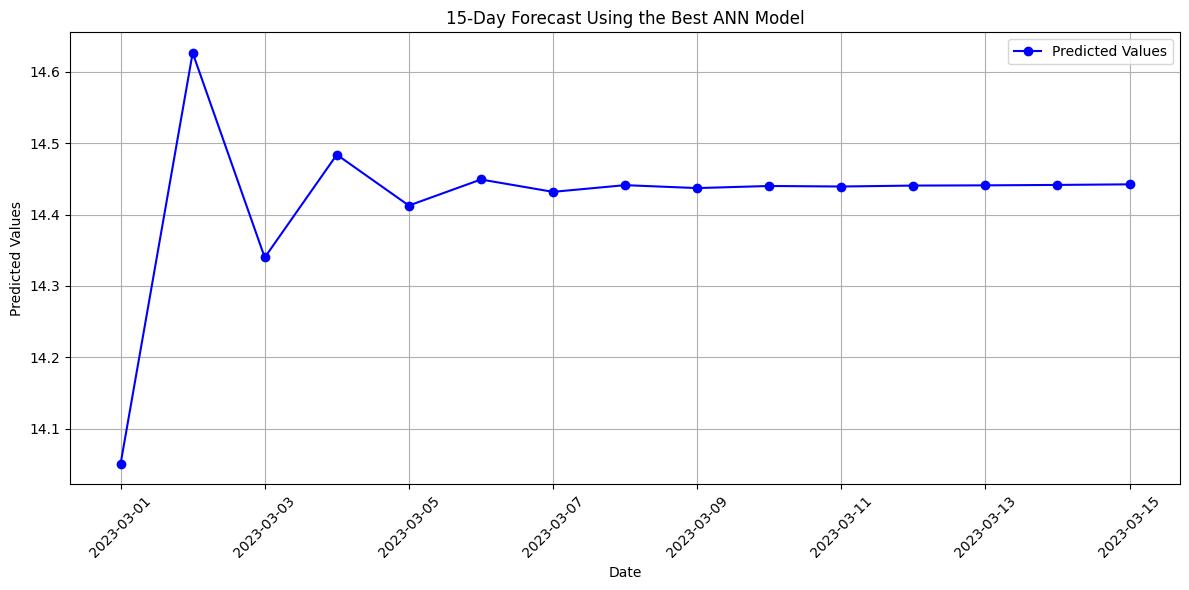

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_winter['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best ANN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

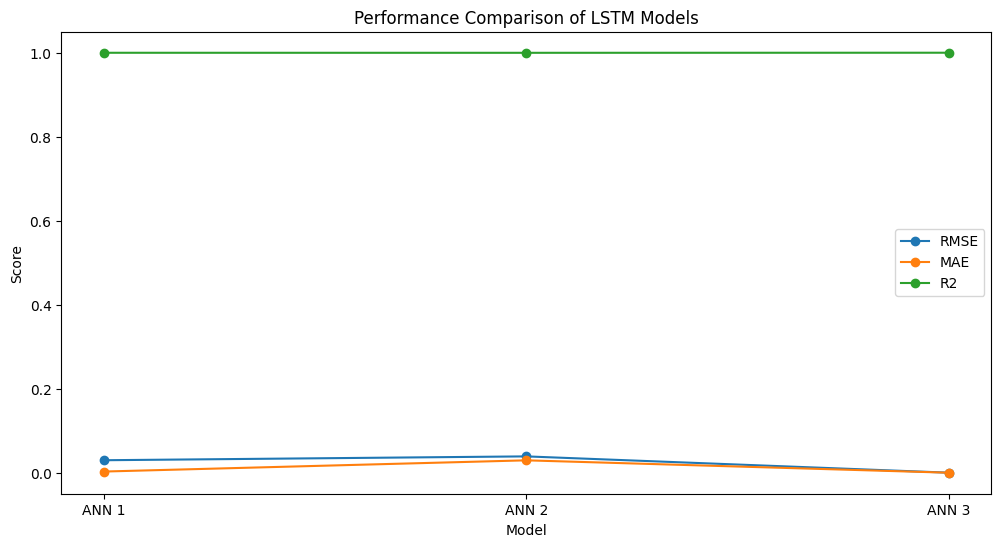

In [ ]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

# SPRING

In [ ]:
import pandas as pd
data_spring = pd.read_csv('DATASET/SEASON/data_Spring.csv')
data_spring.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6568 entries, 0 to 6567
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  6568 non-null   int64  
 1   city_name   6568 non-null   object 
 2   date        6568 non-null   object 
 3   season      6568 non-null   object 
 4   avg_temp_c  6361 non-null   float64
 5   min_temp_c  6330 non-null   float64
 6   max_temp_c  6568 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 359.3+ KB


In [ ]:
data_spring

station_id city_name        date  season  avg_temp_c  min_temp_c  \
0          47662     Tokyo  1951-03-01  Spring         NaN         6.5   
1          47662     Tokyo  1951-03-02  Spring         NaN         5.6   
2          47662     Tokyo  1951-03-03  Spring         NaN         2.5   
3          47662     Tokyo  1951-03-04  Spring         NaN        -0.4   
4          47662     Tokyo  1951-03-05  Spring         NaN        -1.1   
...          ...       ...         ...     ...         ...         ...   
6563       47662     Tokyo  2023-05-27  Spring        21.1        16.9   
6564       47662     Tokyo  2023-05-28  Spring        21.5        18.6   
6565       47662     Tokyo  2023-05-29  Spring        20.0        19.0   
6566       47662     Tokyo  2023-05-30  Spring        21.2        18.8   
6567       47662     Tokyo  2023-05-31  Spring        19.1        17.0   

      max_temp_c  
0           15.0  
1           11.3  
2            8.2  
3            9.0  
4            9.2  
...          ...  
6563        26.0  
6564        24.4  
6565        21.5  
6566        24.9  
6567        21.7  

[6568 rows x 7 columns]

## PREDIKSI 1 HARI

### RNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_spring  # Assuming data_spring is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\466734098.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\466734098.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6561, 7, 1)
Shape of y: (6561,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# RNN configurations based on the table provided
rnn_configs = [
    {'hidden_units': [5], 'epochs': 104},
    {'hidden_units': [1, 10], 'epochs': 156},
    {'hidden_units': [4, 4, 7], 'epochs': 204}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(rnn_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'RNN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/104
263/263 [==============================] - 2s 4ms/step - loss: 0.2328 - val_loss: 0.1245
Epoch 2/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0850 - val_loss: 0.0539
Epoch 3/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0436 - val_loss: 0.0355
Epoch 4/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0342 - val_loss: 0.0326
Epoch 5/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0329 - val_loss: 0.0324
Epoch 6/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0327 - val_loss: 0.0324
Epoch 7/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0328 - val_loss: 0.0324
Epoch 8/104
263/263 [==============================] - 1s 4ms/step - loss: 0.0327 - val_loss: 0.0324
Epoch 9/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0328 - val_loss: 0.0324
Epoch 10/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0328 - val_lo

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2
0  RNN 1          [5]     104  5.460967  4.545963 -0.001070
1  RNN 2      [1, 10]     156  3.638693  2.850179  0.555557
2  RNN 3    [4, 4, 7]     204  3.582440  2.747652  0.569192

In [ ]:
results_df.to_csv(f'HASIL/RNN_SPRING.csv', index=False)

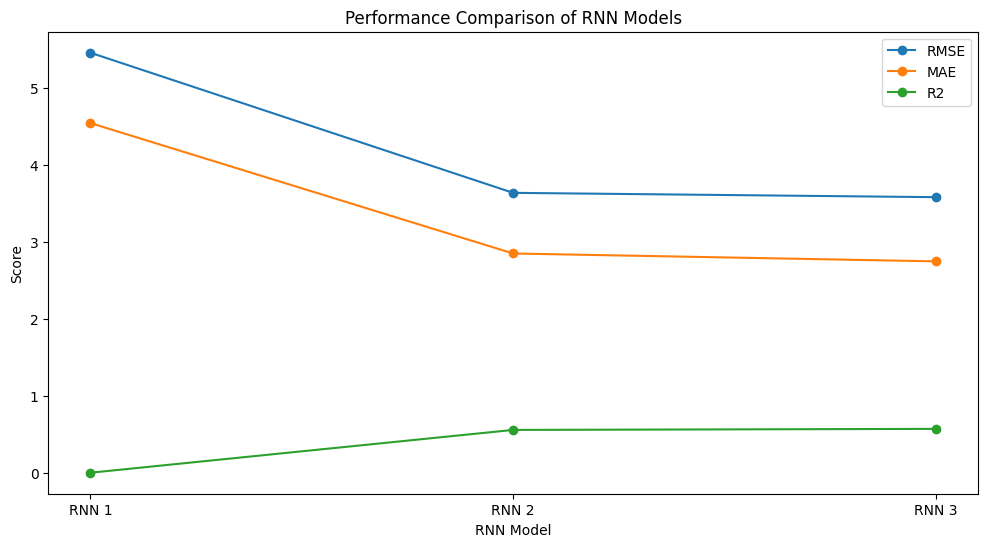

In [ ]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("RNN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of RNN Models")
plt.legend()
plt.show()

### LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
# Load data
data = data_spring  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1706446326.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1706446326.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6561, 7, 1)
Shape of y: (6561,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# LSTM configurations based on the table provided
lstm_configs = [
    {'hidden_units': [3], 'epochs': 273},
    {'hidden_units': [3, 20], 'epochs': 285},
    {'hidden_units': [6, 11, 18], 'epochs': 280}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(lstm_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'LSTM {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/273
263/263 [==============================] - 3s 6ms/step - loss: 0.1086 - val_loss: 0.0168
Epoch 2/273
263/263 [==============================] - 1s 5ms/step - loss: 0.0160 - val_loss: 0.0153
Epoch 3/273
263/263 [==============================] - 1s 5ms/step - loss: 0.0155 - val_loss: 0.0149
Epoch 4/273
263/263 [==============================] - 1s 5ms/step - loss: 0.0154 - val_loss: 0.0148
Epoch 5/273
263/263 [==============================] - 1s 4ms/step - loss: 0.0153 - val_loss: 0.0146
Epoch 6/273
263/263 [==============================] - 1s 4ms/step - loss: 0.0153 - val_loss: 0.0147
Epoch 7/273
263/263 [==============================] - 1s 4ms/step - loss: 0.0152 - val_loss: 0.0144
Epoch 8/273
263/263 [==============================] - 1s 4ms/step - loss: 0.0152 - val_loss: 0.0145
Epoch 9/273
263/263 [==============================] - 1s 5ms/step - loss: 0.0152 - val_loss: 0.0145
Epoch 10/273
263/263 [==============================] - 1s 5ms/step - loss: 0.0151 - val_lo

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2
0  LSTM 1          [3]     273  3.600587  2.809225  0.564817
1  LSTM 2      [3, 20]     285  3.739734  2.883232  0.530531
2  LSTM 3  [6, 11, 18]     280  3.696644  2.837211  0.541287

In [ ]:
results_df.to_csv(f'HASIL/LSTM_SPRING.csv', index=False)

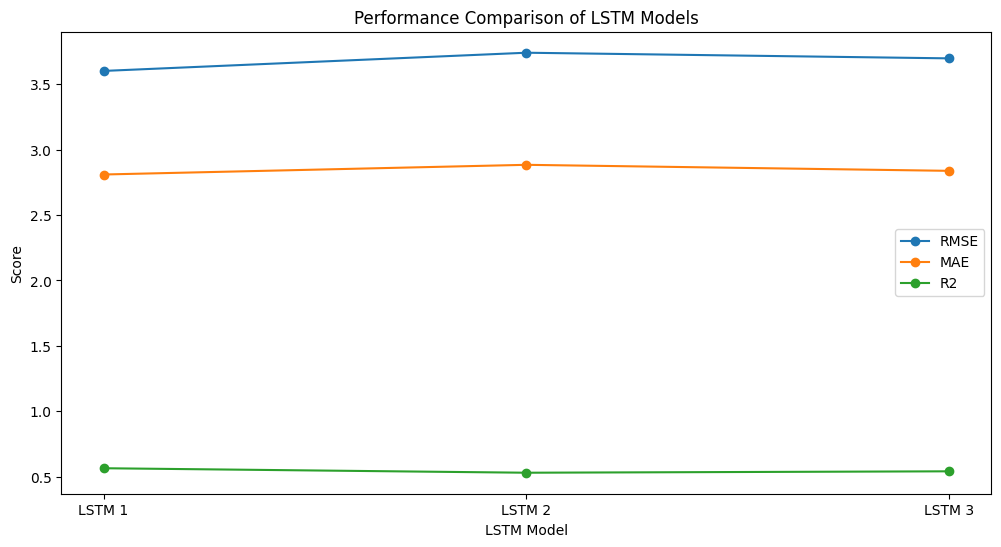

In [ ]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("LSTM Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_spring  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1706446326.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1706446326.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6561, 7, 1)
Shape of y: (6561,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))

    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))

    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')

    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# ANN configurations based on the table provided
ann_configs = [
    {'hidden_units': [2], 'epochs': 268},
    {'hidden_units': [4, 16], 'epochs': 263},
    {'hidden_units': [14, 8, 17], 'epochs': 100}
]

In [ ]:
# Train and evaluate each configuration
results = []
for i, config in enumerate(ann_configs):
    rmse, mae, r2 = train_evaluate_ann_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'ANN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/268
263/263 [==============================] - 1s 3ms/step - loss: 0.6170 - val_loss: 0.0936
Epoch 2/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0371 - val_loss: 0.0335
Epoch 3/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0293 - val_loss: 0.0282
Epoch 4/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0259 - val_loss: 0.0251
Epoch 5/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0236 - val_loss: 0.0230
Epoch 6/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0220 - val_loss: 0.0214
Epoch 7/268
263/263 [==============================] - 1s 4ms/step - loss: 0.0207 - val_loss: 0.0202
Epoch 8/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0198 - val_loss: 0.0191
Epoch 9/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0190 - val_loss: 0.0182
Epoch 10/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0182 - val_lo

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2
0  ANN 1          [2]     268  3.640867  2.830830  0.555025
1  ANN 2      [4, 16]     263  3.587098  2.808301  0.568071
2  ANN 3  [14, 8, 17]     100  3.582611  2.820722  0.569151

In [ ]:
results_df.to_csv(f'HASIL/ANN_SPRING.csv', index=False)

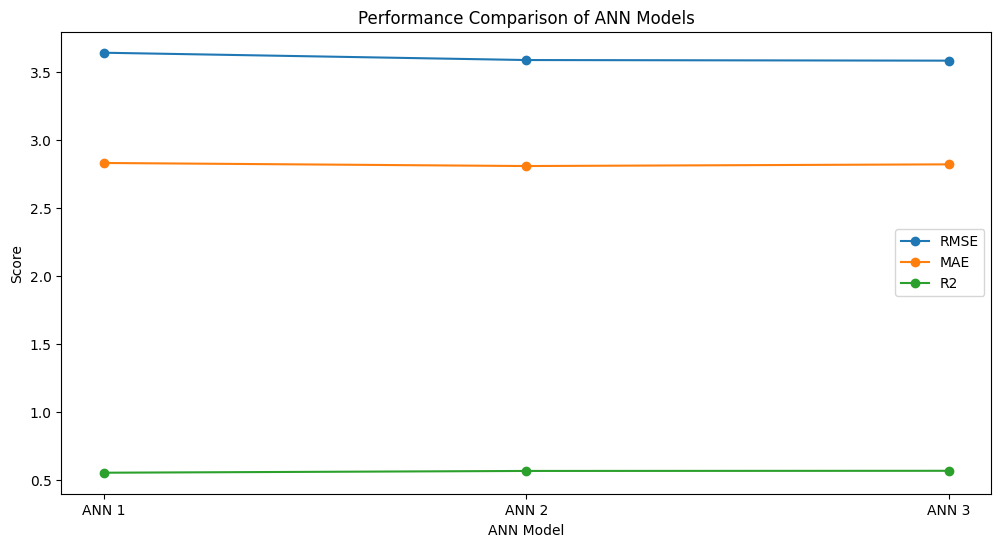

In [ ]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("ANN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of ANN Models")
plt.legend()
plt.show()

## PREDIKSI 15 HARI

### RNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Load data
data = data_spring  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1740994759.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1740994759.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
def create_sequences(data, target, sequence_length=33, predict_days=15):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))

        # Simulate prediction for the next 15 days (lag of 33)
        labels.append(np.nan)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]
        avg_last_two_values = np.mean(last_two_values)

        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values

    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=33)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6386, 33, 1)
Shape of y: (6386,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2, model

In [ ]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Start with the last available sequence

    for _ in range(days):
        # Predict the next day (model expects input in 3D: batch_size, sequence_length, features)
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))  # Ensure it's 3D

        predictions.append(pred[0, 0])  # Append the scalar prediction value

        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)  # Add the predicted value to the sequence

        # Ensure the new sequence shape is correct for the next prediction
        current_input = current_input.reshape(-1, 1)  # Keep the sequence 2D for the next iteration

    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [ ]:
# Define list containing different configurations for evaluation purposes
rnn_configs = [
    {'hidden_units': [5], 'epochs': 104},
    {'hidden_units': [1, 10], 'epochs': 156},
    {'hidden_units': [4, 4, 7], 'epochs': 204}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(rnn_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])

    # Append evaluation results to the list
    results.append({
        'Model': f'RNN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)


Epoch 1/104
256/256 [==============================] - 3s 6ms/step - loss: 0.1269 - val_loss: 0.0617
Epoch 2/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0356 - val_loss: 0.0191
Epoch 3/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0146 - val_loss: 0.0119
Epoch 4/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 5/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 6/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0106 - val_loss: 0.0099
Epoch 7/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0094 - val_loss: 0.0083
Epoch 8/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0070 - val_loss: 0.0040
Epoch 9/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 5.4906e-04
Epoch 10/104
256/256 [==============================] - 1s 4ms/step - loss: 5.2964e-04 

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2  \
0  RNN 1          [5]     104  0.004813  0.001438  0.999997   
1  RNN 2      [1, 10]     156  0.022368  0.021489  0.999940   
2  RNN 3    [4, 4, 7]     204  0.025740  0.017570  0.999921   

                                        Model_Object  
0  <keras.src.engine.sequential.Sequential object...  
1  <keras.src.engine.sequential.Sequential object...  
2  <keras.src.engine.sequential.Sequential object...

In [ ]:
results_df.to_csv(f'HASIL/15_RNN_SPRING.csv', index=False)

In [ ]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model              RNN 1
Hidden Units         [5]
Epochs               104
RMSE            0.004813
MAE             0.001438
R2              0.999997
Name: 0, dtype: object
1/1 [==============================] - 0s 35ms/step

Predictions for the next 15 days using the best model:
[17.4994   17.45009  17.473074 17.460468 17.46583  17.462427 17.463552
 17.462584 17.462809 17.46255  17.462639 17.46266  17.462797 17.462942
 17.46315 ]


In [ ]:
predictions_rescaled

array([[17.4994  ],
       [17.45009 ],
       [17.473074],
       [17.460468],
       [17.46583 ],
       [17.462427],
       [17.463552],
       [17.462584],
       [17.462809],
       [17.46255 ],
       [17.462639],
       [17.46266 ],
       [17.462797],
       [17.462942],
       [17.46315 ]], dtype=float32)

In [ ]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [ ]:
df_predictions

Predicted_Value
0         17.499399
1         17.450090
2         17.473074
3         17.460468
4         17.465830
5         17.462427
6         17.463552
7         17.462584
8         17.462809
9         17.462549
10        17.462639
11        17.462660
12        17.462797
13        17.462942
14        17.463150

In [ ]:
df_predictions.to_csv(f'HASIL_PREDICT/15_RNN_SPRING.csv', index=False)

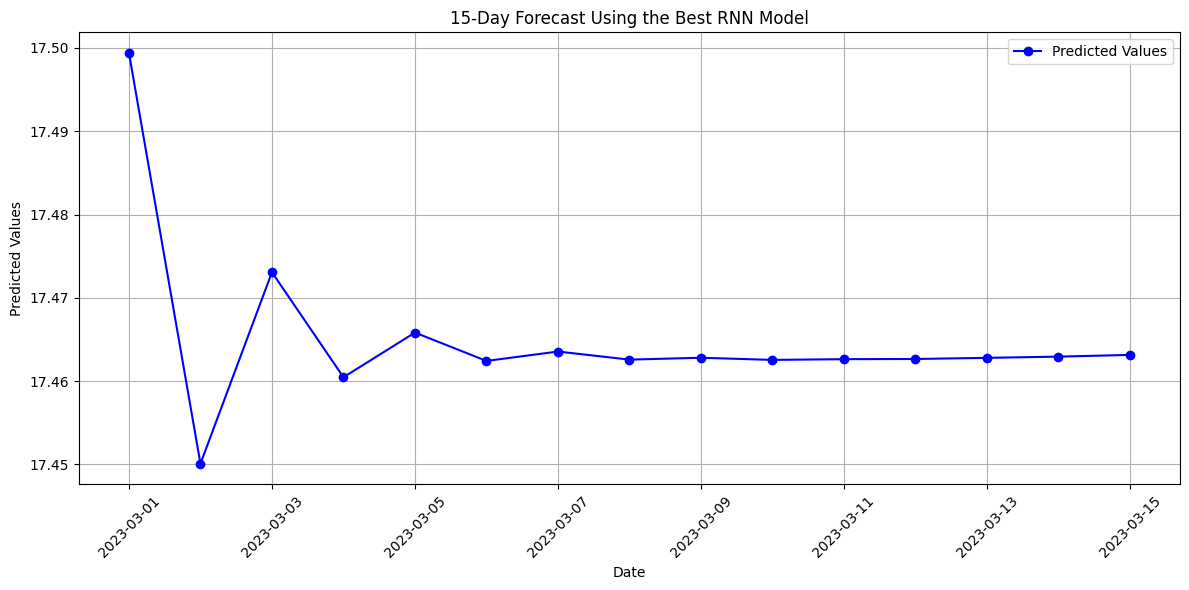

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_winter['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best RNN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

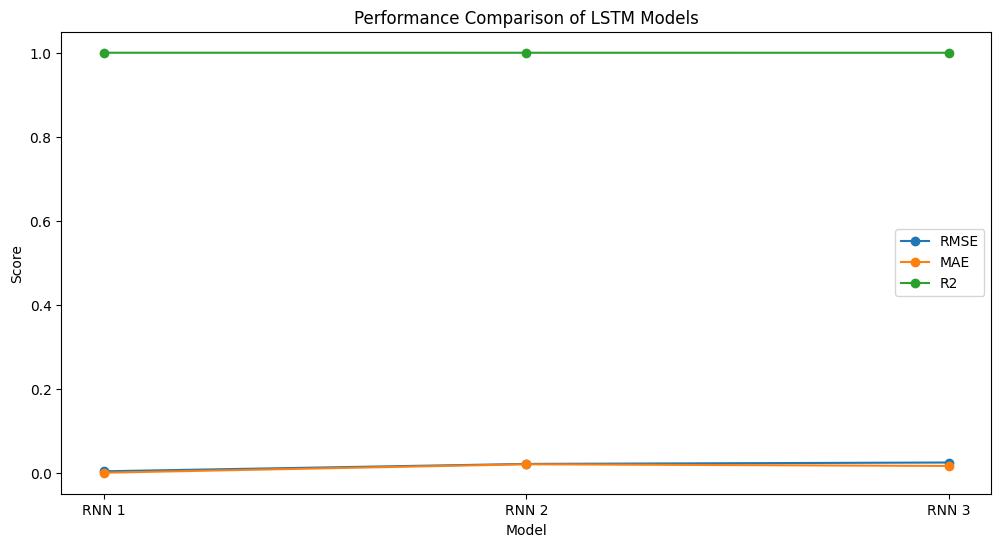

In [ ]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Load data
data = data_spring  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1486678579.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1486678579.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
def create_sequences(data, target, sequence_length=34, predict_days=15):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)

        # Simulate prediction for the next 15 days (lag of 34)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)

        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values

    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=34)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6534, 34, 1)
Shape of y: (6534,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    # Return RMSE, MAE, R2, and model
    return rmse, mae, r2, model


In [ ]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Start with the last available sequence

    for _ in range(days):
        # Predict the next day (model expects input in 3D: batch_size, sequence_length, features)
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))  # Ensure it's 3D

        predictions.append(pred[0, 0])  # Append the scalar prediction value

        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)  # Add the predicted value to the sequence

        # Ensure the new sequence shape is correct for the next prediction
        current_input = current_input.reshape(-1, 1)  # Keep the sequence 2D for the next iteration

    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [ ]:
# Define list containing different configurations for evaluation purposes
lstm_configs = [
    {'hidden_units': [3], 'epochs': 273},
    {'hidden_units': [3, 20], 'epochs': 285},
    {'hidden_units': [6, 11, 18], 'epochs': 280}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(lstm_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_lstm_model(config['hidden_units'], config['epochs'])

    # Append evaluation results to the list
    results.append({
        'Model': f'LSTM {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)


Epoch 1/273
262/262 [==============================] - 5s 12ms/step - loss: 0.1875 - val_loss: 0.0325
Epoch 2/273
262/262 [==============================] - 3s 10ms/step - loss: 0.0253 - val_loss: 0.0216
Epoch 3/273
262/262 [==============================] - 3s 10ms/step - loss: 0.0171 - val_loss: 0.0149
Epoch 4/273
262/262 [==============================] - 2s 9ms/step - loss: 0.0118 - val_loss: 0.0106
Epoch 5/273
262/262 [==============================] - 2s 9ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 6/273
262/262 [==============================] - 2s 8ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 7/273
262/262 [==============================] - 2s 8ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 8/273
262/262 [==============================] - 2s 8ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 9/273
262/262 [==============================] - 2s 8ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 10/273
262/262 [==============================] - 2s 8ms/step - loss: 0.0031 - val

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2  \
0  LSTM 1          [3]     273  0.315612  0.240317  0.996095   
1  LSTM 2      [3, 20]     285  0.050533  0.048324  0.999900   
2  LSTM 3  [6, 11, 18]     280  0.052719  0.046798  0.999891   

                                        Model_Object  
0  <keras.src.engine.sequential.Sequential object...  
1  <keras.src.engine.sequential.Sequential object...  
2  <keras.src.engine.sequential.Sequential object...

In [ ]:
results_df.to_csv(f'HASIL/15_LSTM_SPRING.csv', index=False)

In [ ]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model             LSTM 2
Hidden Units     [3, 20]
Epochs               285
RMSE            0.050533
MAE             0.048324
R2                0.9999
Name: 1, dtype: object
1/1 [==============================] - 0s 21ms/step

Predictions for the next 15 days using the best model:
[11.691795 11.481479 11.525018 11.43513  11.421686 11.365504 11.332563
 11.286868 11.247507 11.204364 11.162786 11.120056 11.077606 11.034947
 10.992435]


In [ ]:
predictions_rescaled

array([[11.691795],
       [11.481479],
       [11.525018],
       [11.43513 ],
       [11.421686],
       [11.365504],
       [11.332563],
       [11.286868],
       [11.247507],
       [11.204364],
       [11.162786],
       [11.120056],
       [11.077606],
       [11.034947],
       [10.992435]], dtype=float32)

In [ ]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [ ]:
df_predictions

Predicted_Value
0         11.691795
1         11.481479
2         11.525018
3         11.435130
4         11.421686
5         11.365504
6         11.332563
7         11.286868
8         11.247507
9         11.204364
10        11.162786
11        11.120056
12        11.077606
13        11.034947
14        10.992435

In [ ]:
df_predictions.to_csv(f'HASIL_PREDICT/15_LSTM_SPRING.csv', index=False)

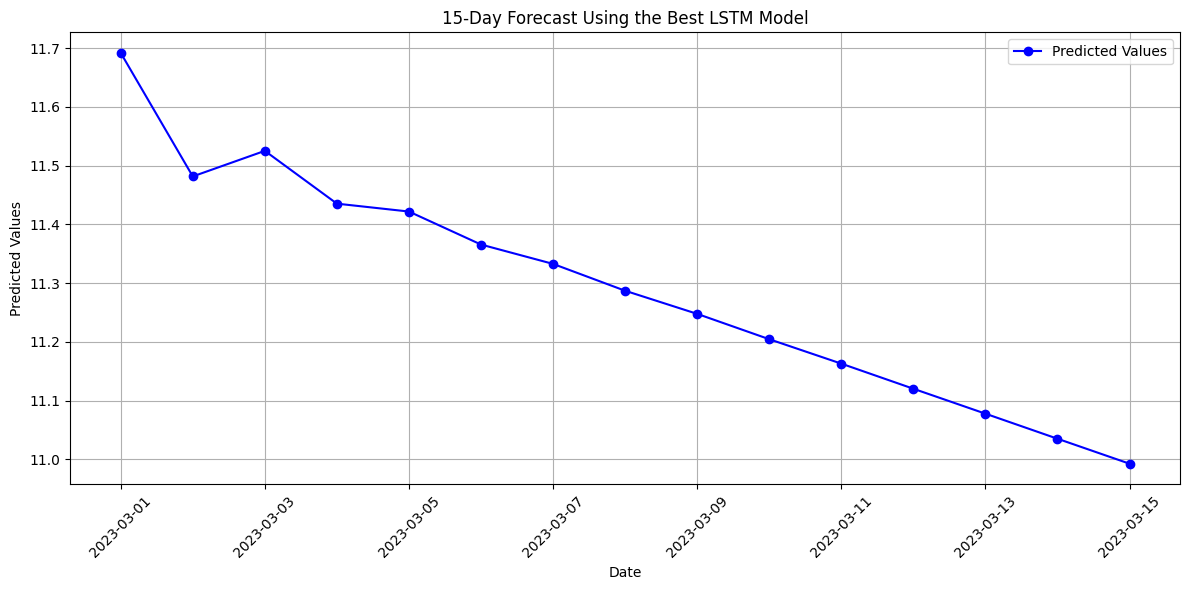

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_winter['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best LSTM Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

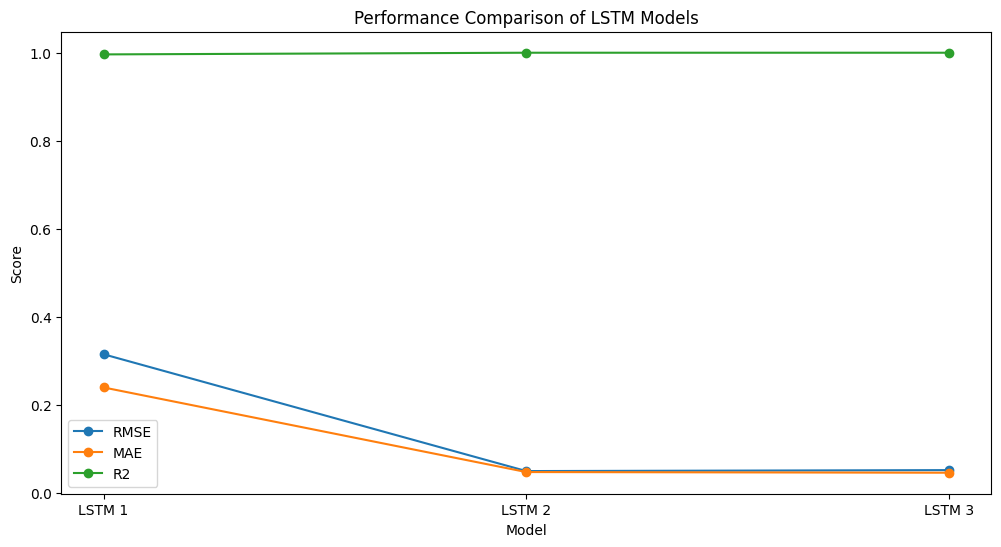

In [ ]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Load data
data = data_spring  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_104372\1486678579.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_104372\1486678579.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
def create_sequences(data, target, sequence_length=33, predict_days=15):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)

        # Simulate prediction for the next 15 days (lag of 33)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)

        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values

    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=33)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6535, 33, 1)
Shape of y: (6535,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))

    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))

    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')

    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2, model

In [ ]:
last_sequence = X_test[-1].reshape(1, -1)

In [ ]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence.flatten()  # Flatten the sequence to match the training input

    for _ in range(days):
        # Predict the next day using the flattened input
        pred = model.predict(current_input.reshape(1, -1))  # Ensure it's 2D as expected by the model

        predictions.append(pred[0, 0])  # Append the scalar prediction value

        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)  # Keep sequence 1D to match the model input

    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled


In [ ]:
# Define list containing different configurations for evaluation purposes
ann_configs = [
    {'hidden_units': [2], 'epochs': 268},
    {'hidden_units': [4, 16], 'epochs': 263},
    {'hidden_units': [14, 8, 17], 'epochs': 100}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(ann_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_ann_model(config['hidden_units'], config['epochs'])

    # Append evaluation results to the list
    results.append({
        'Model': f'ANN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)



Epoch 1/268

262/262 [==============================] - 1s 2ms/step - loss: 0.0511 - val_loss: 0.0331
Epoch 2/268
262/262 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0247
Epoch 3/268
262/262 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0192
Epoch 4/268
262/262 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0148
Epoch 5/268
262/262 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0114
Epoch 6/268
262/262 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0083
Epoch 7/268
262/262 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0060
Epoch 8/268
262/262 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 9/268
262/262 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 10/268
262/262 [==============================] - 0s 2ms/step - loss: 0.0028 - val_

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2  \
0  ANN 1          [2]     268  0.000364  0.000336  1.000000   
1  ANN 2      [4, 16]     263  0.027014  0.026207  0.999972   
2  ANN 3  [14, 8, 17]     100  0.069149  0.054011  0.999815   

                                        Model_Object  
0  <keras.src.engine.sequential.Sequential object...  
1  <keras.src.engine.sequential.Sequential object...  
2  <keras.src.engine.sequential.Sequential object...

In [ ]:
results_df.to_csv(f'HASIL/15_ANN_SPRING.csv', index=False)

In [ ]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model              ANN 1
Hidden Units         [2]
Epochs               268
RMSE            0.000364
MAE             0.000336
R2                   1.0
Name: 0, dtype: object
1/1 [==============================] - 0s 22ms/step

Predictions for the next 15 days using the best model:
[10.199414 11.149396 10.673887 10.911309 10.792287 10.851505 10.821572
 10.836157 10.828484 10.831874 10.829734 10.830471 10.829897 10.829833
 10.829775]


In [ ]:
predictions_rescaled

array([[10.199414],
       [11.149396],
       [10.673887],
       [10.911309],
       [10.792287],
       [10.851505],
       [10.821572],
       [10.836157],
       [10.828484],
       [10.831874],
       [10.829734],
       [10.830471],
       [10.829897],
       [10.829833],
       [10.829775]], dtype=float32)

In [ ]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [ ]:
df_predictions

Predicted_Value
0         10.199414
1         11.149396
2         10.673887
3         10.911309
4         10.792287
5         10.851505
6         10.821572
7         10.836157
8         10.828484
9         10.831874
10        10.829734
11        10.830471
12        10.829897
13        10.829833
14        10.829775

In [ ]:
df_predictions.to_csv(f'HASIL_PREDICT/15_ANN_SPRING.csv', index=False)

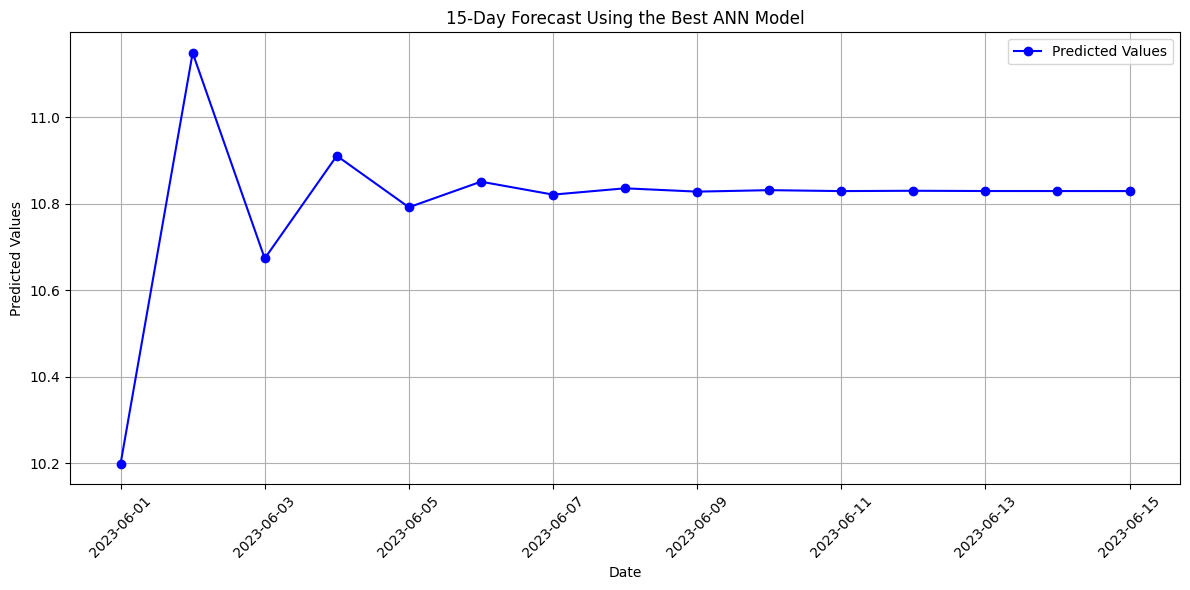

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_spring['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best ANN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

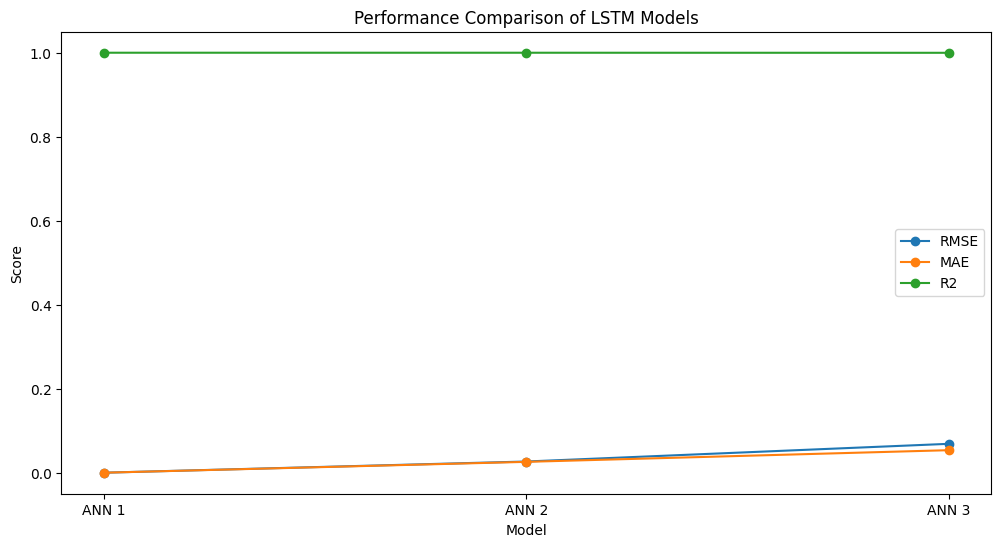

In [ ]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

# SUMMER

In [ ]:
import pandas as pd
data_summer = pd.read_csv('DATASET/SEASON/data_Summer.csv')
data_summer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6588 entries, 0 to 6587
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  6588 non-null   int64  
 1   city_name   6588 non-null   object 
 2   date        6588 non-null   object 
 3   season      6588 non-null   object 
 4   avg_temp_c  6394 non-null   float64
 5   min_temp_c  6365 non-null   float64
 6   max_temp_c  6588 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 360.4+ KB


In [ ]:
data_summer

station_id city_name        date  season  avg_temp_c  min_temp_c  \
0          47662     Tokyo  1951-06-01  Summer         NaN        18.1   
1          47662     Tokyo  1951-06-02  Summer         NaN        16.2   
2          47662     Tokyo  1951-06-03  Summer         NaN        17.4   
3          47662     Tokyo  1951-06-04  Summer         NaN        17.7   
4          47662     Tokyo  1951-06-05  Summer         NaN        18.8   
...          ...       ...         ...     ...         ...         ...   
6583       47662     Tokyo  2023-08-27  Summer        27.3        24.8   
6584       47662     Tokyo  2023-08-28  Summer        28.2        25.0   
6585       47662     Tokyo  2023-08-29  Summer        29.5        26.7   
6586       47662     Tokyo  2023-08-30  Summer        29.5        26.9   
6587       47662     Tokyo  2023-08-31  Summer        29.4        26.9   

      max_temp_c  
0           25.4  
1           30.0  
2           30.3  
3           26.5  
4           25.2  
...          ...  
6583        30.2  
6584        31.5  
6585        33.3  
6586        32.8  
6587        32.9  

[6588 rows x 7 columns]

## PREDIKSI 1 HARI

### RNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_summer  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1071411982.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1071411982.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6581, 7, 1)
Shape of y: (6581,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# RNN configurations based on the table provided
rnn_configs = [
    {'hidden_units': [8], 'epochs': 50},
    {'hidden_units': [6, 13], 'epochs': 156},
    {'hidden_units': [1, 10, 12], 'epochs': 156}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(rnn_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'RNN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/50
264/264 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0106
Epoch 2/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0103
Epoch 3/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0103
Epoch 4/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 5/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 6/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 7/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 8/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 9/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 10/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0103

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2
0  RNN 1          [8]      50  2.709360  2.047913  0.556473
1  RNN 2      [6, 13]     156  2.702813  2.032675  0.558615
2  RNN 3  [1, 10, 12]     156  2.736316  2.047577  0.547604

In [ ]:
results_df.to_csv(f'HASIL/RNN_SUMMER.csv', index=False)

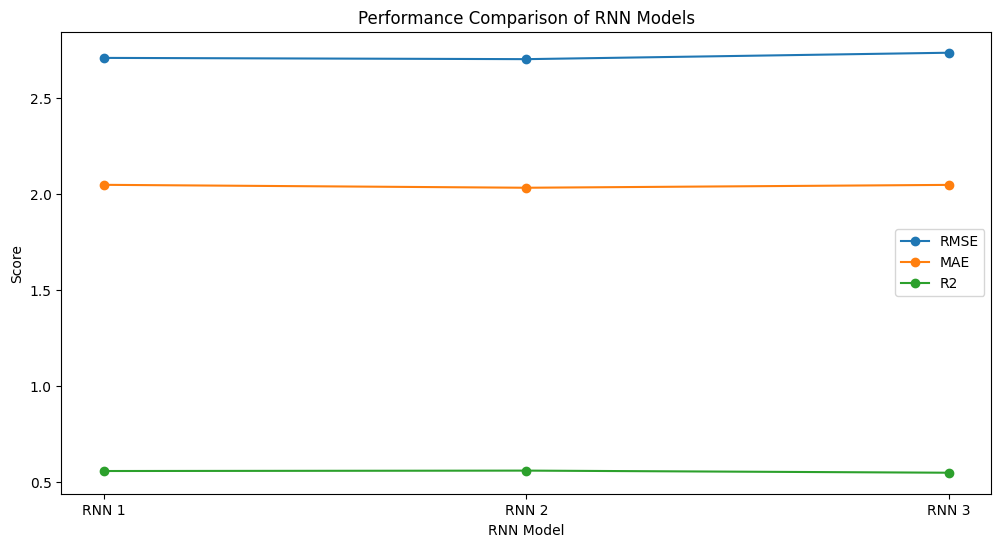

In [ ]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("RNN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of RNN Models")
plt.legend()
plt.show()

### LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
# Load data
data = data_summer  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1071411982.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1071411982.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6581, 7, 1)
Shape of y: (6581,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# LSTM configurations based on the table provided
lstm_configs = [
    {'hidden_units': [3], 'epochs': 25},
    {'hidden_units': [6,6], 'epochs': 91},
    {'hidden_units': [1, 19, 17], 'epochs': 156}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(lstm_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'LSTM {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/25
264/264 [==============================] - 2s 3ms/step - loss: 0.1030 - val_loss: 0.0144
Epoch 2/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0138
Epoch 3/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0131
Epoch 4/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0125
Epoch 5/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 6/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0118
Epoch 7/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0119 - val_loss: 0.0115
Epoch 8/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0115 - val_loss: 0.0111
Epoch 9/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 10/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0113 - val_loss: 0.0109

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2
0  LSTM 1          [3]      25  0.102524  0.077965  0.550632
1  LSTM 2       [6, 6]      91  0.102691  0.079047  0.549166
2  LSTM 3  [1, 19, 17]     156  0.152970  0.127903 -0.000367

In [ ]:
results_df.to_csv(f'HASIL/LSTM_SUMMER.csv', index=False)

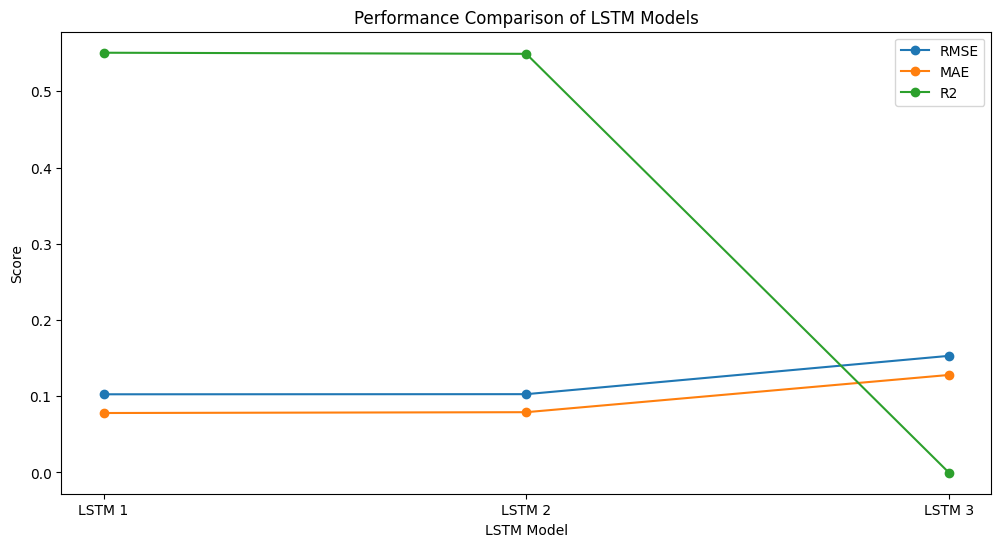

In [ ]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("LSTM Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_summer  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\71918029.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\71918029.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6581, 7, 1)
Shape of y: (6581,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))

    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))

    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')

    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# ANN configurations based on the table provided
ann_configs = [
    {'hidden_units': [2], 'epochs': 268},
    {'hidden_units': [6, 5], 'epochs': 263},
    {'hidden_units': [11, 11, 2], 'epochs': 288}
]

In [ ]:
# Train and evaluate each configuration
results = []
for i, config in enumerate(ann_configs):
    rmse, mae, r2 = train_evaluate_ann_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'ANN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/268
264/264 [==============================] - 1s 2ms/step - loss: 0.1430 - val_loss: 0.0228
Epoch 2/268
264/264 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0209
Epoch 3/268
264/264 [==============================] - 0s 2ms/step - loss: 0.0198 - val_loss: 0.0194
Epoch 4/268
264/264 [==============================] - 0s 1ms/step - loss: 0.0184 - val_loss: 0.0180
Epoch 5/268
264/264 [==============================] - 0s 1ms/step - loss: 0.0172 - val_loss: 0.0168
Epoch 6/268
264/264 [==============================] - 0s 1ms/step - loss: 0.0162 - val_loss: 0.0159
Epoch 7/268
264/264 [==============================] - 0s 1ms/step - loss: 0.0154 - val_loss: 0.0153
Epoch 8/268
264/264 [==============================] - 0s 2ms/step - loss: 0.0147 - val_loss: 0.0144
Epoch 9/268
264/264 [==============================] - 0s 1ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 10/268
264/264 [==============================] - 0s 1ms/step - loss: 0.0135 - val_lo

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2
0  ANN 1          [2]     268  0.102645  0.079420  0.549575
1  ANN 2       [6, 5]     263  0.103066  0.080193  0.545865
2  ANN 3  [11, 11, 2]     288  0.102469  0.077016  0.551118

In [ ]:
results_df.to_csv(f'HASIL/ANN_SUMMER.csv', index=False)

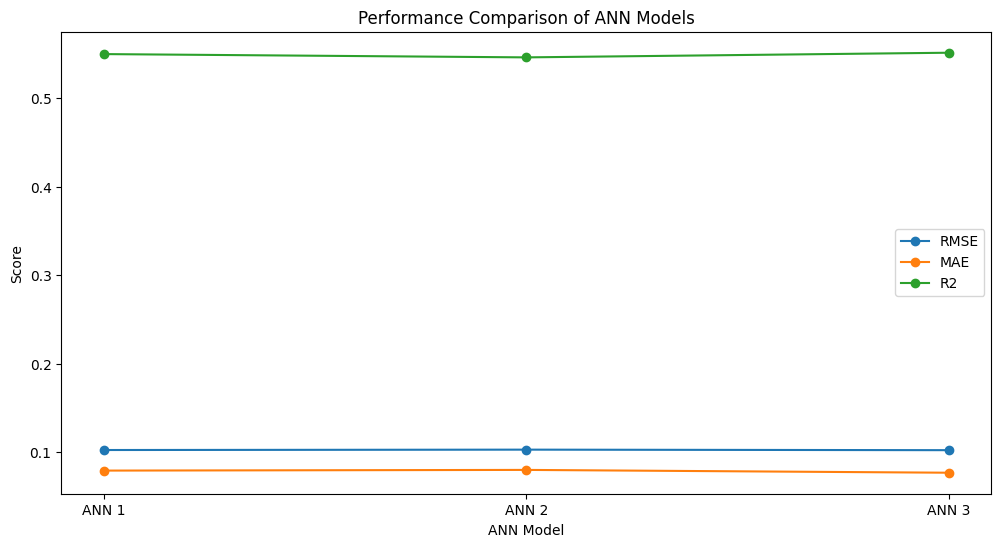

In [ ]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("ANN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of ANN Models")
plt.legend()
plt.show()

## PREDIKSI 15 HARI

### RNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Load data
data = data_summer  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_99100\1297502850.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_99100\1297502850.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
data

station_id city_name        date  season  avg_temp_c  min_temp_c  \
0          47662     Tokyo  1951-06-01  Summer         NaN        18.1   
1          47662     Tokyo  1951-06-02  Summer         NaN        16.2   
2          47662     Tokyo  1951-06-03  Summer         NaN        17.4   
3          47662     Tokyo  1951-06-04  Summer         NaN        17.7   
4          47662     Tokyo  1951-06-05  Summer         NaN        18.8   
...          ...       ...         ...     ...         ...         ...   
6583       47662     Tokyo  2023-08-27  Summer        27.3        24.8   
6584       47662     Tokyo  2023-08-28  Summer        28.2        25.0   
6585       47662     Tokyo  2023-08-29  Summer        29.5        26.7   
6586       47662     Tokyo  2023-08-30  Summer        29.5        26.9   
6587       47662     Tokyo  2023-08-31  Summer        29.4        26.9   

      max_temp_c  
0       0.469925  
1       0.642857  
2       0.654135  
3       0.511278  
4       0.462406  
...          ...  
6583    0.650376  
6584    0.699248  
6585    0.766917  
6586    0.748120  
6587    0.751880  

[6588 rows x 7 columns]

In [ ]:
def create_sequences(data, target, sequence_length=12, predict_days=15):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)

        # Simulate prediction for the next 15 days (lag of 12)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)

        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values

    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=12)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6576, 12, 1)
Shape of y: (6576,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2, model

In [ ]:
# Fungsi prediksi untuk 15 hari ke depan
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Mulai dengan sequence terakhir

    for _ in range(days):
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))
        predictions.append(pred[0, 0])
        current_input = np.append(current_input[1:], pred).reshape(-1, 1)

    # Ubah prediksi ke skala aslinya
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [ ]:
# Define list containing different configurations for evaluation purposes
rnn_configs = [
    {'hidden_units': [8], 'epochs': 50},
    {'hidden_units': [6, 13], 'epochs': 156},
    {'hidden_units': [1, 10, 12], 'epochs': 156}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(rnn_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])

    # Append evaluation results to the list
    results.append({
        'Model': f'RNN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)


Epoch 1/50
263/263 [==============================] - 2s 4ms/step - loss: 0.1686 - val_loss: 0.0016
Epoch 2/50
263/263 [==============================] - 1s 3ms/step - loss: 6.4558e-04 - val_loss: 2.4719e-04
Epoch 3/50
263/263 [==============================] - 1s 4ms/step - loss: 1.5729e-04 - val_loss: 6.5371e-05
Epoch 4/50
263/263 [==============================] - 1s 3ms/step - loss: 4.9040e-05 - val_loss: 3.3355e-05
Epoch 5/50
263/263 [==============================] - 1s 3ms/step - loss: 3.0013e-05 - val_loss: 1.9979e-05
Epoch 6/50
263/263 [==============================] - 1s 3ms/step - loss: 1.6485e-05 - val_loss: 2.1020e-05
Epoch 7/50
263/263 [==============================] - 1s 3ms/step - loss: 1.0044e-05 - val_loss: 6.4500e-06
Epoch 8/50
263/263 [==============================] - 1s 4ms/step - loss: 5.9840e-06 - val_loss: 6.4633e-06
Epoch 9/50
263/263 [==============================] - 1s 3ms/step - loss: 4.7526e-06 - val_loss: 3.8888e-06
Epoch 10/50
263/263 [===============

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2  \
0  RNN 1          [8]      50  0.020192  0.018019  0.999973   
1  RNN 2      [6, 13]     156  0.011567  0.005365  0.999991   
2  RNN 3  [1, 10, 12]     156  3.860981  3.274889 -0.000887   

                                        Model_Object  
0  <keras.src.engine.sequential.Sequential object...  
1  <keras.src.engine.sequential.Sequential object...  
2  <keras.src.engine.sequential.Sequential object...

In [ ]:
results_df.to_csv(f'HASIL/15_RNN_SUMMER.csv', index=False)

In [ ]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model              RNN 2
Hidden Units     [6, 13]
Epochs               156
RMSE            0.011567
MAE             0.005365
R2              0.999991
Name: 1, dtype: object
1/1 [==============================] - 0s 23ms/step

Predictions for the next 15 days using the best model:
[26.753399 27.577435 27.168793 27.371386 27.26936  27.319641 27.293766
 27.306221 27.304161 27.304445 27.30869  27.308111 27.31136  27.31199
 27.314283]


In [ ]:
predictions_rescaled

array([[26.753399],
       [27.577435],
       [27.168793],
       [27.371386],
       [27.26936 ],
       [27.319641],
       [27.293766],
       [27.306221],
       [27.304161],
       [27.304445],
       [27.30869 ],
       [27.308111],
       [27.31136 ],
       [27.31199 ],
       [27.314283]], dtype=float32)

In [ ]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [ ]:
df_predictions

Predicted_Value
0         26.753399
1         27.577435
2         27.168793
3         27.371386
4         27.269360
5         27.319641
6         27.293766
7         27.306221
8         27.304161
9         27.304445
10        27.308689
11        27.308111
12        27.311359
13        27.311991
14        27.314283

In [ ]:
df_predictions.to_csv(f'HASIL_PREDICT/15_RNN_SUMMER.csv', index=False)

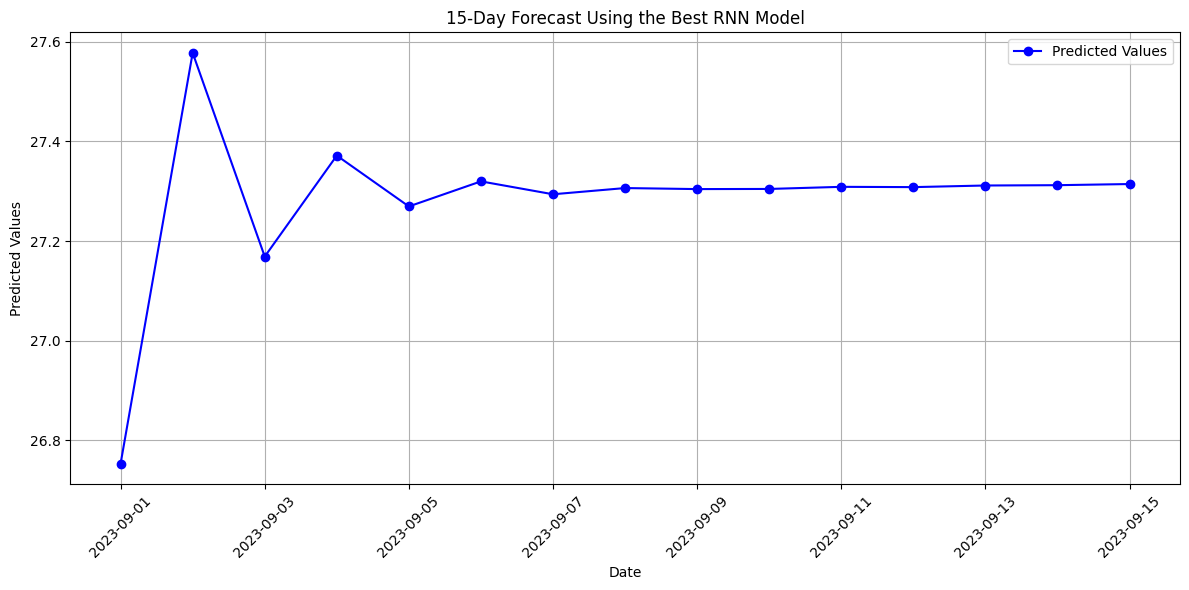

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_summer['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best RNN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

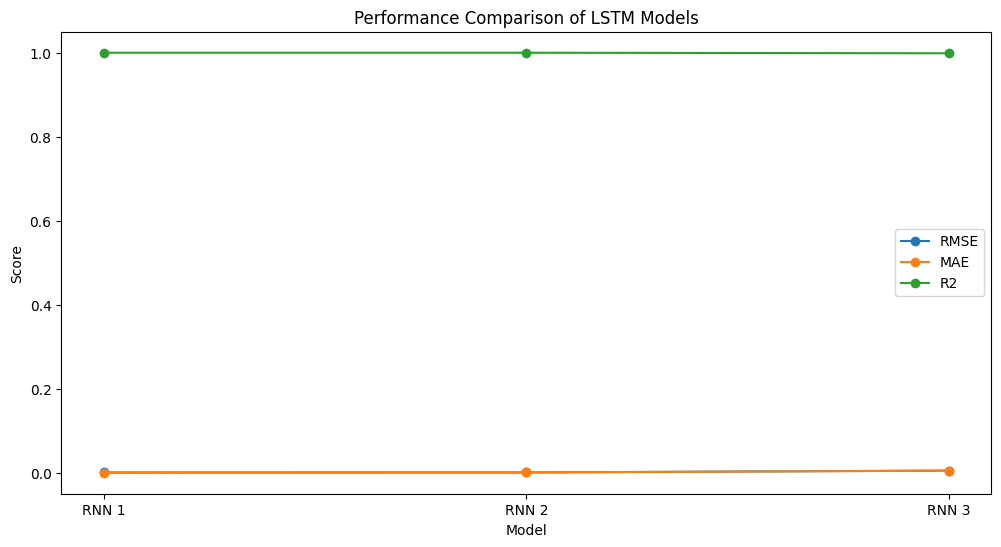

In [ ]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Load data
data = data_summer  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100768\1297502850.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100768\1297502850.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
def create_sequences(data, target, sequence_length=35, predict_days=15):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)

        # Simulate prediction for the next 15 days (lag of 35)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)

        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values

    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=35)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6553, 35, 1)
Shape of y: (6553,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    # Return RMSE, MAE, R2, and model
    return rmse, mae, r2, model


In [ ]:
# Fungsi prediksi untuk 15 hari ke depan
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Mulai dengan sequence terakhir

    for _ in range(days):
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))
        predictions.append(pred[0, 0])
        current_input = np.append(current_input[1:], pred).reshape(-1, 1)

    # Ubah prediksi ke skala aslinya
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [ ]:
# Define list containing different configurations for evaluation purposes
lstm_configs = [
    {'hidden_units': [3], 'epochs': 25},
    {'hidden_units': [6,6], 'epochs': 91},
    {'hidden_units': [1, 19, 17], 'epochs': 156}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(lstm_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_lstm_model(config['hidden_units'], config['epochs'])

    # Append evaluation results to the list
    results.append({
        'Model': f'LSTM {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)



Epoch 1/25

263/263 [==============================] - 4s 8ms/step - loss: 0.2815 - val_loss: 0.1555
Epoch 2/25
263/263 [==============================] - 2s 7ms/step - loss: 0.1020 - val_loss: 0.0588
Epoch 3/25
263/263 [==============================] - 2s 9ms/step - loss: 0.0391 - val_loss: 0.0240
Epoch 4/25
263/263 [==============================] - 2s 8ms/step - loss: 0.0176 - val_loss: 0.0087
Epoch 5/25
263/263 [==============================] - 3s 11ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 6/25
263/263 [==============================] - 3s 11ms/step - loss: 7.0748e-04 - val_loss: 5.5115e-04
Epoch 7/25
263/263 [==============================] - 3s 10ms/step - loss: 5.0226e-04 - val_loss: 4.3702e-04
Epoch 8/25
263/263 [==============================] - 2s 9ms/step - loss: 4.1966e-04 - val_loss: 3.4840e-04
Epoch 9/25
263/263 [==============================] - 3s 10ms/step - loss: 3.6778e-04 - val_loss: 2.9252e-04
Epoch 10/25
263/263 [==============================] - 2s 9ms/

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2  \
0  LSTM 1          [3]      25  0.269784  0.210935  0.995085   
1  LSTM 2       [6, 6]      91  0.248080  0.242053  0.995844   
2  LSTM 3  [1, 19, 17]     156  3.849767  3.246808 -0.000878   

                                        Model_Object  
0  <keras.src.engine.sequential.Sequential object...  
1  <keras.src.engine.sequential.Sequential object...  
2  <keras.src.engine.sequential.Sequential object...

In [ ]:
results_df.to_csv(f'HASIL/15_LSTM_SUMMER.csv', index=False)

In [ ]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model             LSTM 2
Hidden Units      [6, 6]
Epochs                91
RMSE             0.24808
MAE             0.242053
R2              0.995844
Name: 1, dtype: object
1/1 [==============================] - 0s 32ms/step

Predictions for the next 15 days using the best model:
[27.335924 27.199478 27.03319  26.86105  26.710178 26.550583 26.395227
 26.236996 26.079048 25.920687 25.763237 25.605476 25.448233 25.292212
 25.13706 ]


In [ ]:
predictions_rescaled

array([[27.335924],
       [27.199478],
       [27.03319 ],
       [26.86105 ],
       [26.710178],
       [26.550583],
       [26.395227],
       [26.236996],
       [26.079048],
       [25.920687],
       [25.763237],
       [25.605476],
       [25.448233],
       [25.292212],
       [25.13706 ]], dtype=float32)

In [ ]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [ ]:
df_predictions

Predicted_Value
0         27.335924
1         27.199478
2         27.033190
3         26.861050
4         26.710178
5         26.550583
6         26.395227
7         26.236996
8         26.079048
9         25.920687
10        25.763237
11        25.605476
12        25.448233
13        25.292212
14        25.137060

In [ ]:
df_predictions.to_csv(f'HASIL_PREDICT/15_LSTM_SUMMER.csv', index=False)

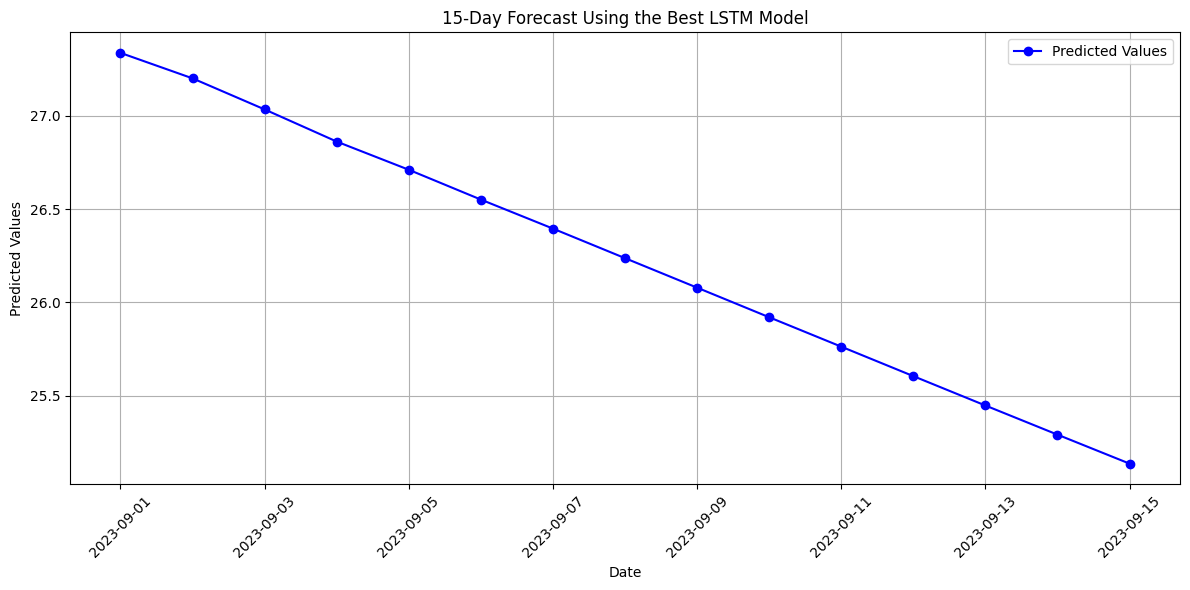

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_summer['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best LSTM Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

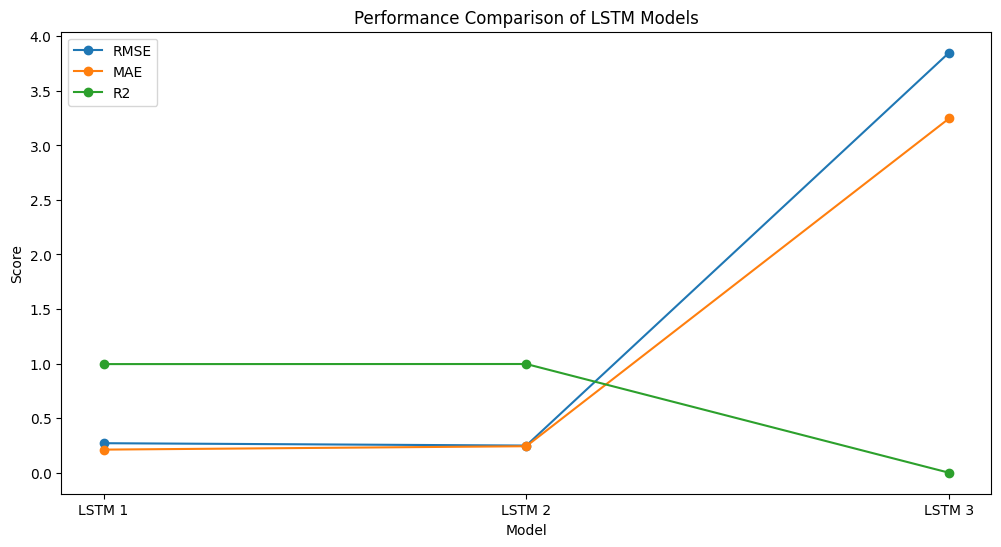

In [ ]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Load data
data = data_summer  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_81168\1297502850.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_81168\1297502850.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
def create_sequences(data, target, sequence_length=15, predict_days=15):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)

        # Simulate prediction for the next 15 days (lag of 15)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)

        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values

    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=15)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6573, 15, 1)
Shape of y: (6573,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))

    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))

    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')

    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2, model

In [ ]:
last_sequence = X_test[-1].reshape(1, -1)

In [ ]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence.flatten()  # Flatten the sequence to match the training input

    for _ in range(days):
        # Predict the next day using the flattened input
        pred = model.predict(current_input.reshape(1, -1))  # Ensure it's 2D as expected by the model

        predictions.append(pred[0, 0])  # Append the scalar prediction value

        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)  # Keep sequence 1D to match the model input

    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled


In [ ]:
# Define list containing different configurations for evaluation purposes
ann_configs = [
    {'hidden_units': [2], 'epochs': 268},
    {'hidden_units': [6, 5], 'epochs': 263},
    {'hidden_units': [11, 11, 2], 'epochs': 288}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(ann_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_ann_model(config['hidden_units'], config['epochs'])

    # Append evaluation results to the list
    results.append({
        'Model': f'ANN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)



Epoch 1/268

263/263 [==============================] - 1s 2ms/step - loss: 0.2532 - val_loss: 0.1601
Epoch 2/268
263/263 [==============================] - 0s 2ms/step - loss: 0.0964 - val_loss: 0.0623
Epoch 3/268
263/263 [==============================] - 1s 2ms/step - loss: 0.0391 - val_loss: 0.0306
Epoch 4/268
263/263 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.0229
Epoch 5/268
263/263 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0193
Epoch 6/268
263/263 [==============================] - 0s 2ms/step - loss: 0.0178 - val_loss: 0.0179
Epoch 7/268
263/263 [==============================] - 0s 2ms/step - loss: 0.0165 - val_loss: 0.0165
Epoch 8/268
263/263 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0149
Epoch 9/268
263/263 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.0133
Epoch 10/268
263/263 [==============================] - 1s 2ms/step - loss: 0.0117 - val_

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2  \
0  ANN 1          [2]     268  0.026735  0.004830  0.999952   
1  ANN 2       [6, 5]     263  0.039319  0.021580  0.999897   
2  ANN 3  [11, 11, 2]     288  0.026037  0.014112  0.999955   

                                        Model_Object  
0  <keras.src.engine.sequential.Sequential object...  
1  <keras.src.engine.sequential.Sequential object...  
2  <keras.src.engine.sequential.Sequential object...

In [ ]:
results_df.to_csv(f'HASIL/15_ANN_SUMMER.csv', index=False)

In [ ]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model                 ANN 3
Hidden Units    [11, 11, 2]
Epochs                  288
RMSE               0.026037
MAE                0.014112
R2                 0.999955
Name: 2, dtype: object
1/1 [==============================] - 0s 26ms/step

Predictions for the next 15 days using the best model:
[28.639471 28.65701  28.636475 28.633104 28.624552 28.6164   28.609718
 28.599758 28.592592 28.583475 28.575773 28.566547 28.558064 28.549171
 28.540508]


In [ ]:
predictions_rescaled

array([[28.639471],
       [28.65701 ],
       [28.636475],
       [28.633104],
       [28.624552],
       [28.6164  ],
       [28.609718],
       [28.599758],
       [28.592592],
       [28.583475],
       [28.575773],
       [28.566547],
       [28.558064],
       [28.549171],
       [28.540508]], dtype=float32)

In [ ]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [ ]:
df_predictions

Predicted_Value
0         28.639471
1         28.657009
2         28.636475
3         28.633104
4         28.624552
5         28.616400
6         28.609718
7         28.599758
8         28.592592
9         28.583475
10        28.575773
11        28.566547
12        28.558064
13        28.549171
14        28.540508

In [ ]:
df_predictions.to_csv(f'HASIL_PREDICT/15_ANN_SUMMER.csv', index=False)

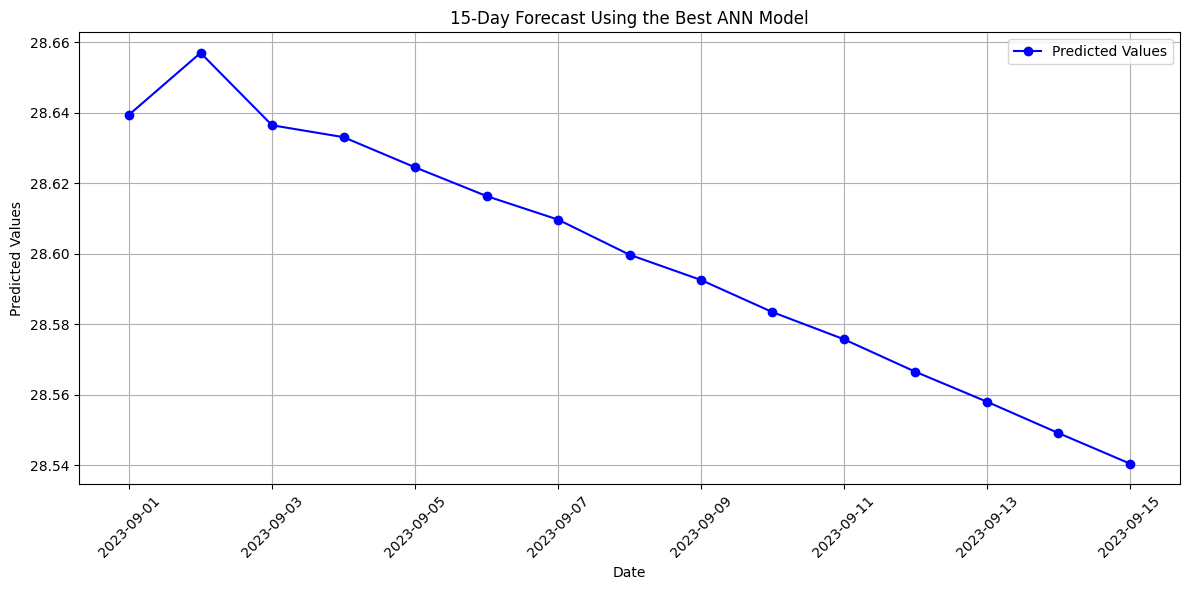

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_summer['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best ANN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

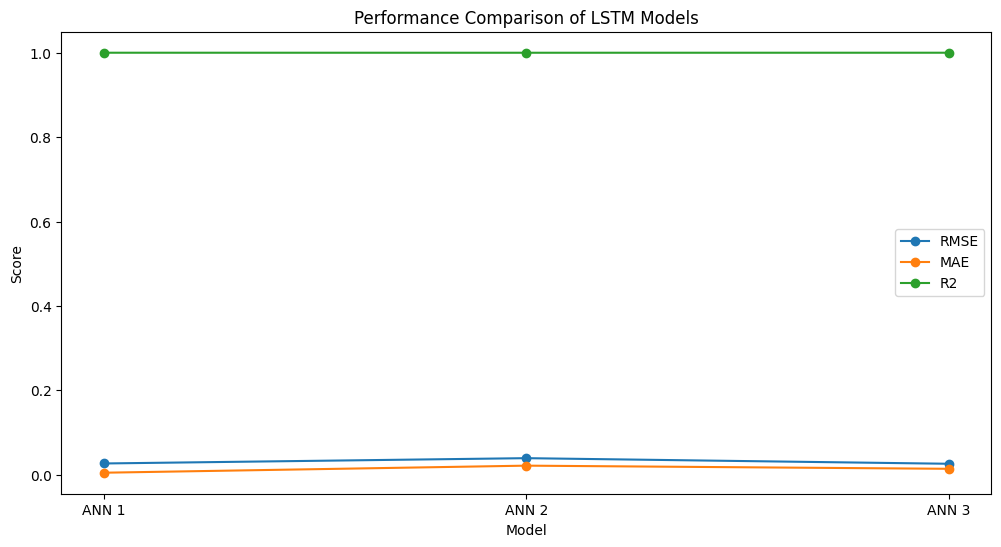

In [ ]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

# AUTUMN

In [ ]:
import pandas as pd
data_autumn = pd.read_csv('DATASET/SEASON/data_Autumn.csv')
data_autumn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6416 entries, 0 to 6415
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  6416 non-null   int64  
 1   city_name   6416 non-null   object 
 2   date        6416 non-null   object 
 3   season      6416 non-null   object 
 4   avg_temp_c  6228 non-null   float64
 5   min_temp_c  6181 non-null   float64
 6   max_temp_c  6416 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 351.0+ KB


In [ ]:
data_autumn

station_id city_name        date  season  avg_temp_c  min_temp_c  \
0          47662     Tokyo  1951-09-01  Autumn         NaN        22.5   
1          47662     Tokyo  1951-09-02  Autumn         NaN        21.5   
2          47662     Tokyo  1951-09-03  Autumn         NaN        18.6   
3          47662     Tokyo  1951-09-04  Autumn         NaN        19.5   
4          47662     Tokyo  1951-09-05  Autumn         NaN        20.5   
...          ...       ...         ...     ...         ...         ...   
6411       47662     Tokyo  2023-09-01  Autumn        28.9        26.2   
6412       47662     Tokyo  2023-09-02  Autumn        28.3        26.0   
6413       47662     Tokyo  2023-09-03  Autumn        26.8        25.0   
6414       47662     Tokyo  2023-09-04  Autumn        26.1        24.0   
6415       47662     Tokyo  2023-09-05  Autumn        25.6        23.7   

      max_temp_c  
0           30.4  
1           29.8  
2           30.3  
3           27.4  
4           24.7  
...          ...  
6411        32.1  
6412        31.3  
6413        29.2  
6414        28.7  
6415        28.1  

[6416 rows x 7 columns]

## PREDIKSI 1 HARI

### RNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_autumn  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1450894011.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1450894011.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6409, 7, 1)
Shape of y: (6409,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# RNN configurations based on the table provided
rnn_configs = [
    {'hidden_units': [3], 'epochs': 292},
    {'hidden_units': [17, 9], 'epochs': 123},
    {'hidden_units': [4, 4, 17], 'epochs': 92}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(rnn_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'RNN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/292
257/257 [==============================] - 2s 3ms/step - loss: 0.0277 - val_loss: 0.0153
Epoch 2/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0141
Epoch 3/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0135
Epoch 4/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0129 - val_loss: 0.0131
Epoch 5/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 6/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 7/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 8/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 9/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 10/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0121 - val_lo

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2
0  RNN 1          [3]     292  3.315120  2.583591  0.624021
1  RNN 2      [17, 9]     123  3.401514  2.646886  0.604169
2  RNN 3   [4, 4, 17]      92  5.424738  4.473649 -0.006753

In [ ]:
results_df.to_csv(f'HASIL/RNN_AUTUMN.csv', index=False)

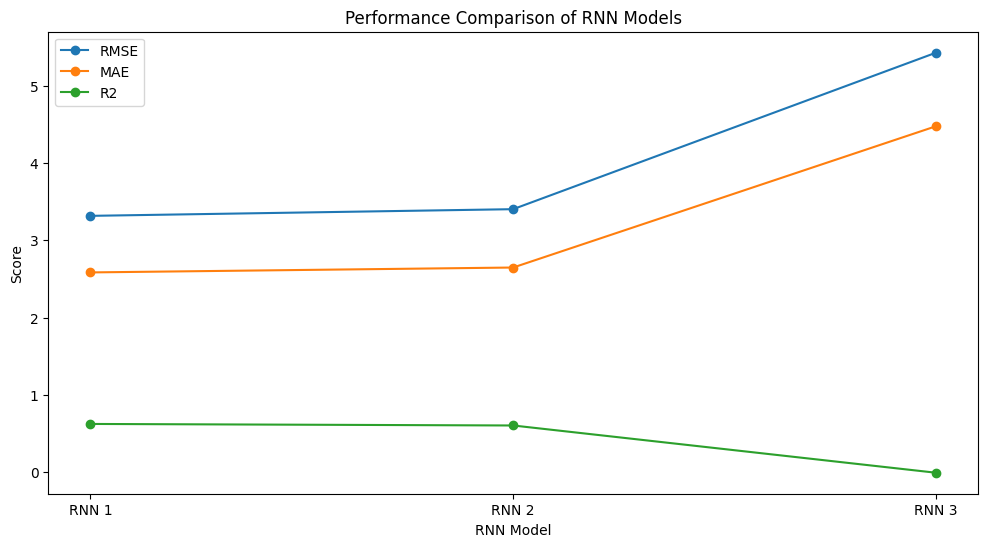

In [ ]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("RNN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of RNN Models")
plt.legend()
plt.show()

### LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
# Load data
data = data_autumn  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1450894011.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1450894011.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6409, 7, 1)
Shape of y: (6409,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# LSTM configurations based on the table provided
lstm_configs = [
    {'hidden_units': [14], 'epochs': 105},
    {'hidden_units': [15, 2], 'epochs': 229},
    {'hidden_units': [12, 7, 4], 'epochs': 111}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(lstm_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'LSTM {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/105
257/257 [==============================] - 2s 3ms/step - loss: 0.0230 - val_loss: 0.0135
Epoch 2/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0117
Epoch 3/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0120 - val_loss: 0.0111
Epoch 4/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0116 - val_loss: 0.0124
Epoch 5/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 6/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 7/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 8/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0112 - val_loss: 0.0110
Epoch 9/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0113 - val_loss: 0.0108
Epoch 10/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0112 - val_lo

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2
0  LSTM 1         [14]     105  0.102679  0.080306  0.623698
1  LSTM 2      [15, 2]     229  0.167504  0.138043 -0.001434
2  LSTM 3   [12, 7, 4]     111  0.103180  0.080619  0.620018

In [ ]:
results_df.to_csv(f'HASIL/LSTM_AUTUMN.csv', index=False)

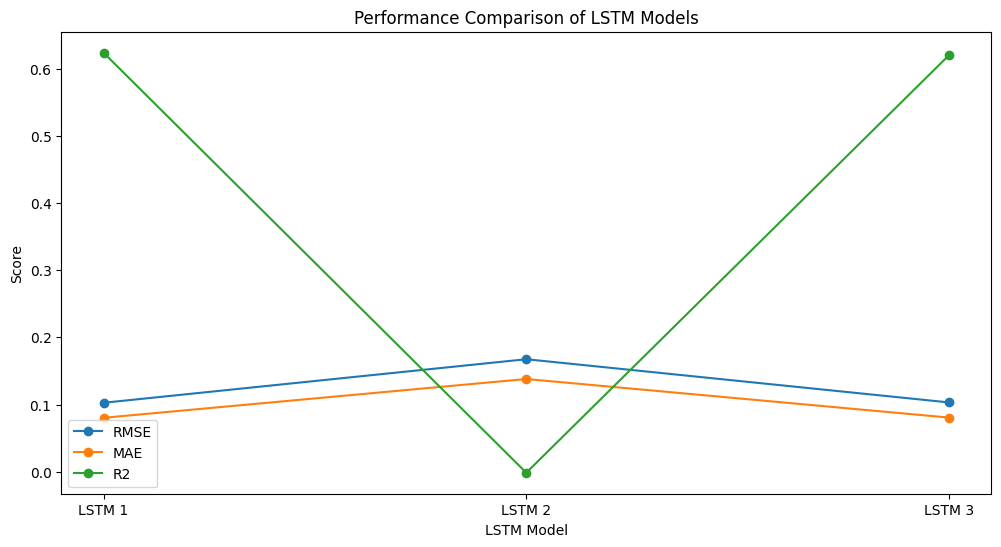

In [ ]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("LSTM Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_autumn  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1450894011.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1450894011.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6409, 7, 1)
Shape of y: (6409,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))

    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))

    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')

    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# ANN configurations based on the table provided
ann_configs = [
    {'hidden_units': [6], 'epochs': 104},
    {'hidden_units': [18, 2], 'epochs': 95},
    {'hidden_units': [7, 10, 18], 'epochs': 210}
]

In [ ]:
# Train and evaluate each configuration
results = []
for i, config in enumerate(ann_configs):
    rmse, mae, r2 = train_evaluate_ann_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'ANN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/104
257/257 [==============================] - 1s 2ms/step - loss: 0.1857 - val_loss: 0.0325
Epoch 2/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0208 - val_loss: 0.0197
Epoch 3/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0178 - val_loss: 0.0172
Epoch 4/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0161 - val_loss: 0.0157
Epoch 5/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 6/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 7/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.0134
Epoch 8/104
257/257 [==============================] - 0s 1ms/step - loss: 0.0134 - val_loss: 0.0129
Epoch 9/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 10/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0129 - val_lo

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2
0  ANN 1          [6]     104  0.103955  0.081107  0.614292
1  ANN 2      [18, 2]      95  0.101499  0.079426  0.632299
2  ANN 3  [7, 10, 18]     210  0.101362  0.078529  0.633290

In [ ]:
results_df.to_csv(f'HASIL/ANN_AUTUMN.csv', index=False)

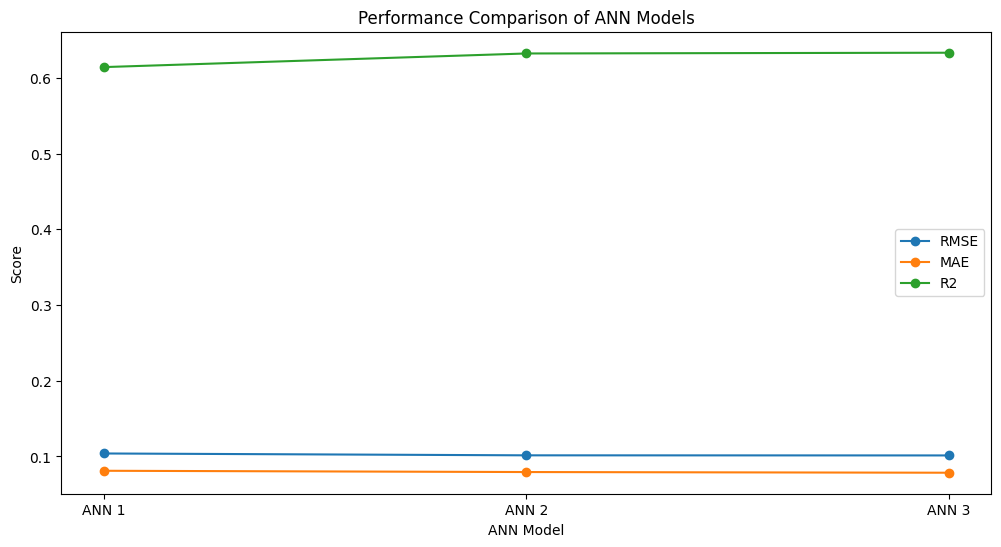

In [ ]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("ANN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of ANN Models")
plt.legend()
plt.show()

## PREDIKSI 15 HARI

### RNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Load data
data = data_autumn  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_87396\3573761752.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_87396\3573761752.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
def create_sequences(data, target, sequence_length=19, predict_days=15):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)

        # Simulate prediction for the next 15 days (lag of 19)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)

        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values

    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=19)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6397, 19, 1)
Shape of y: (6397,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2, model

In [ ]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Start with the last available sequence

    for _ in range(days):
        # Predict the next day (model expects input in 3D: batch_size, sequence_length, features)
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))  # Ensure it's 3D

        predictions.append(pred[0, 0])  # Append the scalar prediction value

        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)  # Add the predicted value to the sequence

        # Ensure the new sequence shape is correct for the next prediction
        current_input = current_input.reshape(-1, 1)  # Keep the sequence 2D for the next iteration

    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [ ]:
# Define list containing different configurations for evaluation purposes
rnn_configs = [
    {'hidden_units': [3], 'epochs': 292},
    {'hidden_units': [17, 9], 'epochs': 123},
    {'hidden_units': [4, 4, 17], 'epochs': 92}
]
results = []

# Train and evaluate each configuration
for i, config in enumerate(rnn_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])

    # Append evaluation results to the list
    results.append({
        'Model': f'RNN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)



Epoch 1/292

256/256 [==============================] - 3s 5ms/step - loss: 4.0459 - val_loss: 0.3461
Epoch 2/292
256/256 [==============================] - 1s 3ms/step - loss: 0.1541 - val_loss: 0.0760
Epoch 3/292
256/256 [==============================] - 1s 4ms/step - loss: 0.0540 - val_loss: 0.0369
Epoch 4/292
256/256 [==============================] - 1s 3ms/step - loss: 0.0278 - val_loss: 0.0206
Epoch 5/292
256/256 [==============================] - 1s 3ms/step - loss: 0.0164 - val_loss: 0.0129
Epoch 6/292
256/256 [==============================] - 1s 3ms/step - loss: 0.0097 - val_loss: 0.0070
Epoch 7/292
256/256 [==============================] - 1s 4ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 8/292
256/256 [==============================] - 1s 4ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 9/292
256/256 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 7.9825e-04
Epoch 10/292
256/256 [==============================] - 1s 3ms/step - loss: 6.0599e-0

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2  \
0  RNN 1          [3]     292  0.001859  0.000094  1.000000   
1  RNN 2      [17, 9]     123  0.012233  0.008875  0.999994   
2  RNN 3   [4, 4, 17]      92  0.012877  0.006826  0.999993   

                                        Model_Object  
0  <keras.src.engine.sequential.Sequential object...  
1  <keras.src.engine.sequential.Sequential object...  
2  <keras.src.engine.sequential.Sequential object...

In [ ]:
results_df.to_csv(f'HASIL/15_RNN_AUTUMN.csv', index=False)

In [ ]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model              RNN 1
Hidden Units         [3]
Epochs               292
RMSE            0.001859
MAE             0.000094
R2                   1.0
Name: 0, dtype: object
1/1 [==============================] - 0s 27ms/step

Predictions for the next 15 days using the best model:
[18.400013 18.400024 18.400024 18.400028 18.40003  18.400034 18.400038
 18.40004  18.400043 18.400045 18.400051 18.400053 18.400055 18.400059
 18.400063]


In [ ]:
predictions_rescaled

array([[18.400013],
       [18.400024],
       [18.400024],
       [18.400028],
       [18.40003 ],
       [18.400034],
       [18.400038],
       [18.40004 ],
       [18.400043],
       [18.400045],
       [18.400051],
       [18.400053],
       [18.400055],
       [18.400059],
       [18.400063]], dtype=float32)

In [ ]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [ ]:
df_predictions

Predicted_Value
0         18.400013
1         18.400024
2         18.400024
3         18.400028
4         18.400030
5         18.400034
6         18.400038
7         18.400040
8         18.400043
9         18.400045
10        18.400051
11        18.400053
12        18.400055
13        18.400059
14        18.400063

In [ ]:
df_predictions.to_csv(f'HASIL_PREDICT/15_RNN_AUTUMN.csv', index=False)

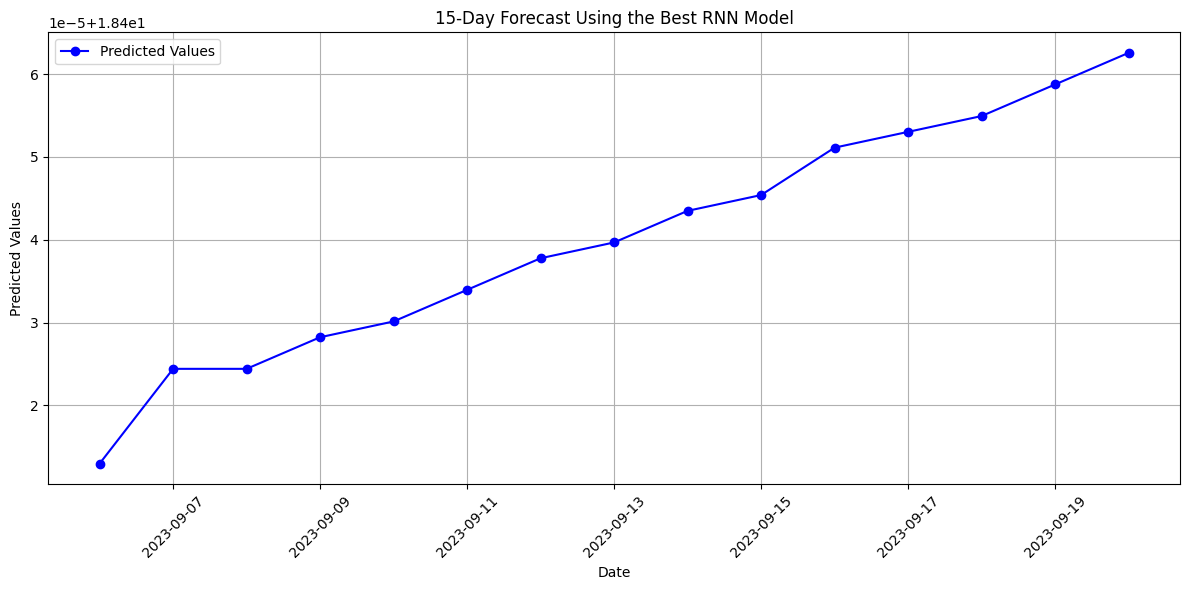

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_autumn['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best RNN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

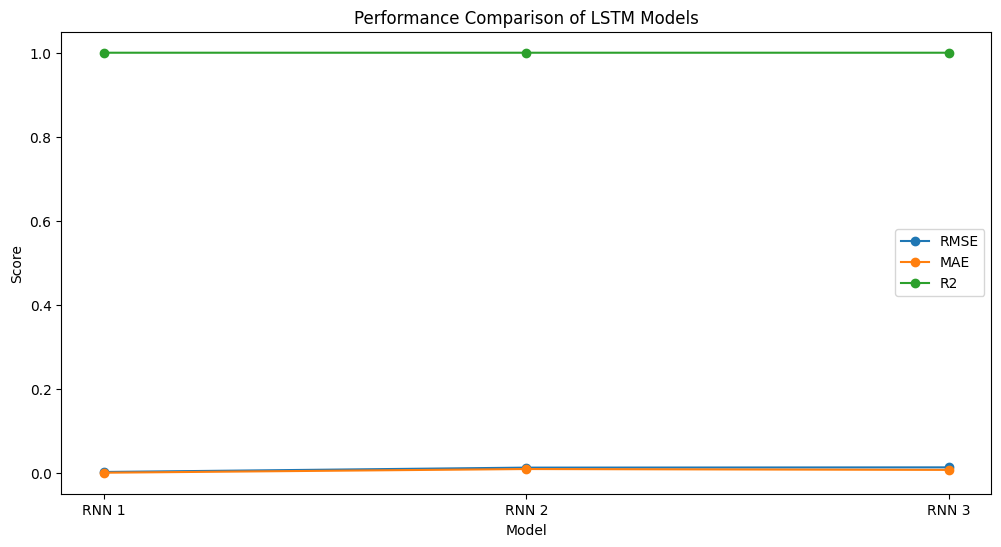

In [ ]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Load data
data = data_autumn  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_106408\3573761752.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_106408\3573761752.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
def create_sequences(data, target, sequence_length=19, predict_days=15):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)

        # Simulate prediction for the next 15 days (lag of 19)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)

        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values

    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=19)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6397, 19, 1)
Shape of y: (6397,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))

    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    # Return RMSE, MAE, R2, and model
    return rmse, mae, r2, model


In [ ]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Start with the last available sequence

    for _ in range(days):
        # Predict the next day (model expects input in 3D: batch_size, sequence_length, features)
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))  # Ensure it's 3D

        predictions.append(pred[0, 0])  # Append the scalar prediction value

        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)  # Add the predicted value to the sequence

        # Ensure the new sequence shape is correct for the next prediction
        current_input = current_input.reshape(-1, 1)  # Keep the sequence 2D for the next iteration

    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [ ]:
# Define list containing different configurations for evaluation purposes
lstm_configs = [
    {'hidden_units': [14], 'epochs': 105},
    {'hidden_units': [15, 2], 'epochs': 229},
    {'hidden_units': [12, 7, 4], 'epochs': 111}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(lstm_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_lstm_model(config['hidden_units'], config['epochs'])

    # Append evaluation results to the list
    results.append({
        'Model': f'LSTM {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)



Epoch 1/105

256/256 [==============================] - 3s 6ms/step - loss: 0.0275 - val_loss: 0.0077
Epoch 2/105
256/256 [==============================] - 1s 6ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 3/105
256/256 [==============================] - 2s 6ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 4/105
256/256 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 5/105
256/256 [==============================] - 2s 6ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/105
256/256 [==============================] - 2s 7ms/step - loss: 0.0010 - val_loss: 8.5603e-04
Epoch 7/105
256/256 [==============================] - 2s 7ms/step - loss: 7.4172e-04 - val_loss: 6.2587e-04
Epoch 8/105
256/256 [==============================] - 1s 5ms/step - loss: 5.7802e-04 - val_loss: 4.9251e-04
Epoch 9/105
256/256 [==============================] - 1s 5ms/step - loss: 4.7824e-04 - val_loss: 4.4768e-04
Epoch 10/105
256/256 [==============================] - 1s 5m

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2  \
0  LSTM 1         [14]     105  0.052179  0.037459  0.999890   
1  LSTM 2      [15, 2]     229  4.967232  4.060854 -0.000740   
2  LSTM 3   [12, 7, 4]     111  0.069072  0.059382  0.999806   

                                        Model_Object  
0  <keras.src.engine.sequential.Sequential object...  
1  <keras.src.engine.sequential.Sequential object...  
2  <keras.src.engine.sequential.Sequential object...

In [ ]:
results_df.to_csv(f'HASIL/15_LSTM_AUTUMN.csv', index=False)

In [ ]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model             LSTM 1
Hidden Units        [14]
Epochs               105
RMSE            0.052179
MAE             0.037459
R2               0.99989
Name: 0, dtype: object
1/1 [==============================] - 0s 22ms/step

Predictions for the next 15 days using the best model:
[18.422108 18.408241 18.405516 18.398153 18.386354 18.377562 18.367886
 18.358088 18.348429 18.33773  18.327497 18.318295 18.307022 18.298115
 18.286901]


In [ ]:
predictions_rescaled

array([[18.422108],
       [18.408241],
       [18.405516],
       [18.398153],
       [18.386354],
       [18.377562],
       [18.367886],
       [18.358088],
       [18.348429],
       [18.33773 ],
       [18.327497],
       [18.318295],
       [18.307022],
       [18.298115],
       [18.286901]], dtype=float32)

In [ ]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [ ]:
df_predictions

Predicted_Value
0         18.422108
1         18.408241
2         18.405516
3         18.398153
4         18.386354
5         18.377562
6         18.367886
7         18.358088
8         18.348429
9         18.337730
10        18.327497
11        18.318295
12        18.307022
13        18.298115
14        18.286901

In [ ]:
df_predictions.to_csv(f'HASIL_PREDICT/15_LSTM_AUTUMN.csv', index=False)

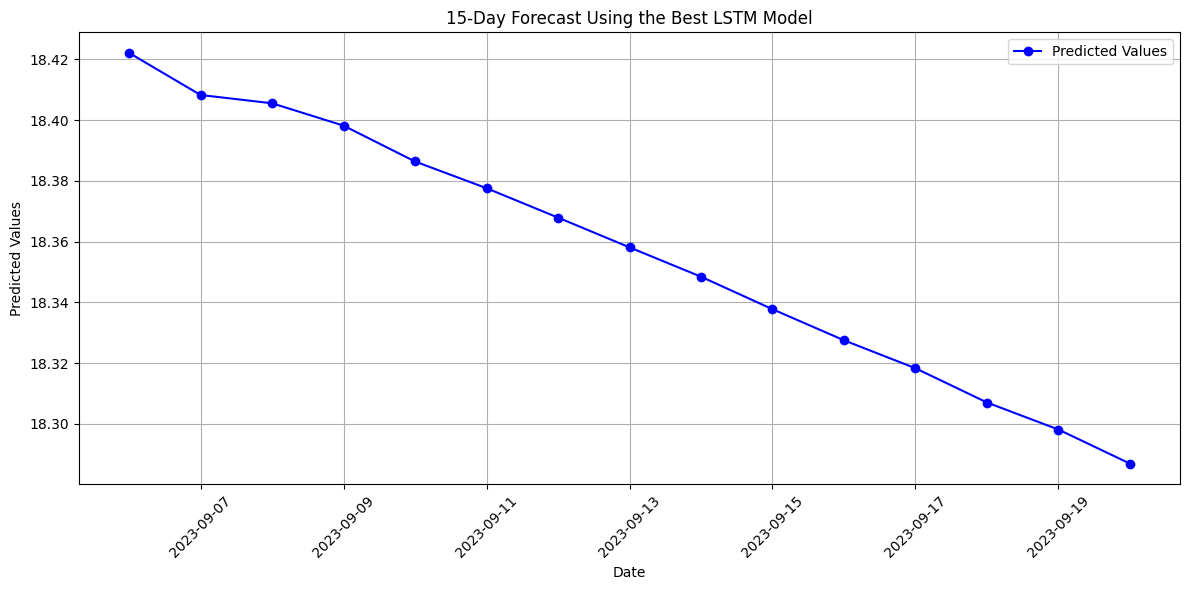

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_autumn['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best LSTM Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

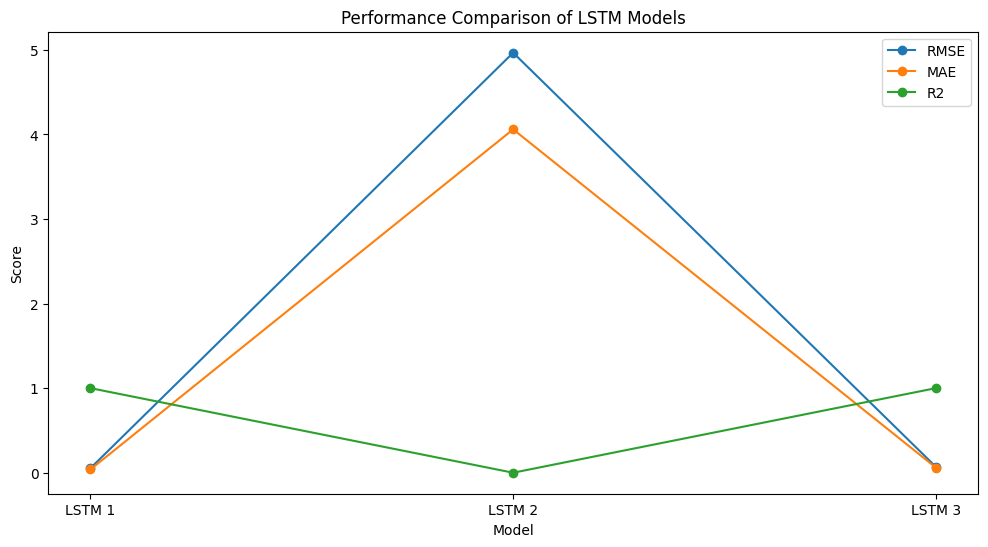

In [ ]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Load data
data = data_autumn  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_93928\3573761752.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_93928\3573761752.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
def create_sequences(data, target, sequence_length=25, predict_days=15):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)

        # Simulate prediction for the next 15 days (lag of 25)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)

        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values

    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=25)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6391, 25, 1)
Shape of y: (6391,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))

    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))

    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')

    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2, model

In [ ]:
last_sequence = X_test[-1].reshape(1, -1)

In [ ]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence.flatten()  # Flatten the sequence to match the training input

    for _ in range(days):
        # Predict the next day using the flattened input
        pred = model.predict(current_input.reshape(1, -1))  # Ensure it's 2D as expected by the model

        predictions.append(pred[0, 0])  # Append the scalar prediction value

        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)  # Keep sequence 1D to match the model input

    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled


In [ ]:
# Define list containing different configurations for evaluation purposes
ann_configs = [
    {'hidden_units': [6], 'epochs': 104},
    {'hidden_units': [18, 2], 'epochs': 95},
    {'hidden_units': [7, 10, 18], 'epochs': 210}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(ann_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_ann_model(config['hidden_units'], config['epochs'])

    # Append evaluation results to the list
    results.append({
        'Model': f'ANN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)



Epoch 1/104

256/256 [==============================] - 1s 3ms/step - loss: 0.1004 - val_loss: 0.0209
Epoch 2/104
256/256 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0167
Epoch 3/104
256/256 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0121
Epoch 4/104
256/256 [==============================] - 1s 2ms/step - loss: 0.0100 - val_loss: 0.0081
Epoch 5/104
256/256 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 6/104
256/256 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 7/104
256/256 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 8/104
256/256 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 9/104
256/256 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 10/104
256/256 [==============================] - 1s 2ms/step - loss: 0.0011 - val_

In [ ]:
results_df

Model Hidden Units  Epochs      RMSE       MAE        R2  \
0  ANN 1          [6]     104  0.016856  0.007462  0.999990   
1  ANN 2      [18, 2]      95  0.012213  0.006871  0.999995   
2  ANN 3  [7, 10, 18]     210  0.049739  0.007797  0.999909   

                                        Model_Object  
0  <keras.src.engine.sequential.Sequential object...  
1  <keras.src.engine.sequential.Sequential object...  
2  <keras.src.engine.sequential.Sequential object...

In [ ]:
results_df.to_csv(f'HASIL/15_ANN_AUTUMN.csv', index=False)

In [ ]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model              ANN 2
Hidden Units     [18, 2]
Epochs                95
RMSE            0.012213
MAE             0.006871
R2              0.999995
Name: 1, dtype: object
1/1 [==============================] - 0s 26ms/step

Predictions for the next 15 days using the best model:
[29.311092 30.267143 29.790794 30.031881 29.916449 29.975605 29.94057
 29.945448 29.936916 29.935322 29.925358 29.921745 29.919437 29.914797
 29.910011]


In [ ]:
predictions_rescaled

array([[29.311092],
       [30.267143],
       [29.790794],
       [30.031881],
       [29.916449],
       [29.975605],
       [29.94057 ],
       [29.945448],
       [29.936916],
       [29.935322],
       [29.925358],
       [29.921745],
       [29.919437],
       [29.914797],
       [29.910011]], dtype=float32)

In [ ]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [ ]:
df_predictions

Predicted_Value
0         29.311092
1         30.267143
2         29.790794
3         30.031881
4         29.916449
5         29.975605
6         29.940571
7         29.945448
8         29.936916
9         29.935322
10        29.925358
11        29.921745
12        29.919437
13        29.914797
14        29.910011

In [ ]:
df_predictions.to_csv(f'HASIL_PREDICT/15_ANN_AUTUMN.csv', index=False)

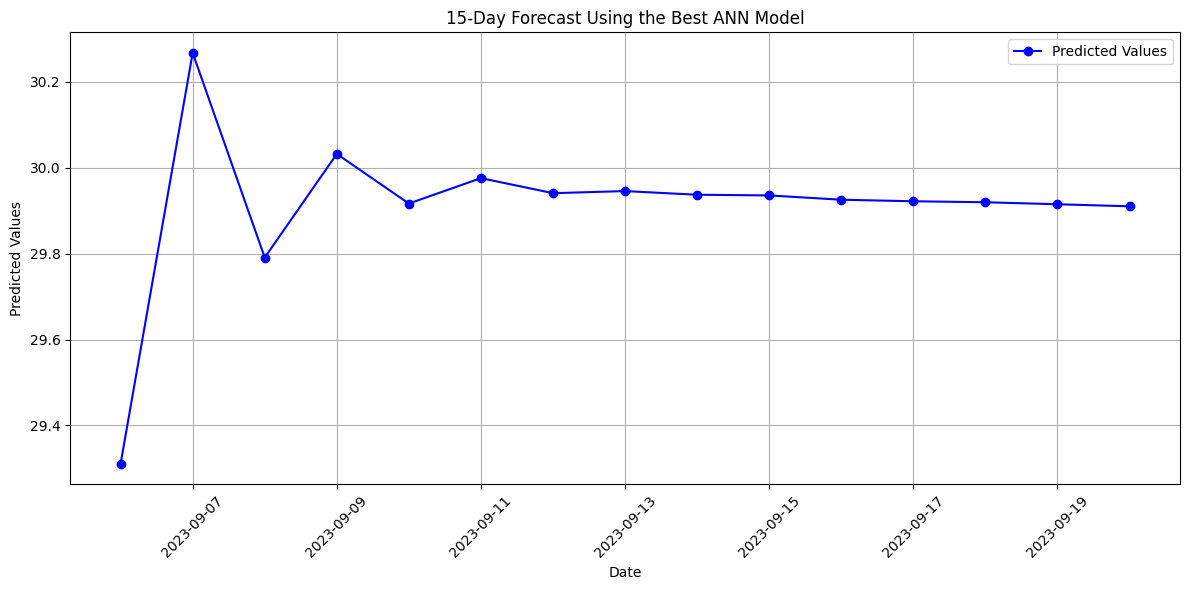

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_autumn['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best ANN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

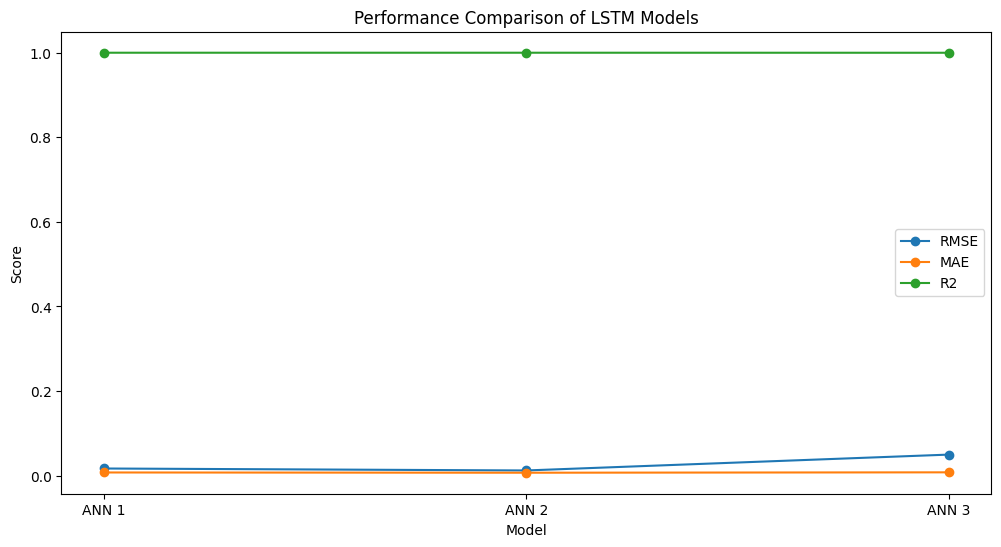

In [ ]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

Average day-to-day change in predictions: 0.13738741
Standard deviation of day-to-day changes in predictions: 0.29176253

Day-to-day changes for each predicted day:
    Day  Day-to-Day Change
0     1           0.956051
1     2          -0.476349
2     3           0.241087
3     4          -0.115433
4     5           0.059156
5     6          -0.035034
6     7           0.004877
7     8          -0.008532
8     9          -0.001595
9    10          -0.009964
10   11          -0.003613
11   12          -0.002308
12   13          -0.004641
13   14          -0.004786


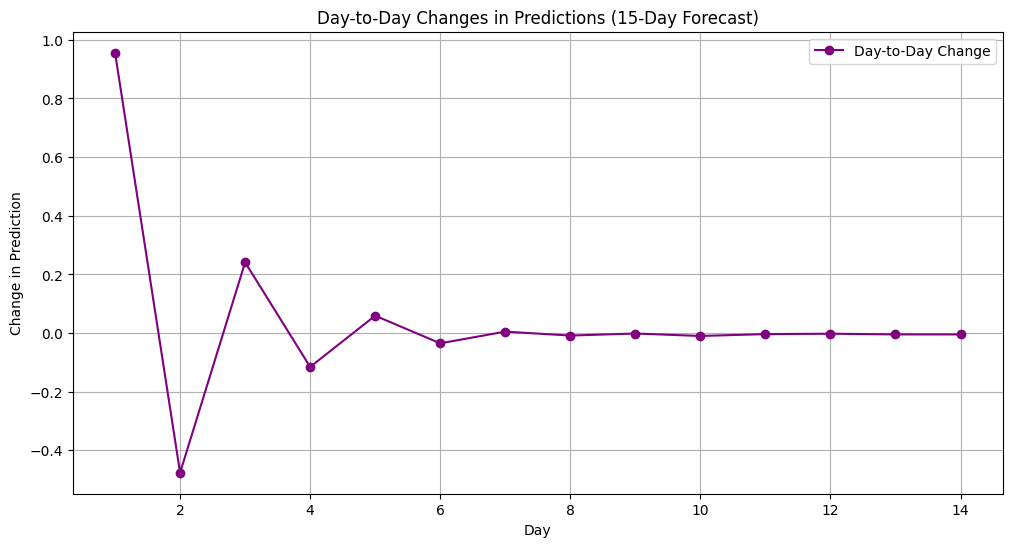

In [ ]:
# Calculate differences between consecutive predictions
predicted_differences = np.diff(predictions_rescaled.flatten())

# Convert to DataFrame for better readability
df_predicted_differences = pd.DataFrame({
    'Day': range(1, 15),  # We have 14 differences for 15 predictions
    'Day-to-Day Change': predicted_differences
})

# Calculate statistics on the changes to understand prediction stability
avg_day_to_day_change = np.mean(np.abs(predicted_differences))
std_day_to_day_change = np.std(predicted_differences)

print("Average day-to-day change in predictions:", avg_day_to_day_change)
print("Standard deviation of day-to-day changes in predictions:", std_day_to_day_change)
print("\nDay-to-day changes for each predicted day:")
print(df_predicted_differences)

# Plot day-to-day changes
plt.figure(figsize=(12, 6))
plt.plot(df_predicted_differences['Day'], df_predicted_differences['Day-to-Day Change'], marker='o', color='purple', label='Day-to-Day Change')
plt.xlabel('Day')
plt.ylabel('Change in Prediction')
plt.title('Day-to-Day Changes in Predictions (15-Day Forecast)')
plt.legend()
plt.grid(True)
plt.show()

# WINTER COMBINATION

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
data_winter = pd.read_csv('DATASET/SEASON/data_Winter.csv')

In [ ]:
data_winter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6419 entries, 0 to 6418
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  6419 non-null   int64  
 1   city_name   6419 non-null   object 
 2   date        6419 non-null   object 
 3   season      6419 non-null   object 
 4   avg_temp_c  6181 non-null   float64
 5   min_temp_c  6142 non-null   float64
 6   max_temp_c  6419 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 351.2+ KB


In [ ]:
data_winter

station_id city_name        date  season  avg_temp_c  min_temp_c  \
0          47662     Tokyo  1951-01-01  Winter         NaN        -3.6   
1          47662     Tokyo  1951-01-02  Winter         NaN        -1.4   
2          47662     Tokyo  1951-01-03  Winter         NaN        -2.2   
3          47662     Tokyo  1951-01-04  Winter         NaN        -1.4   
4          47662     Tokyo  1951-01-05  Winter         NaN        -3.3   
...          ...       ...         ...     ...         ...         ...   
6414       47662     Tokyo  2023-02-24  Winter         8.9         6.2   
6415       47662     Tokyo  2023-02-25  Winter         7.7         4.3   
6416       47662     Tokyo  2023-02-26  Winter         5.9         2.1   
6417       47662     Tokyo  2023-02-27  Winter         8.5         3.7   
6418       47662     Tokyo  2023-02-28  Winter        11.5         3.8   

      max_temp_c  
0            7.0  
1            8.2  
2            8.1  
3            9.2  
4            9.7  
...          ...  
6414        11.9  
6415        11.7  
6416        10.1  
6417        13.9  
6418        18.5  

[6419 rows x 7 columns]

## KOMBINASI OPTIMIZER + ACTIVATION

### RNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_winter  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6412, 7, 1)
Shape of y: (6412,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Define multiple activations and optimizers to try
activations = ['tanh', 'relu', 'sigmoid']
optimizers = [Adam, SGD, RMSprop]

# Updated function to train and evaluate with specified activation and optimizer
def train_evaluate_rnn_model(hidden_units, epochs, activation, optimizer):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation=activation, return_sequences=(i < len(hidden_units) - 1)))

    model.add(Dense(1))
    model.compile(optimizer=optimizer(), loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=0)

    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# RNN configurations based on the table provided
rnn_configs = [
    {'hidden_units': [11], 'epochs': 50},
    {'hidden_units': [4, 5], 'epochs': 263},
    {'hidden_units': [5, 7, 3], 'epochs': 92}
]

# Iterate through configurations with different activation functions and optimizers
results = []
for i, config in enumerate(rnn_configs):
    for activation in activations:
        for opt in optimizers:
            rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'], activation, opt)
            results.append({
                'Model': f'RNN {i+1}',
                'Hidden Units': config['hidden_units'],
                'Epochs': config['epochs'],
                'Activation': activation,
                'Optimizer': opt.__name__,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
    Model Hidden Units  Epochs Activation Optimizer      RMSE       MAE  \
0   RNN 1         [11]      50       tanh      Adam  2.889025  2.246990   
1   RNN 1         [11]      50       tanh       SGD  2.908172  2.292939   
2   RNN 1         [11]      50       tanh   RMSprop  2.963285  2.275728   
3   RNN 1         [11]      50       relu      Adam  2.914684  2.303447   
4   RNN 1         [11]      50       relu       SGD  2.935204  2.309230   
5   RNN 1         [11]      50       relu   RMSprop  2.885492  2.245910   
6   RNN 1         [11]      50    sigmoid      Adam  2.909293  2.295563   
7   RNN 1         [11]      50    sigmoid       SGD  2.962939  2.334918   
8   RNN 1         [11]      50    sigmoid   RMSprop  2.908314  2.286878   
9   RNN 2       [4, 5]     263       tanh      Adam  2.882907  2.245607   
10  RNN 2       [4, 5]     263       tanh       SGD  2.904226  2.294583   
11  RNN 2       [4, 5]     263       tanh   RMSprop  2.911391

In [ ]:
results_df

Model Hidden Units  Epochs Activation Optimizer      RMSE       MAE  \
0   RNN 1         [11]      50       tanh      Adam  2.889025  2.246990   
1   RNN 1         [11]      50       tanh       SGD  2.908172  2.292939   
2   RNN 1         [11]      50       tanh   RMSprop  2.963285  2.275728   
3   RNN 1         [11]      50       relu      Adam  2.914684  2.303447   
4   RNN 1         [11]      50       relu       SGD  2.935204  2.309230   
5   RNN 1         [11]      50       relu   RMSprop  2.885492  2.245910   
6   RNN 1         [11]      50    sigmoid      Adam  2.909293  2.295563   
7   RNN 1         [11]      50    sigmoid       SGD  2.962939  2.334918   
8   RNN 1         [11]      50    sigmoid   RMSprop  2.908314  2.286878   
9   RNN 2       [4, 5]     263       tanh      Adam  2.882907  2.245607   
10  RNN 2       [4, 5]     263       tanh       SGD  2.904226  2.294583   
11  RNN 2       [4, 5]     263       tanh   RMSprop  2.911391  2.296197   
12  RNN 2       [4, 5]     263       relu      Adam  2.907010  2.292918   
13  RNN 2       [4, 5]     263       relu       SGD  2.885408  2.260038   
14  RNN 2       [4, 5]     263       relu   RMSprop  2.894682  2.279880   
15  RNN 2       [4, 5]     263    sigmoid      Adam  2.885417  2.260921   
16  RNN 2       [4, 5]     263    sigmoid       SGD  3.004122  2.370028   
17  RNN 2       [4, 5]     263    sigmoid   RMSprop  2.885337  2.244117   
18  RNN 3    [5, 7, 3]      92       tanh      Adam  2.902314  2.292771   
19  RNN 3    [5, 7, 3]      92       tanh       SGD  2.936174  2.337395   
20  RNN 3    [5, 7, 3]      92       tanh   RMSprop  2.912900  2.296627   
21  RNN 3    [5, 7, 3]      92       relu      Adam  2.921680  2.310620   
22  RNN 3    [5, 7, 3]      92       relu       SGD  3.378255  2.696412   
23  RNN 3    [5, 7, 3]      92       relu   RMSprop  2.886372  2.264518   
24  RNN 3    [5, 7, 3]      92    sigmoid      Adam  2.888080  2.245273   
25  RNN 3    [5, 7, 3]      92    sigmoid       SGD  3.382646  2.705200   
26  RNN 3    [5, 7, 3]      92    sigmoid   RMSprop  2.887228  2.255957   

          R2  
0   0.265648  
1   0.255882  
2   0.227411  
3   0.252545  
4   0.241984  
5   0.267442  
6   0.255308  
7   0.227591  
8   0.255809  
9   0.268754  
10  0.257899  
11  0.254233  
12  0.256476  
13  0.267485  
14  0.262769  
15  0.267480  
16  0.205969  
17  0.267521  
18  0.258876  
19  0.241482  
20  0.253460  
21  0.248953  
22 -0.004123  
23  0.266995  
24  0.266128  
25 -0.006735  
26  0.266561

In [ ]:
# Save the best result and the full results to CSV
results_df.to_csv('HASIL_GS/RNN_WINTER_all_results.csv', index=False)

In [ ]:
# Find the best result based on RMSE
best_result = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Model Configuration:", best_result)

Best Model Configuration: Model              RNN 2
Hidden Units      [4, 5]
Epochs               263
Activation          tanh
Optimizer           Adam
RMSE            2.882907
MAE             2.245607
R2              0.268754
Name: 9, dtype: object


In [ ]:
# Save only the best configuration
best_result.to_frame().T.to_csv('HASIL_GS/RNN_WINTER_best_result.csv', index=False)

### LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
# Load data
data = data_winter  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6412, 7, 1)
Shape of y: (6412,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Define different activations and optimizers to test
activations = ['tanh', 'relu', 'sigmoid']
optimizers = [Adam, SGD, RMSprop]

def train_evaluate_lstm_model(hidden_units, epochs, activation, optimizer_class):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(LSTM(units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(LSTM(units, activation=activation, return_sequences=(i < len(hidden_units) - 1)))
    model.add(Dense(1))

    # Instantiate the optimizer class
    optimizer_instance = optimizer_class()
    model.compile(optimizer=optimizer_instance, loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Make predictions and inverse transform the results
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# Configurations for different LSTM models
lstm_configs = [
    {'hidden_units': [10], 'epochs': 20},
    {'hidden_units': [12, 4], 'epochs': 91},
    {'hidden_units': [11, 11, 1], 'epochs': 98}
]

# Store results
results = []
for i, config in enumerate(lstm_configs):
    for activation in activations:
        for optimizer in optimizers:
            rmse, mae, r2 = train_evaluate_lstm_model(config['hidden_units'], config['epochs'], activation, optimizer)
            results.append({
                'Model': f'LSTM {i+1}',
                'Hidden Units': config['hidden_units'],
                'Epochs': config['epochs'],
                'Activation': activation,
                'Optimizer': optimizer.__name__,  # Corrected to get class name
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)


Epoch 1/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0369 - val_loss: 0.0137
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0140 - val_loss: 0.0134
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0139 - val_loss: 0.0132
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0135 - val_loss: 0.0130
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0145 - val_loss: 0.0130
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - val_loss: 0.0132
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.0128
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0133 - val_loss: 0.0127
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0135 - val_loss: 0.0127
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0134 - val_loss: 0.0126
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0306 - val_loss: 0.0143
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0141 - val_loss: 0.0142
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0144 - val_loss: 0.0141
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - val_loss: 0.0139
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0142 - val_loss: 0.0138
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0141
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0144 - val_loss: 0.0137
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0134 - val_loss: 0.0136
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 0.0135
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0318 - val_loss: 0.0143
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0139 - val_loss: 0.0132
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0143 - val_loss: 0.0131
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0143 - val_loss: 0.0129
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0143 - val_loss: 0.0128
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0139 - val_loss: 0.0129
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0132
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0137 - val_loss: 0.0126
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0139 - val_loss: 0.0126
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0135 - val_loss: 0.0128
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1227 - val_loss: 0.0153
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0149 - val_loss: 0.0146
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0142 - val_loss: 0.0136
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0140 - val_loss: 0.0133
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0141 - val_loss: 0.0132
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.0131
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0138 - val_loss: 0.0128
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_loss: 0.0128
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0134 - val_loss: 0.0126
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0134 - val_loss: 0.0126
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0461 - val_loss: 0.0155
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.0153
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_loss: 0.0152
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_loss: 0.0151
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0155 - val_loss: 0.0147
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0146
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0448 - val_loss: 0.0138
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0140 - val_loss: 0.0133
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0133
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - val_loss: 0.0131
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0134 - val_loss: 0.0131
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0138 - val_loss: 0.0129
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0140 - val_loss: 0.0129
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0139 - val_loss: 0.0129
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0135 - val_loss: 0.0128
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0133 - val_loss: 0.0127
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1578 - val_loss: 0.0166
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0157 - val_loss: 0.0164
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 0.0160
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0153 - val_loss: 0.0157
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147 - val_loss: 0.0153
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0159 - val_loss: 0.0149
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0150
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0139
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0135 - val_loss: 0.0136
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1617 - val_loss: 0.0176
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0172 - val_loss: 0.0176
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0166 - val_loss: 0.0176
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0176
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0166 - val_loss: 0.0175
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0168 - val_loss: 0.0174
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - val_loss: 0.0174
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0166 - val_loss: 0.0175
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0176 - val_loss: 0.0173
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - val_loss: 0.0172
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0166 - val_loss: 0.0173
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2188 - val_loss: 0.0155
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 0.0147
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - val_loss: 0.0147
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0134 - val_loss: 0.0138
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0136 - val_loss: 0.0138
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0136 - val_loss: 0.0137
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0135 - val_loss: 0.0133
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0130 - val_loss: 0.0132
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0135 - val_loss: 0.0130
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0130
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0131 - val_loss: 0.0129
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0573 - val_loss: 0.0148
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0150 - val_loss: 0.0144
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0150 - val_loss: 0.0142
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0142 - val_loss: 0.0143
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0137
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0129
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0140 - val_loss: 0.0128
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0135 - val_loss: 0.0131
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131 - val_loss: 0.0127
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0134 - val_loss: 0.0129
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0704 - val_loss: 0.0179
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0172 - val_loss: 0.0178
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0164 - val_loss: 0.0178
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0173 - val_loss: 0.0177
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0173 - val_loss: 0.0177
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0169 - val_loss: 0.0176
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0180 - val_loss: 0.0176
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0169 - val_loss: 0.0176
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0175 - val_loss: 0.0176
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0165 - val_loss: 0.0175
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0166 - val_loss: 0.0174
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0376 - val_loss: 0.0147
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0148 - val_loss: 0.0142
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0139 - val_loss: 0.0141
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0147 - val_loss: 0.0142
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0153 - val_loss: 0.0137
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0143 - val_loss: 0.0136
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0141 - val_loss: 0.0137
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0142 - val_loss: 0.0137
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1027 - val_loss: 0.0146
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0152 - val_loss: 0.0142
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0144 - val_loss: 0.0138
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0139 - val_loss: 0.0137
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0149 - val_loss: 0.0133
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0145 - val_loss: 0.0132
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0144 - val_loss: 0.0129
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0141 - val_loss: 0.0130
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0133 - val_loss: 0.0129
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0139 - val_loss: 0.0128
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0139 - val_loss: 0.0127
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0762 - val_loss: 0.0178
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0173 - val_loss: 0.0178
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0179 - val_loss: 0.0177
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0176 - val_loss: 0.0177
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0178 - val_loss: 0.0177
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0174 - val_loss: 0.0178
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0172 - val_loss: 0.0177
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0178 - val_loss: 0.0177
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0174 - val_loss: 0.0177
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0171 - val_loss: 0.0177
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0161 - val_loss: 0.0177
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0953 - val_loss: 0.0152
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0157 - val_loss: 0.0148
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0153 - val_loss: 0.0146
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0154 - val_loss: 0.0144
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0149 - val_loss: 0.0143
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0147 - val_loss: 0.0145
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0142 - val_loss: 0.0139
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0148 - val_loss: 0.0143
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0143 - val_loss: 0.0135
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0142 - val_loss: 0.0134
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138 - val_loss: 0.0134
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4940 - val_loss: 0.1028
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0782 - val_loss: 0.0355
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0297 - val_loss: 0.0196
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0182 - val_loss: 0.0177
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0176 - val_loss: 0.0177
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0179 - val_loss: 0.0177
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0171 - val_loss: 0.0177
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0168 - val_loss: 0.0177
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0172 - val_loss: 0.0177
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0170 - val_loss: 0.0177
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0170 - val_loss: 0.0177
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0812 - val_loss: 0.0177
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0175 - val_loss: 0.0177
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0162 - val_loss: 0.0177
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0175 - val_loss: 0.0177
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0163 - val_loss: 0.0177
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0171 - val_loss: 0.0177
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0171 - val_loss: 0.0178
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0172 - val_loss: 0.0177
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0177 - val_loss: 0.0177
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0178 - val_loss: 0.0177
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1729 - val_loss: 0.0176
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0174 - val_loss: 0.0177
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0174 - val_loss: 0.0175
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0174 - val_loss: 0.0175
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0166 - val_loss: 0.0176
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0172 - val_loss: 0.0176
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0172 - val_loss: 0.0173
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0165 - val_loss: 0.0172
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0163 - val_loss: 0.0171
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0165 - val_loss: 0.0172
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0723 - val_loss: 0.0159
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0159 - val_loss: 0.0155
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0155 - val_loss: 0.0156
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0158 - val_loss: 0.0149
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0154 - val_loss: 0.0147
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0145 - val_loss: 0.0146
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0150 - val_loss: 0.0141
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0148 - val_loss: 0.0141
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0147 - val_loss: 0.0136
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0143 - val_loss: 0.0132
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss:

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0601 - val_loss: 0.0175
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0167 - val_loss: 0.0175
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0169 - val_loss: 0.0175
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0178 - val_loss: 0.0174
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0179 - val_loss: 0.0174
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0168 - val_loss: 0.0175
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0166 - val_loss: 0.0174
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0172 - val_loss: 0.0174
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0162 - val_loss: 0.0174
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0167 - val_loss: 0.0174
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0170 - val_loss: 0.0174
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0235 - val_loss: 0.0153
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0158 - val_loss: 0.0162
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0158 - val_loss: 0.0150
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0150 - val_loss: 0.0149
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0154 - val_loss: 0.0151
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0152 - val_loss: 0.0164
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0150 - val_loss: 0.0144
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0153 - val_loss: 0.0151
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0152 - val_loss: 0.0139
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.1642 - val_loss: 0.0663
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0523 - val_loss: 0.0252
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0216 - val_loss: 0.0184
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0185 - val_loss: 0.0178
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0170 - val_loss: 0.0177
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0173 - val_loss: 0.0177
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0167 - val_loss: 0.0177
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0171 - val_loss: 0.0177
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0162 - val_loss: 0.0177
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0173 - val_loss: 0.0177
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0723 - val_loss: 0.0178
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0176 - val_loss: 0.0177
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0171 - val_loss: 0.0177
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0174 - val_loss: 0.0177
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0175 - val_loss: 0.0177
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0172 - val_loss: 0.0177
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0176 - val_loss: 0.0177
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0170 - val_loss: 0.0177
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0168 - val_loss: 0.0177
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1555 - val_loss: 0.0513
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0336 - val_loss: 0.0177
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0172 - val_loss: 0.0177
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0171 - val_loss: 0.0177
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0170 - val_loss: 0.0177
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0176 - val_loss: 0.0177
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0174 - val_loss: 0.0177
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0266 - val_loss: 0.0177
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0169 - val_loss: 0.0176
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0181 - val_loss: 0.0177
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0170 - val_loss: 0.0175
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0173 - val_loss: 0.0175
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0160 - val_loss: 0.0174
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0167 - val_loss: 0.0175
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0163 - val_loss: 0.0171
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0166 - val_loss: 0.0169
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0156 - val_loss: 0.0162
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0228 - val_loss: 0.0177
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0164 - val_loss: 0.0177
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0171 - val_loss: 0.0177
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0166 - val_loss: 0.0177
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0167 - val_loss: 0.0177
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0176 - val_loss: 0.0177
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0171 - val_loss: 0.0177
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0172 - val_loss: 0.0177
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0176 - val_loss: 0.0177
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0686 - val_loss: 0.0178
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0171 - val_loss: 0.0177
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0170 - val_loss: 0.0177
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0173 - val_loss: 0.0178
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0173 - val_loss: 0.0177
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0165 - val_loss: 0.0179
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0167 - val_loss: 0.0177
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0173 - val_loss: 0.0177
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0173 - val_loss: 0.0177
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

In [ ]:
results_df

Model Hidden Units  Epochs Activation Optimizer      RMSE       MAE  \
0   LSTM 1         [10]      20       tanh      Adam  2.894734  2.276046   
1   LSTM 1         [10]      20       tanh       SGD  2.954286  2.322871   
2   LSTM 1         [10]      20       tanh   RMSprop  2.886425  2.252383   
3   LSTM 1         [10]      20       relu      Adam  2.905782  2.248098   
4   LSTM 1         [10]      20       relu       SGD  3.031959  2.400662   
5   LSTM 1         [10]      20       relu   RMSprop  2.891082  2.254984   
6   LSTM 1         [10]      20    sigmoid      Adam  2.894213  2.249700   
7   LSTM 1         [10]      20    sigmoid       SGD  3.292863  2.622391   
8   LSTM 1         [10]      20    sigmoid   RMSprop  2.900078  2.281033   
9   LSTM 2      [12, 4]      91       tanh      Adam  2.901184  2.275513   
10  LSTM 2      [12, 4]      91       tanh       SGD  3.075684  2.417446   
11  LSTM 2      [12, 4]      91       tanh   RMSprop  2.938039  2.332126   
12  LSTM 2      [12, 4]      91       relu      Adam  2.917616  2.304516   
13  LSTM 2      [12, 4]      91       relu       SGD  3.296473  2.619244   
14  LSTM 2      [12, 4]      91       relu   RMSprop  2.882910  2.249399   
15  LSTM 2      [12, 4]      91    sigmoid      Adam  2.887145  2.244893   
16  LSTM 2      [12, 4]      91    sigmoid       SGD  3.369199  2.680556   
17  LSTM 2      [12, 4]      91    sigmoid   RMSprop  2.892254  2.242080   
18  LSTM 3  [11, 11, 1]      98       tanh      Adam  2.914677  2.303313   
19  LSTM 3  [11, 11, 1]      98       tanh       SGD  3.232040  2.555227   
20  LSTM 3  [11, 11, 1]      98       tanh   RMSprop  2.941545  2.258788   
21  LSTM 3  [11, 11, 1]      98       relu      Adam  3.371668  2.677392   
22  LSTM 3  [11, 11, 1]      98       relu       SGD  3.371636  2.677134   
23  LSTM 3  [11, 11, 1]      98       relu   RMSprop  3.373561  2.662564   
24  LSTM 3  [11, 11, 1]      98    sigmoid      Adam  2.882290  2.251179   
25  LSTM 3  [11, 11, 1]      98    sigmoid       SGD  3.372002  2.680356   
26  LSTM 3  [11, 11, 1]      98    sigmoid   RMSprop  2.911162  2.246842   

          R2  
0   0.262742  
1   0.232096  
2   0.266968  
3   0.257104  
4   0.191186  
5   0.264601  
6   0.263007  
7   0.045998  
8   0.260018  
9   0.259453  
10  0.167689  
11  0.240518  
12  0.251041  
13  0.043905  
14  0.268753  
15  0.266603  
16  0.001253  
17  0.264005  
18  0.252549  
19  0.080915  
20  0.238705  
21 -0.000211  
22 -0.000192  
23 -0.001335  
24  0.269067  
25 -0.000409  
26  0.254350

In [ ]:
results_df.to_csv(f'HASIL_GS/LSTM_WINTER_all_results.csv', index=False)

In [ ]:
# Find the best result based on RMSE
best_result = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Model Configuration:", best_result)

Best Model Configuration: Model                LSTM 3
Hidden Units    [11, 11, 1]
Epochs                   98
Activation          sigmoid
Optimizer              Adam
RMSE                2.88229
MAE                2.251179
R2                 0.269067
Name: 24, dtype: object


In [ ]:
# Save only the best configuration
best_result.to_frame().T.to_csv('HASIL_GS/LSTM_WINTER_best_result.csv', index=False)

### ANN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_winter  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6412, 7, 1)
Shape of y: (6412,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an ANN model

from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Define different activations and optimizers to test
activations = ['tanh', 'relu', 'sigmoid']
optimizers = [Adam, SGD, RMSprop]

def train_evaluate_ann_model(hidden_units, epochs, activation, optimizer):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation=activation, input_shape=(X_train.shape[1] * X_train.shape[2],)))

    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation=activation))

    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=optimizer, loss='mse')

    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# ANN configurations based on the table provided
ann_configs = [
    {'hidden_units': [8], 'epochs': 161},
    {'hidden_units': [4, 16], 'epochs': 193},
    {'hidden_units': [3, 10, 12], 'epochs': 285}
]

In [ ]:
# Store results
results = []
for i, config in enumerate(ann_configs):
    for activation in activations:
        for optimizer_class in optimizers:
            optimizer = optimizer_class()  # Instantiate optimizer here
            rmse, mae, r2 = train_evaluate_ann_model(config['hidden_units'], config['epochs'], activation, optimizer)
            results.append({
                'Model': f'ANN {i+1}',
                'Hidden Units': config['hidden_units'],
                'Epochs': config['epochs'],
                'Activation': activation,
                'Optimizer': optimizer_class.__name__,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0224 - val_loss: 0.0152
Epoch 2/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.0153 - val_loss: 0.0134
Epoch 3/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0140 - val_loss: 0.0128
Epoch 4/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142 - val_loss: 0.0126
Epoch 5/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.0131 - val_loss: 0.0126
Epoch 6/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 0.0131 - val_loss: 0.0129
Epoch 7/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 8/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 - val_loss: 0.0127
Epoch 9/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0126
Epoch 10/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 - val_loss: 0.0131
Epoch 11/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.0129 - val_loss: 0.0127
Epoch 12/161
257/257 ━━━━━━━━━━━

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0468 - val_loss: 0.0312
Epoch 2/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0335 - val_loss: 0.0264
Epoch 3/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0275 - val_loss: 0.0234
Epoch 4/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0248 - val_loss: 0.0213
Epoch 5/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0227 - val_loss: 0.0207
Epoch 6/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0220 - val_loss: 0.0186
Epoch 7/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0195 - val_loss: 0.0177
Epoch 8/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0198 - val_loss: 0.0171
Epoch 9/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.0183 - val_loss: 0.0166
Epoch 10/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173 - val_loss: 0.0161
Epoch 11/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0172 - val_loss: 0.0157
Epoch 12/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0652 - val_loss: 0.0164
Epoch 2/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167 - val_loss: 0.0134
Epoch 3/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0146 - val_loss: 0.0135
Epoch 4/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 - val_loss: 0.0127
Epoch 5/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0126
Epoch 6/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 7/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0139 - val_loss: 0.0131
Epoch 8/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 9/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 10/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141 - val_loss: 0.0130
Epoch 11/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.0134 - val_loss: 0.0129
Epoch 12/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0445 - val_loss: 0.0165
Epoch 2/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0180 - val_loss: 0.0154
Epoch 3/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0163 - val_loss: 0.0143
Epoch 4/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0157 - val_loss: 0.0136
Epoch 5/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0132
Epoch 6/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0148 - val_loss: 0.0132
Epoch 7/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0140 - val_loss: 0.0129
Epoch 8/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0138 - val_loss: 0.0128
Epoch 9/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 - val_loss: 0.0126
Epoch 10/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 11/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0130 - val_loss: 0.0126
Epoch 12/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0264 - val_loss: 0.0176
Epoch 2/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0179 - val_loss: 0.0164
Epoch 3/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0175 - val_loss: 0.0156
Epoch 4/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0156 - val_loss: 0.0150
Epoch 5/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0146
Epoch 6/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 7/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 8/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0148 - val_loss: 0.0138
Epoch 9/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0139 - val_loss: 0.0136
Epoch 10/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 11/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 - val_loss: 0.0134
Epoch 12/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0964 - val_loss: 0.0143
Epoch 2/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0150 - val_loss: 0.0142
Epoch 3/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0148 - val_loss: 0.0136
Epoch 4/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141 - val_loss: 0.0134
Epoch 5/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141 - val_loss: 0.0133
Epoch 6/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0138 - val_loss: 0.0132
Epoch 7/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0142 - val_loss: 0.0131
Epoch 8/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0140 - val_loss: 0.0131
Epoch 9/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - val_loss: 0.0130
Epoch 10/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - val_loss: 0.0130
Epoch 11/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144 - val_loss: 0.0132
Epoch 12/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1647 - val_loss: 0.0489
Epoch 2/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0288 - val_loss: 0.0145
Epoch 3/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0144
Epoch 4/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0147 - val_loss: 0.0143
Epoch 5/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0147 - val_loss: 0.0142
Epoch 6/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0142
Epoch 7/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0141
Epoch 8/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0145 - val_loss: 0.0140
Epoch 9/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0139
Epoch 10/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144 - val_loss: 0.0138
Epoch 11/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141 - val_loss: 0.0137
Epoch 12/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2662 - val_loss: 0.0184
Epoch 2/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0186 - val_loss: 0.0182
Epoch 3/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170 - val_loss: 0.0181
Epoch 4/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0182 - val_loss: 0.0180
Epoch 5/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0172 - val_loss: 0.0178
Epoch 6/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0178 - val_loss: 0.0176
Epoch 7/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173 - val_loss: 0.0175
Epoch 8/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0177 - val_loss: 0.0174
Epoch 9/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170 - val_loss: 0.0173
Epoch 10/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0163 - val_loss: 0.0171
Epoch 11/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 12/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0269 - val_loss: 0.0168
Epoch 2/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165 - val_loss: 0.0152
Epoch 3/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160 - val_loss: 0.0143
Epoch 4/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0146 - val_loss: 0.0138
Epoch 5/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0151 - val_loss: 0.0134
Epoch 6/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0138 - val_loss: 0.0130
Epoch 7/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0128
Epoch 8/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141 - val_loss: 0.0127
Epoch 9/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 - val_loss: 0.0127
Epoch 10/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - val_loss: 0.0128
Epoch 11/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0134 - val_loss: 0.0130
Epoch 12/161
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0600 - val_loss: 0.0136
Epoch 2/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0145 - val_loss: 0.0132
Epoch 3/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 4/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0140 - val_loss: 0.0132
Epoch 5/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0131 - val_loss: 0.0128
Epoch 6/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0129 - val_loss: 0.0127
Epoch 7/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 8/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0130 - val_loss: 0.0126
Epoch 9/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - val_loss: 0.0127
Epoch 10/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 11/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 12/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0177 - val_loss: 0.0161
Epoch 2/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0156 - val_loss: 0.0162
Epoch 3/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 4/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0156 - val_loss: 0.0155
Epoch 5/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 6/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 7/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 8/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 9/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0155 - val_loss: 0.0151
Epoch 10/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0145 - val_loss: 0.0151
Epoch 11/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0147 - val_loss: 0.0151
Epoch 12/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5647 - val_loss: 0.0149
Epoch 2/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0147 - val_loss: 0.0140
Epoch 3/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 - val_loss: 0.0128
Epoch 4/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0142 - val_loss: 0.0128
Epoch 5/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 6/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 - val_loss: 0.0128
Epoch 7/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141 - val_loss: 0.0126
Epoch 8/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0140 - val_loss: 0.0133
Epoch 9/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141 - val_loss: 0.0143
Epoch 10/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 - val_loss: 0.0128
Epoch 11/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 - val_loss: 0.0126
Epoch 12/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0445 - val_loss: 0.0138
Epoch 2/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144 - val_loss: 0.0130
Epoch 3/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - val_loss: 0.0129
Epoch 4/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - val_loss: 0.0127
Epoch 5/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - val_loss: 0.0127
Epoch 6/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0126
Epoch 7/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0131 - val_loss: 0.0127
Epoch 8/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - val_loss: 0.0129
Epoch 9/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 - val_loss: 0.0127
Epoch 10/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0131 - val_loss: 0.0127
Epoch 11/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 - val_loss: 0.0126
Epoch 12/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0305 - val_loss: 0.0161
Epoch 2/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168 - val_loss: 0.0158
Epoch 3/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 4/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0153 - val_loss: 0.0155
Epoch 5/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0157 - val_loss: 0.0156
Epoch 6/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 7/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0159 - val_loss: 0.0152
Epoch 8/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 9/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - val_loss: 0.0150
Epoch 10/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156 - val_loss: 0.0149
Epoch 11/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - val_loss: 0.0149
Epoch 12/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1361 - val_loss: 0.0177
Epoch 2/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173 - val_loss: 0.0171
Epoch 3/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 0.0161 - val_loss: 0.0166
Epoch 4/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 5/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 6/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 0.0150 - val_loss: 0.0149
Epoch 7/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 0.0148 - val_loss: 0.0148
Epoch 8/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 0.0146 - val_loss: 0.0142
Epoch 9/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 0.0144 - val_loss: 0.0144
Epoch 10/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 0.0147 - val_loss: 0.0140
Epoch 11/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 12/193
257/257 ━━━━━━━━━━━━━━━━━━━━

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 2/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167 - val_loss: 0.0173
Epoch 3/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0174 - val_loss: 0.0170
Epoch 4/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0161 - val_loss: 0.0170
Epoch 5/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0155 - val_loss: 0.0159
Epoch 6/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0152 - val_loss: 0.0156
Epoch 7/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.0156 - val_loss: 0.0150
Epoch 8/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0156 - val_loss: 0.0148
Epoch 9/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.0152 - val_loss: 0.0144
Epoch 10/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 0.0145 - val_loss: 0.0141
Epoch 11/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0145 - val_loss: 0.0138
Epoch 12/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0637 - val_loss: 0.0185
Epoch 2/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 0.0182 - val_loss: 0.0185
Epoch 3/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 0.0180 - val_loss: 0.0184
Epoch 4/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 0.0180 - val_loss: 0.0186
Epoch 5/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 0.0177 - val_loss: 0.0183
Epoch 6/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 0.0171 - val_loss: 0.0184
Epoch 7/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 0.0186 - val_loss: 0.0183
Epoch 8/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.0175 - val_loss: 0.0183
Epoch 9/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0177 - val_loss: 0.0183
Epoch 10/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170 - val_loss: 0.0184
Epoch 11/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 0.0183 - val_loss: 0.0182
Epoch 12/193
257/257 ━━━━━━━━━━━━━━

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2867 - val_loss: 0.0180
Epoch 2/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0166 - val_loss: 0.0170
Epoch 3/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174 - val_loss: 0.0167
Epoch 4/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.0157 - val_loss: 0.0158
Epoch 5/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 6/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0159 - val_loss: 0.0147
Epoch 7/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 8/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - val_loss: 0.0139
Epoch 9/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0145 - val_loss: 0.0140
Epoch 10/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - val_loss: 0.0137
Epoch 11/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0142 - val_loss: 0.0132
Epoch 12/193
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0229 - val_loss: 0.0157
Epoch 2/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0147 - val_loss: 0.0138
Epoch 3/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142 - val_loss: 0.0137
Epoch 4/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 - val_loss: 0.0133
Epoch 5/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 6/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 7/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 - val_loss: 0.0130
Epoch 8/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0142 - val_loss: 0.0136
Epoch 9/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 10/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0139 - val_loss: 0.0128
Epoch 11/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 12/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0348 - val_loss: 0.0209
Epoch 2/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0199 - val_loss: 0.0167
Epoch 3/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - val_loss: 0.0152
Epoch 4/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0147 - val_loss: 0.0146
Epoch 5/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0142 - val_loss: 0.0142
Epoch 6/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144 - val_loss: 0.0140
Epoch 7/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141 - val_loss: 0.0138
Epoch 8/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0139 - val_loss: 0.0138
Epoch 9/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 10/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 11/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0138 - val_loss: 0.0135
Epoch 12/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0342 - val_loss: 0.0148
Epoch 2/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0150 - val_loss: 0.0146
Epoch 3/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0156 - val_loss: 0.0141
Epoch 4/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144 - val_loss: 0.0134
Epoch 5/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0142 - val_loss: 0.0146
Epoch 6/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0139 - val_loss: 0.0137
Epoch 7/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144 - val_loss: 0.0143
Epoch 8/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - val_loss: 0.0155
Epoch 9/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138 - val_loss: 0.0131
Epoch 10/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 - val_loss: 0.0131
Epoch 11/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0138 - val_loss: 0.0130
Epoch 12/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0726 - val_loss: 0.0143
Epoch 2/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0142
Epoch 3/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0149 - val_loss: 0.0140
Epoch 4/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - val_loss: 0.0138
Epoch 5/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 - val_loss: 0.0139
Epoch 6/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 7/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0140 - val_loss: 0.0133
Epoch 8/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0144 - val_loss: 0.0132
Epoch 9/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0135 - val_loss: 0.0130
Epoch 10/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0133 - val_loss: 0.0131
Epoch 11/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0133 - val_loss: 0.0130
Epoch 12/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0370 - val_loss: 0.0151
Epoch 2/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0148 - val_loss: 0.0151
Epoch 3/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0150
Epoch 4/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0149
Epoch 5/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0150 - val_loss: 0.0148
Epoch 6/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 7/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0143 - val_loss: 0.0147
Epoch 8/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0143 - val_loss: 0.0147
Epoch 9/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 10/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 11/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0144
Epoch 12/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0515 - val_loss: 0.0158
Epoch 2/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163 - val_loss: 0.0158
Epoch 3/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 4/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - val_loss: 0.0149
Epoch 5/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 6/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 7/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0138
Epoch 8/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0135
Epoch 9/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 10/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0133
Epoch 11/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - val_loss: 0.0133
Epoch 12/285
257/257 ━━━━━━━━━━━━━━━━━━━━

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0462 - val_loss: 0.0177
Epoch 2/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0172 - val_loss: 0.0177
Epoch 3/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169 - val_loss: 0.0175
Epoch 4/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170 - val_loss: 0.0174
Epoch 5/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166 - val_loss: 0.0173
Epoch 6/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166 - val_loss: 0.0172
Epoch 7/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167 - val_loss: 0.0175
Epoch 8/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - val_loss: 0.0179
Epoch 9/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170 - val_loss: 0.0166
Epoch 10/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0163 - val_loss: 0.0161
Epoch 11/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0163 - val_loss: 0.0157
Epoch 12/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0616 - val_loss: 0.0177
Epoch 2/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174 - val_loss: 0.0178
Epoch 3/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - val_loss: 0.0177
Epoch 4/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0179 - val_loss: 0.0177
Epoch 5/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171 - val_loss: 0.0178
Epoch 6/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174 - val_loss: 0.0177
Epoch 7/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171 - val_loss: 0.0179
Epoch 8/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169 - val_loss: 0.0177
Epoch 9/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0161 - val_loss: 0.0177
Epoch 10/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - val_loss: 0.0177
Epoch 11/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - val_loss: 0.0178
Epoch 12/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0218 - val_loss: 0.0175
Epoch 2/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0172 - val_loss: 0.0185
Epoch 3/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 4/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - val_loss: 0.0172
Epoch 5/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 6/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0162 - val_loss: 0.0168
Epoch 7/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0159 - val_loss: 0.0167
Epoch 8/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170 - val_loss: 0.0166
Epoch 9/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0163 - val_loss: 0.0162
Epoch 10/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0160
Epoch 11/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 12/285
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [ ]:
results_df

Model Hidden Units  Epochs Activation Optimizer      RMSE       MAE  \
0   ANN 1          [8]     161       tanh      Adam  2.895049  2.247974   
1   ANN 1          [8]     161       tanh       SGD  2.904311  2.284807   
2   ANN 1          [8]     161       tanh   RMSprop  2.894062  2.247642   
3   ANN 1          [8]     161       relu      Adam  2.918641  2.266150   
4   ANN 1          [8]     161       relu       SGD  2.893480  2.268762   
5   ANN 1          [8]     161       relu   RMSprop  2.925393  2.318358   
6   ANN 1          [8]     161    sigmoid      Adam  2.892622  2.271026   
7   ANN 1          [8]     161    sigmoid       SGD  2.901219  2.270059   
8   ANN 1          [8]     161    sigmoid   RMSprop  2.886261  2.254185   
9   ANN 2      [4, 16]     193       tanh      Adam  2.893263  2.257473   
10  ANN 2      [4, 16]     193       tanh       SGD  2.910287  2.290730   
11  ANN 2      [4, 16]     193       tanh   RMSprop  2.913830  2.257734   
12  ANN 2      [4, 16]     193       relu      Adam  2.898697  2.273261   
13  ANN 2      [4, 16]     193       relu       SGD  2.886009  2.252576   
14  ANN 2      [4, 16]     193       relu   RMSprop  2.901091  2.249456   
15  ANN 2      [4, 16]     193    sigmoid      Adam  2.922911  2.313879   
16  ANN 2      [4, 16]     193    sigmoid       SGD  3.165504  2.478862   
17  ANN 2      [4, 16]     193    sigmoid   RMSprop  2.898141  2.280409   
18  ANN 3  [3, 10, 12]     285       tanh      Adam  2.903214  2.280339   
19  ANN 3  [3, 10, 12]     285       tanh       SGD  2.889211  2.268203   
20  ANN 3  [3, 10, 12]     285       tanh   RMSprop  2.894715  2.258338   
21  ANN 3  [3, 10, 12]     285       relu      Adam  2.887069  2.257926   
22  ANN 3  [3, 10, 12]     285       relu       SGD  2.908124  2.295015   
23  ANN 3  [3, 10, 12]     285       relu   RMSprop  2.898217  2.249266   
24  ANN 3  [3, 10, 12]     285    sigmoid      Adam  2.908382  2.295714   
25  ANN 3  [3, 10, 12]     285    sigmoid       SGD  3.330832  2.654549   
26  ANN 3  [3, 10, 12]     285    sigmoid   RMSprop  2.889058  2.264587   

          R2  
0   0.262582  
1   0.257856  
2   0.263084  
3   0.250514  
4   0.263381  
5   0.247042  
6   0.263818  
7   0.259435  
8   0.267052  
9   0.263491  
10  0.254798  
11  0.252983  
12  0.260722  
13  0.267180  
14  0.259501  
15  0.248319  
16  0.118367  
17  0.261006  
18  0.258416  
19  0.265553  
20  0.262752  
21  0.266642  
22  0.255906  
23  0.260967  
24  0.255774  
25  0.023871  
26  0.265631

In [ ]:
results_df.to_csv(f'HASIL_GS/ANN_WINTER_all_results.csv', index=False)

In [ ]:
# Find the best result based on RMSE
best_result = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Model Configuration:", best_result)

Best Model Configuration: Model              ANN 2
Hidden Units     [4, 16]
Epochs               193
Activation          relu
Optimizer            SGD
RMSE            2.886009
MAE             2.252576
R2               0.26718
Name: 13, dtype: object


In [ ]:
# Save only the best configuration
best_result.to_frame().T.to_csv('HASIL_GS/ANN_WINTER_best_result.csv', index=False)

# SPRING COMBINATION

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
data_spring = pd.read_csv('DATASET/SEASON/data_Spring.csv')

In [ ]:
data_spring.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6568 entries, 0 to 6567
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  6568 non-null   int64  
 1   city_name   6568 non-null   object 
 2   date        6568 non-null   object 
 3   season      6568 non-null   object 
 4   avg_temp_c  6361 non-null   float64
 5   min_temp_c  6330 non-null   float64
 6   max_temp_c  6568 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 359.3+ KB


In [ ]:
data_spring

station_id city_name        date  season  avg_temp_c  min_temp_c  \
0          47662     Tokyo  1951-03-01  Spring         NaN         6.5   
1          47662     Tokyo  1951-03-02  Spring         NaN         5.6   
2          47662     Tokyo  1951-03-03  Spring         NaN         2.5   
3          47662     Tokyo  1951-03-04  Spring         NaN        -0.4   
4          47662     Tokyo  1951-03-05  Spring         NaN        -1.1   
...          ...       ...         ...     ...         ...         ...   
6563       47662     Tokyo  2023-05-27  Spring        21.1        16.9   
6564       47662     Tokyo  2023-05-28  Spring        21.5        18.6   
6565       47662     Tokyo  2023-05-29  Spring        20.0        19.0   
6566       47662     Tokyo  2023-05-30  Spring        21.2        18.8   
6567       47662     Tokyo  2023-05-31  Spring        19.1        17.0   

      max_temp_c  
0           15.0  
1           11.3  
2            8.2  
3            9.0  
4            9.2  
...          ...  
6563        26.0  
6564        24.4  
6565        21.5  
6566        24.9  
6567        21.7  

[6568 rows x 7 columns]

## KOMBINASI OPTIMIZER + ACTIVATION

### RNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_spring  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6561, 7, 1)
Shape of y: (6561,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Define multiple activations and optimizers to try
activations = ['tanh', 'relu', 'sigmoid']
optimizers = [Adam, SGD, RMSprop]

# Updated function to train and evaluate with specified activation and optimizer
def train_evaluate_rnn_model(hidden_units, epochs, activation, optimizer):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation=activation, return_sequences=(i < len(hidden_units) - 1)))

    model.add(Dense(1))
    model.compile(optimizer=optimizer(), loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# RNN configurations based on the table provided
rnn_configs = [
    {'hidden_units': [11], 'epochs': 50},
    {'hidden_units': [4, 5], 'epochs': 263},
    {'hidden_units': [5, 7, 3], 'epochs': 92}
]

# Iterate through configurations with different activation functions and optimizers
results = []
for i, config in enumerate(rnn_configs):
    for activation in activations:
        for opt in optimizers:
            rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'], activation, opt)
            results.append({
                'Model': f'RNN {i+1}',
                'Hidden Units': config['hidden_units'],
                'Epochs': config['epochs'],
                'Activation': activation,
                'Optimizer': opt.__name__,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0379 - val_loss: 0.0212
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0206 - val_loss: 0.0171
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - val_loss: 0.0157
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - val_loss: 0.0159
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156 - val_loss: 0.0162
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - val_loss: 0.0143
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0147 - val_loss: 0.0154
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0144
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0145 - val_loss: 0.0141
Epoch 10/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 11/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0148 - val_loss: 0.0140
Epoch 12/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0343 - val_loss: 0.0172
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0172 - val_loss: 0.0156
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0146
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 - val_loss: 0.0148
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - val_loss: 0.0153
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0150 - val_loss: 0.0147
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0145 - val_loss: 0.0148
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0141
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0156 - val_loss: 0.0143
Epoch 10/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0149 - val_loss: 0.0142
Epoch 11/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0147 - val_loss: 0.0141
Epoch 12/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0248 - val_loss: 0.0145
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - val_loss: 0.0161
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - val_loss: 0.0143
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - val_loss: 0.0142
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0166
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - val_loss: 0.0156
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0156 - val_loss: 0.0143
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0138
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0144 - val_loss: 0.0141
Epoch 10/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0148 - val_loss: 0.0141
Epoch 11/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0147 - val_loss: 0.0146
Epoch 12/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0891 - val_loss: 0.0151
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0155 - val_loss: 0.0148
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0148 - val_loss: 0.0144
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152 - val_loss: 0.0144
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - val_loss: 0.0142
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - val_loss: 0.0140
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0146 - val_loss: 0.0139
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0152 - val_loss: 0.0139
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0151 - val_loss: 0.0140
Epoch 10/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - val_loss: 0.0143
Epoch 11/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0149 - val_loss: 0.0138
Epoch 12/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0204 - val_loss: 0.0166
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173 - val_loss: 0.0158
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168 - val_loss: 0.0149
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0164 - val_loss: 0.0147
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0154 - val_loss: 0.0147
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0144
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0164 - val_loss: 0.0144
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0151 - val_loss: 0.0144
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - val_loss: 0.0142
Epoch 10/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0151 - val_loss: 0.0142
Epoch 11/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0142
Epoch 12/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0942 - val_loss: 0.0153
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0154 - val_loss: 0.0148
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0142
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147 - val_loss: 0.0143
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0147 - val_loss: 0.0138
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144 - val_loss: 0.0143
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 10/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0138
Epoch 11/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0156 - val_loss: 0.0139
Epoch 12/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0529 - val_loss: 0.0286
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281 - val_loss: 0.0238
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0224 - val_loss: 0.0189
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0188 - val_loss: 0.0160
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0166 - val_loss: 0.0152
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0149 - val_loss: 0.0145
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150 - val_loss: 0.0144
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 - val_loss: 0.0141
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0152 - val_loss: 0.0142
Epoch 10/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0153 - val_loss: 0.0142
Epoch 11/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0142
Epoch 12/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0812 - val_loss: 0.0317
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0312 - val_loss: 0.0306
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0312 - val_loss: 0.0297
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0293 - val_loss: 0.0290
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0299 - val_loss: 0.0282
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0284 - val_loss: 0.0275
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0276 - val_loss: 0.0266
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0276 - val_loss: 0.0260
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0261 - val_loss: 0.0252
Epoch 10/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0256 - val_loss: 0.0245
Epoch 11/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0250 - val_loss: 0.0241
Epoch 12/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0717 - val_loss: 0.0277
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0266 - val_loss: 0.0214
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209 - val_loss: 0.0178
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - val_loss: 0.0154
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - val_loss: 0.0147
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - val_loss: 0.0144
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0157 - val_loss: 0.0146
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - val_loss: 0.0143
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 - val_loss: 0.0144
Epoch 10/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - val_loss: 0.0175
Epoch 11/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - val_loss: 0.0147
Epoch 12/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8840 - val_loss: 0.0444
Epoch 2/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0357 - val_loss: 0.0253
Epoch 3/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0228 - val_loss: 0.0202
Epoch 4/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0188 - val_loss: 0.0178
Epoch 5/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0168
Epoch 6/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0170 - val_loss: 0.0163
Epoch 7/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0166 - val_loss: 0.0160
Epoch 8/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0165 - val_loss: 0.0157
Epoch 9/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0160 - val_loss: 0.0156
Epoch 10/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0156 - val_loss: 0.0155
Epoch 11/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0164 - val_loss: 0.0153
Epoch 12/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0637 - val_loss: 0.0313
Epoch 2/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0322 - val_loss: 0.0294
Epoch 3/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0304 - val_loss: 0.0277
Epoch 4/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0279 - val_loss: 0.0257
Epoch 5/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0263 - val_loss: 0.0230
Epoch 6/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0235 - val_loss: 0.0210
Epoch 7/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0211 - val_loss: 0.0187
Epoch 8/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0194 - val_loss: 0.0183
Epoch 9/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0183 - val_loss: 0.0181
Epoch 10/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0183 - val_loss: 0.0161
Epoch 11/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0158
Epoch 12/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0378 - val_loss: 0.0171
Epoch 2/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0169 - val_loss: 0.0153
Epoch 3/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0146
Epoch 4/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0156 - val_loss: 0.0142
Epoch 5/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0151 - val_loss: 0.0142
Epoch 6/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_loss: 0.0141
Epoch 7/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0156 - val_loss: 0.0141
Epoch 8/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_loss: 0.0141
Epoch 9/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.0143
Epoch 10/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0143 - val_loss: 0.0145
Epoch 11/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - val_loss: 0.0140
Epoch 12/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0845 - val_loss: 0.0199
Epoch 2/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0202 - val_loss: 0.0172
Epoch 3/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0172 - val_loss: 0.0163
Epoch 4/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0167 - val_loss: 0.0155
Epoch 5/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0150
Epoch 6/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.0148
Epoch 7/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0156 - val_loss: 0.0150
Epoch 8/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 9/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150 - val_loss: 0.0147
Epoch 10/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0147 - val_loss: 0.0144
Epoch 11/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0148 - val_loss: 0.0143
Epoch 12/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0851 - val_loss: 0.0161
Epoch 2/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0169 - val_loss: 0.0157
Epoch 3/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0165 - val_loss: 0.0152
Epoch 4/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0161 - val_loss: 0.0148
Epoch 5/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0161 - val_loss: 0.0147
Epoch 6/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0155 - val_loss: 0.0146
Epoch 7/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0157 - val_loss: 0.0145
Epoch 8/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0153 - val_loss: 0.0145
Epoch 9/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0158 - val_loss: 0.0145
Epoch 10/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0158 - val_loss: 0.0144
Epoch 11/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0144
Epoch 12/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0201 - val_loss: 0.0175
Epoch 2/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0179 - val_loss: 0.0173
Epoch 3/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0162 - val_loss: 0.0148
Epoch 4/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0157 - val_loss: 0.0156
Epoch 5/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 0.0147
Epoch 6/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0155
Epoch 7/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0148 - val_loss: 0.0155
Epoch 8/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 0.0143
Epoch 9/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0151 - val_loss: 0.0143
Epoch 10/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0149 - val_loss: 0.0187
Epoch 11/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0156 - val_loss: 0.0154
Epoch 12/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4480 - val_loss: 0.0363
Epoch 2/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0361 - val_loss: 0.0352
Epoch 3/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0350 - val_loss: 0.0348
Epoch 4/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0355 - val_loss: 0.0344
Epoch 5/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0350 - val_loss: 0.0341
Epoch 6/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0349 - val_loss: 0.0338
Epoch 7/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0348 - val_loss: 0.0338
Epoch 8/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0342 - val_loss: 0.0332
Epoch 9/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0342 - val_loss: 0.0333
Epoch 10/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0331 - val_loss: 0.0326
Epoch 11/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0327 - val_loss: 0.0324
Epoch 12/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0318 - val_loss: 0.0314
Epoch 2/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0322 - val_loss: 0.0317
Epoch 3/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0318 - val_loss: 0.0316
Epoch 4/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0319 - val_loss: 0.0316
Epoch 5/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0311 - val_loss: 0.0313
Epoch 6/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0307 - val_loss: 0.0313
Epoch 7/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0316 - val_loss: 0.0313
Epoch 8/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0320 - val_loss: 0.0312
Epoch 9/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0315 - val_loss: 0.0312
Epoch 10/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0314 - val_loss: 0.0312
Epoch 11/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0305 - val_loss: 0.0311
Epoch 12/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0450 - val_loss: 0.0332
Epoch 2/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0330 - val_loss: 0.0313
Epoch 3/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0300 - val_loss: 0.0291
Epoch 4/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0292 - val_loss: 0.0268
Epoch 5/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0261 - val_loss: 0.0238
Epoch 6/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0229 - val_loss: 0.0200
Epoch 7/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0196 - val_loss: 0.0171
Epoch 8/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0172 - val_loss: 0.0152
Epoch 9/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0153 - val_loss: 0.0148
Epoch 10/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 11/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0145 - val_loss: 0.0142
Epoch 12/263
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0339 - val_loss: 0.0204
Epoch 2/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0203 - val_loss: 0.0184
Epoch 3/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0190 - val_loss: 0.0168
Epoch 4/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0182 - val_loss: 0.0158
Epoch 5/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0158 - val_loss: 0.0155
Epoch 6/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0159 - val_loss: 0.0147
Epoch 7/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0160 - val_loss: 0.0146
Epoch 8/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0152 - val_loss: 0.0143
Epoch 9/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0153 - val_loss: 0.0142
Epoch 10/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0142 - val_loss: 0.0141
Epoch 11/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0152 - val_loss: 0.0142
Epoch 12/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0688 - val_loss: 0.0231
Epoch 2/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0223 - val_loss: 0.0203
Epoch 3/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0198 - val_loss: 0.0187
Epoch 4/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0192 - val_loss: 0.0172
Epoch 5/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0171 - val_loss: 0.0164
Epoch 6/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0172 - val_loss: 0.0159
Epoch 7/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0158 - val_loss: 0.0155
Epoch 8/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0159 - val_loss: 0.0152
Epoch 9/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0165 - val_loss: 0.0151
Epoch 10/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0160 - val_loss: 0.0149
Epoch 11/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0151 - val_loss: 0.0148
Epoch 12/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0698 - val_loss: 0.0208
Epoch 2/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 3/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0189 - val_loss: 0.0283
Epoch 4/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0177 - val_loss: 0.0157
Epoch 5/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0161 - val_loss: 0.0148
Epoch 6/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0157 - val_loss: 0.0145
Epoch 7/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0154 - val_loss: 0.0144
Epoch 8/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0152 - val_loss: 0.0206
Epoch 9/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0153 - val_loss: 0.0151
Epoch 10/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0151 - val_loss: 0.0140
Epoch 11/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0154 - val_loss: 0.0139
Epoch 12/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0199 - val_loss: 0.0147
Epoch 2/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0162 - val_loss: 0.0152
Epoch 3/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0150 - val_loss: 0.0160
Epoch 4/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0154 - val_loss: 0.0143
Epoch 5/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0160 - val_loss: 0.0140
Epoch 6/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0154 - val_loss: 0.0141
Epoch 7/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0147 - val_loss: 0.0147
Epoch 8/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0152 - val_loss: 0.0141
Epoch 9/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0154 - val_loss: 0.0140
Epoch 10/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0152 - val_loss: 0.0140
Epoch 11/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 12/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1300 - val_loss: 0.0325
Epoch 2/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0332 - val_loss: 0.0325
Epoch 3/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0332 - val_loss: 0.0324
Epoch 4/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0330 - val_loss: 0.0325
Epoch 5/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0322 - val_loss: 0.0325
Epoch 6/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0332 - val_loss: 0.0324
Epoch 7/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0330 - val_loss: 0.0325
Epoch 8/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0328 - val_loss: 0.0322
Epoch 9/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0313 - val_loss: 0.0263
Epoch 10/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0258 - val_loss: 0.0223
Epoch 11/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0232 - val_loss: 0.0209
Epoch 12/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2448 - val_loss: 0.1005
Epoch 2/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0761 - val_loss: 0.0337
Epoch 3/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0326 - val_loss: 0.0324
Epoch 4/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0324 - val_loss: 0.0324
Epoch 5/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0330 - val_loss: 0.0324
Epoch 6/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0327 - val_loss: 0.0324
Epoch 7/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0331 - val_loss: 0.0324
Epoch 8/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0322 - val_loss: 0.0324
Epoch 9/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0329 - val_loss: 0.0325
Epoch 10/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0329 - val_loss: 0.0324
Epoch 11/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0329 - val_loss: 0.0324
Epoch 12/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.9564 - val_loss: 0.0655
Epoch 2/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0487 - val_loss: 0.0324
Epoch 3/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0321 - val_loss: 0.0322
Epoch 4/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0318 - val_loss: 0.0321
Epoch 5/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0326 - val_loss: 0.0321
Epoch 6/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0318 - val_loss: 0.0321
Epoch 7/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0328 - val_loss: 0.0320
Epoch 8/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0330 - val_loss: 0.0319
Epoch 9/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0328 - val_loss: 0.0318
Epoch 10/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0320 - val_loss: 0.0317
Epoch 11/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0323 - val_loss: 0.0315
Epoch 12/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0351 - val_loss: 0.0323
Epoch 2/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0319 - val_loss: 0.0323
Epoch 3/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0321 - val_loss: 0.0323
Epoch 4/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0318 - val_loss: 0.0322
Epoch 5/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0322 - val_loss: 0.0323
Epoch 6/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0327 - val_loss: 0.0324
Epoch 7/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0317 - val_loss: 0.0322
Epoch 8/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0328 - val_loss: 0.0323
Epoch 9/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0328 - val_loss: 0.0323
Epoch 10/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0322 - val_loss: 0.0323
Epoch 11/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0340 - val_loss: 0.0324
Epoch 12/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2066 - val_loss: 0.0322
Epoch 2/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0323 - val_loss: 0.0320
Epoch 3/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0323 - val_loss: 0.0316
Epoch 4/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0320 - val_loss: 0.0314
Epoch 5/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0316 - val_loss: 0.0296
Epoch 6/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0284 - val_loss: 0.0270
Epoch 7/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0267 - val_loss: 0.0224
Epoch 8/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0216 - val_loss: 0.0179
Epoch 9/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0178 - val_loss: 0.0159
Epoch 10/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0166 - val_loss: 0.0154
Epoch 11/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0159 - val_loss: 0.0155
Epoch 12/92
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

In [ ]:
results_df

Model Hidden Units  Epochs Activation Optimizer      RMSE       MAE  \
0   RNN 1         [11]      50       tanh      Adam  3.665204  2.805653   
1   RNN 1         [11]      50       tanh       SGD  3.632917  2.801334   
2   RNN 1         [11]      50       tanh   RMSprop  3.628112  2.840667   
3   RNN 1         [11]      50       relu      Adam  3.619946  2.788782   
4   RNN 1         [11]      50       relu       SGD  3.643606  2.855898   
5   RNN 1         [11]      50       relu   RMSprop  3.607058  2.802076   
6   RNN 1         [11]      50    sigmoid      Adam  3.646945  2.825838   
7   RNN 1         [11]      50    sigmoid       SGD  3.714898  2.879542   
8   RNN 1         [11]      50    sigmoid   RMSprop  3.664998  2.821577   
9   RNN 2       [4, 5]     263       tanh      Adam  3.568757  2.772103   
10  RNN 2       [4, 5]     263       tanh       SGD  3.605325  2.774710   
11  RNN 2       [4, 5]     263       tanh   RMSprop  3.626832  2.790438   
12  RNN 2       [4, 5]     263       relu      Adam  3.609116  2.812702   
13  RNN 2       [4, 5]     263       relu       SGD  3.651667  2.802660   
14  RNN 2       [4, 5]     263       relu   RMSprop  3.568803  2.770571   
15  RNN 2       [4, 5]     263    sigmoid      Adam  3.695882  2.814107   
16  RNN 2       [4, 5]     263    sigmoid       SGD  3.693724  2.907808   
17  RNN 2       [4, 5]     263    sigmoid   RMSprop  3.613247  2.803847   
18  RNN 3    [5, 7, 3]      92       tanh      Adam  3.581127  2.748452   
19  RNN 3    [5, 7, 3]      92       tanh       SGD  3.590842  2.803721   
20  RNN 3    [5, 7, 3]      92       tanh   RMSprop  3.562719  2.792253   
21  RNN 3    [5, 7, 3]      92       relu      Adam  3.596719  2.811325   
22  RNN 3    [5, 7, 3]      92       relu       SGD  3.607816  2.816984   
23  RNN 3    [5, 7, 3]      92       relu   RMSprop  5.459470  4.559020   
24  RNN 3    [5, 7, 3]      92    sigmoid      Adam  3.610557  2.796373   
25  RNN 3    [5, 7, 3]      92    sigmoid       SGD  5.427328  4.522826   
26  RNN 3    [5, 7, 3]      92    sigmoid   RMSprop  3.691962  2.817144   

          R2  
0   0.549057  
1   0.556967  
2   0.558138  
3   0.560124  
4   0.554356  
5   0.563251  
6   0.553539  
7   0.536746  
8   0.549107  
9   0.572477  
10  0.563671  
11  0.558449  
12  0.562753  
13  0.552381  
14  0.572466  
15  0.541476  
16  0.542012  
17  0.561751  
18  0.569508  
19  0.567169  
20  0.573922  
21  0.565751  
22  0.563068  
23 -0.000522  
24  0.562403  
25  0.011224  
26  0.542449

In [ ]:
# Save the best result and the full results to CSV
results_df.to_csv('HASIL_GS/RNN_SPRING_all_results.csv', index=False)

In [ ]:
# Find the best result based on RMSE
best_result = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Model Configuration:", best_result)

Best Model Configuration: Model               RNN 3
Hidden Units    [5, 7, 3]
Epochs                 92
Activation           tanh
Optimizer         RMSprop
RMSE             3.562719
MAE              2.792253
R2               0.573922
Name: 20, dtype: object


In [ ]:
# Save only the best configuration
best_result.to_frame().T.to_csv('HASIL_GS/RNN_SPRING_best_result.csv', index=False)

### LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
# Load data
data = data_spring  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6561, 7, 1)
Shape of y: (6561,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Define different activations and optimizers to test
activations = ['tanh', 'relu', 'sigmoid']
optimizers = [Adam, SGD, RMSprop]

def train_evaluate_lstm_model(hidden_units, epochs, activation, optimizer_class):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(LSTM(units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(LSTM(units, activation=activation, return_sequences=(i < len(hidden_units) - 1)))
    model.add(Dense(1))

    # Instantiate the optimizer class
    optimizer_instance = optimizer_class()
    model.compile(optimizer=optimizer_instance, loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Make predictions and inverse transform the results
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# Configurations for different LSTM models
lstm_configs = [
    {'hidden_units': [10], 'epochs': 20},
    {'hidden_units': [12, 4], 'epochs': 91},
    {'hidden_units': [11, 11, 1], 'epochs': 98}
]

# Store results
results = []
for i, config in enumerate(lstm_configs):
    for activation in activations:
        for optimizer in optimizers:
            rmse, mae, r2 = train_evaluate_lstm_model(config['hidden_units'], config['epochs'], activation, optimizer)
            results.append({
                'Model': f'LSTM {i+1}',
                'Hidden Units': config['hidden_units'],
                'Epochs': config['epochs'],
                'Activation': activation,
                'Optimizer': optimizer.__name__,  # Corrected to get class name
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0431 - val_loss: 0.0167
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0175 - val_loss: 0.0161
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0155
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - val_loss: 0.0152
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.0148
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_loss: 0.0148
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0160 - val_loss: 0.0147
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0154 - val_loss: 0.0142
Epoch 9/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0148 - val_loss: 0.0141
Epoch 10/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0155 - val_loss: 0.0142
Epoch 11/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0157 - val_loss: 0.0140
Epoch 12/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0649 - val_loss: 0.0247
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0249 - val_loss: 0.0224
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0233 - val_loss: 0.0206
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0215 - val_loss: 0.0192
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0197 - val_loss: 0.0184
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0193 - val_loss: 0.0177
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0186 - val_loss: 0.0174
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0180 - val_loss: 0.0170
Epoch 9/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0174 - val_loss: 0.0167
Epoch 10/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0166
Epoch 11/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0180 - val_loss: 0.0165
Epoch 12/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0885 - val_loss: 0.0176
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0177 - val_loss: 0.0165
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0155
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0169 - val_loss: 0.0150
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0164 - val_loss: 0.0147
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0160 - val_loss: 0.0143
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0155 - val_loss: 0.0142
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0143
Epoch 9/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_loss: 0.0148
Epoch 10/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 11/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0153 - val_loss: 0.0151
Epoch 12/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1533 - val_loss: 0.0174
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0182 - val_loss: 0.0169
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0178 - val_loss: 0.0165
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0175 - val_loss: 0.0164
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0170 - val_loss: 0.0160
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0169 - val_loss: 0.0154
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0169 - val_loss: 0.0153
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0162 - val_loss: 0.0150
Epoch 9/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0160 - val_loss: 0.0149
Epoch 10/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0146
Epoch 11/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0153 - val_loss: 0.0144
Epoch 12/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0467 - val_loss: 0.0192
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0197 - val_loss: 0.0183
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0196 - val_loss: 0.0178
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0191 - val_loss: 0.0173
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - val_loss: 0.0169
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183 - val_loss: 0.0167
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0165 - val_loss: 0.0165
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0169 - val_loss: 0.0163
Epoch 9/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - val_loss: 0.0162
Epoch 10/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - val_loss: 0.0161
Epoch 11/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0177 - val_loss: 0.0161
Epoch 12/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0916 - val_loss: 0.0171
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0180 - val_loss: 0.0167
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0179 - val_loss: 0.0165
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0172 - val_loss: 0.0162
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0173 - val_loss: 0.0158
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0169 - val_loss: 0.0157
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0172 - val_loss: 0.0157
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0158
Epoch 9/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0159 - val_loss: 0.0151
Epoch 10/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0163 - val_loss: 0.0148
Epoch 11/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0157 - val_loss: 0.0149
Epoch 12/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.5113 - val_loss: 0.0283
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0293 - val_loss: 0.0269
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0275 - val_loss: 0.0252
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0247 - val_loss: 0.0234
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0232 - val_loss: 0.0219
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0223 - val_loss: 0.0198
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0198 - val_loss: 0.0182
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0186 - val_loss: 0.0172
Epoch 9/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0173 - val_loss: 0.0158
Epoch 10/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0162 - val_loss: 0.0151
Epoch 11/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0163 - val_loss: 0.0151
Epoch 12/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3631 - val_loss: 0.0338
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0344 - val_loss: 0.0332
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0349 - val_loss: 0.0329
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0330 - val_loss: 0.0326
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0335 - val_loss: 0.0323
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0335 - val_loss: 0.0318
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0323 - val_loss: 0.0314
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0321 - val_loss: 0.0310
Epoch 9/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0323 - val_loss: 0.0307
Epoch 10/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0311 - val_loss: 0.0304
Epoch 11/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0305 - val_loss: 0.0300
Epoch 12/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0358 - val_loss: 0.0254
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0232 - val_loss: 0.0181
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0176 - val_loss: 0.0151
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0144
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0149 - val_loss: 0.0140
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_loss: 0.0140
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_loss: 0.0152
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - val_loss: 0.0140
Epoch 9/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_loss: 0.0142
Epoch 10/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 11/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0140
Epoch 12/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0263 - val_loss: 0.0204
Epoch 2/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0219 - val_loss: 0.0191
Epoch 3/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0193 - val_loss: 0.0178
Epoch 4/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0177 - val_loss: 0.0180
Epoch 5/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0177 - val_loss: 0.0165
Epoch 6/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0178 - val_loss: 0.0166
Epoch 7/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0168 - val_loss: 0.0152
Epoch 8/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0166 - val_loss: 0.0153
Epoch 9/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0155 - val_loss: 0.0149
Epoch 10/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0160 - val_loss: 0.0144
Epoch 11/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0155 - val_loss: 0.0143
Epoch 12/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0335 - val_loss: 0.0219
Epoch 2/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0231 - val_loss: 0.0210
Epoch 3/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0222 - val_loss: 0.0207
Epoch 4/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0209 - val_loss: 0.0200
Epoch 5/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0204 - val_loss: 0.0197
Epoch 6/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0210 - val_loss: 0.0194
Epoch 7/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0215 - val_loss: 0.0193
Epoch 8/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0208 - val_loss: 0.0192
Epoch 9/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0207 - val_loss: 0.0191
Epoch 10/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0200 - val_loss: 0.0191
Epoch 11/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0196 - val_loss: 0.0194
Epoch 12/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0796 - val_loss: 0.0202
Epoch 2/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0215 - val_loss: 0.0212
Epoch 3/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0203 - val_loss: 0.0184
Epoch 4/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0197 - val_loss: 0.0174
Epoch 5/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0186 - val_loss: 0.0165
Epoch 6/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0172 - val_loss: 0.0155
Epoch 7/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0155 - val_loss: 0.0153
Epoch 8/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0156 - val_loss: 0.0151
Epoch 9/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0157 - val_loss: 0.0149
Epoch 10/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0160 - val_loss: 0.0168
Epoch 11/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 12/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2010 - val_loss: 0.0209
Epoch 2/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0230 - val_loss: 0.0202
Epoch 3/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0221 - val_loss: 0.0196
Epoch 4/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0213 - val_loss: 0.0191
Epoch 5/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0199 - val_loss: 0.0201
Epoch 6/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0203 - val_loss: 0.0192
Epoch 7/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0206 - val_loss: 0.0178
Epoch 8/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0186 - val_loss: 0.0170
Epoch 9/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0168 - val_loss: 0.0179
Epoch 10/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0180 - val_loss: 0.0160
Epoch 11/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0171 - val_loss: 0.0155
Epoch 12/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0836 - val_loss: 0.0292
Epoch 2/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0297 - val_loss: 0.0287
Epoch 3/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0297 - val_loss: 0.0284
Epoch 4/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0283 - val_loss: 0.0278
Epoch 5/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0286 - val_loss: 0.0273
Epoch 6/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0268 - val_loss: 0.0266
Epoch 7/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0272 - val_loss: 0.0260
Epoch 8/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0263 - val_loss: 0.0254
Epoch 9/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0265 - val_loss: 0.0248
Epoch 10/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0254 - val_loss: 0.0241
Epoch 11/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0241 - val_loss: 0.0235
Epoch 12/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0834 - val_loss: 0.0223
Epoch 2/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0202 - val_loss: 0.0182
Epoch 3/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0195 - val_loss: 0.0175
Epoch 4/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0184 - val_loss: 0.0166
Epoch 5/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - val_loss: 0.0169
Epoch 6/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0164 - val_loss: 0.0155
Epoch 7/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0173 - val_loss: 0.0150
Epoch 8/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0159 - val_loss: 0.0148
Epoch 9/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 10/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0154 - val_loss: 0.0143
Epoch 11/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0156 - val_loss: 0.0143
Epoch 12/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3033 - val_loss: 0.0316
Epoch 2/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0311 - val_loss: 0.0311
Epoch 3/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0314 - val_loss: 0.0305
Epoch 4/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0313 - val_loss: 0.0297
Epoch 5/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0300 - val_loss: 0.0288
Epoch 6/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0292 - val_loss: 0.0271
Epoch 7/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0275 - val_loss: 0.0253
Epoch 8/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0251 - val_loss: 0.0221
Epoch 9/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0214 - val_loss: 0.0179
Epoch 10/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0176 - val_loss: 0.0159
Epoch 11/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 12/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0329 - val_loss: 0.0325
Epoch 2/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0326 - val_loss: 0.0325
Epoch 3/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0321 - val_loss: 0.0324
Epoch 4/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0340 - val_loss: 0.0324
Epoch 5/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0327 - val_loss: 0.0324
Epoch 6/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0332 - val_loss: 0.0324
Epoch 7/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0323 - val_loss: 0.0324
Epoch 8/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0328 - val_loss: 0.0324
Epoch 9/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0324 - val_loss: 0.0324
Epoch 10/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0325 - val_loss: 0.0323
Epoch 11/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0319 - val_loss: 0.0323
Epoch 12/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0368 - val_loss: 0.0303
Epoch 2/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0295 - val_loss: 0.0287
Epoch 3/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0283 - val_loss: 0.0248
Epoch 4/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0241 - val_loss: 0.0205
Epoch 5/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0199 - val_loss: 0.0169
Epoch 6/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0172 - val_loss: 0.0155
Epoch 7/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0169 - val_loss: 0.0148
Epoch 8/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 9/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0149 - val_loss: 0.0169
Epoch 10/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0153 - val_loss: 0.0142
Epoch 11/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0151 - val_loss: 0.0142
Epoch 12/91
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.1419 - val_loss: 0.0279
Epoch 2/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0272 - val_loss: 0.0220
Epoch 3/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0234 - val_loss: 0.0206
Epoch 4/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0211 - val_loss: 0.0193
Epoch 5/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0206 - val_loss: 0.0181
Epoch 6/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0189 - val_loss: 0.0172
Epoch 7/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0174 - val_loss: 0.0162
Epoch 8/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0162 - val_loss: 0.0153
Epoch 9/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0162 - val_loss: 0.0150
Epoch 10/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0154 - val_loss: 0.0143
Epoch 11/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0149 - val_loss: 0.0141
Epoch 12/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0607 - val_loss: 0.0317
Epoch 2/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0319 - val_loss: 0.0313
Epoch 3/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0316 - val_loss: 0.0307
Epoch 4/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0302 - val_loss: 0.0305
Epoch 5/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0312 - val_loss: 0.0298
Epoch 6/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0303 - val_loss: 0.0292
Epoch 7/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0310 - val_loss: 0.0286
Epoch 8/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0292 - val_loss: 0.0280
Epoch 9/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0297 - val_loss: 0.0275
Epoch 10/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0279 - val_loss: 0.0267
Epoch 11/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0284 - val_loss: 0.0260
Epoch 12/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0752 - val_loss: 0.0225
Epoch 2/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0239 - val_loss: 0.0209
Epoch 3/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0226 - val_loss: 0.0205
Epoch 4/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0214 - val_loss: 0.0196
Epoch 5/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0211 - val_loss: 0.0192
Epoch 6/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0205 - val_loss: 0.0179
Epoch 7/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0181 - val_loss: 0.0167
Epoch 8/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0169 - val_loss: 0.0162
Epoch 9/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0173 - val_loss: 0.0157
Epoch 10/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0167 - val_loss: 0.0152
Epoch 11/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0161 - val_loss: 0.0148
Epoch 12/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.2523 - val_loss: 0.1184
Epoch 2/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0974 - val_loss: 0.0508
Epoch 3/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0454 - val_loss: 0.0347
Epoch 4/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0343 - val_loss: 0.0325
Epoch 5/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0332 - val_loss: 0.0324
Epoch 6/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0317 - val_loss: 0.0324
Epoch 7/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0335 - val_loss: 0.0324
Epoch 8/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0331 - val_loss: 0.0324
Epoch 9/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0331 - val_loss: 0.0324
Epoch 10/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0327 - val_loss: 0.0324
Epoch 11/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0321 - val_loss: 0.0324
Epoch 12/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1137 - val_loss: 0.0324
Epoch 2/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0328 - val_loss: 0.0324
Epoch 3/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0323 - val_loss: 0.0324
Epoch 4/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0330 - val_loss: 0.0325
Epoch 5/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0321 - val_loss: 0.0324
Epoch 6/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0339 - val_loss: 0.0324
Epoch 7/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0321 - val_loss: 0.0324
Epoch 8/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0308 - val_loss: 0.0324
Epoch 9/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0331 - val_loss: 0.0324
Epoch 10/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0331 - val_loss: 0.0324
Epoch 11/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0330 - val_loss: 0.0324
Epoch 12/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.2442 - val_loss: 0.1009
Epoch 2/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0757 - val_loss: 0.0337
Epoch 3/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0340 - val_loss: 0.0325
Epoch 4/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0325 - val_loss: 0.0324
Epoch 5/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0322 - val_loss: 0.0324
Epoch 6/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0338 - val_loss: 0.0324
Epoch 7/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0327 - val_loss: 0.0324
Epoch 8/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0338 - val_loss: 0.0324
Epoch 9/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0320 - val_loss: 0.0324
Epoch 10/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0335 - val_loss: 0.0324
Epoch 11/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0330 - val_loss: 0.0324
Epoch 12/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1464 - val_loss: 0.0335
Epoch 2/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0330 - val_loss: 0.0324
Epoch 3/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0320 - val_loss: 0.0324
Epoch 4/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0327 - val_loss: 0.0323
Epoch 5/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0338 - val_loss: 0.0325
Epoch 6/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0327 - val_loss: 0.0323
Epoch 7/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0326 - val_loss: 0.0322
Epoch 8/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0322 - val_loss: 0.0316
Epoch 9/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0311 - val_loss: 0.0294
Epoch 10/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0276 - val_loss: 0.0194
Epoch 11/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0196 - val_loss: 0.0180
Epoch 12/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0337 - val_loss: 0.0326
Epoch 2/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0335 - val_loss: 0.0327
Epoch 3/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0328 - val_loss: 0.0325
Epoch 4/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0335 - val_loss: 0.0326
Epoch 5/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0334 - val_loss: 0.0326
Epoch 6/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0328 - val_loss: 0.0325
Epoch 7/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0327 - val_loss: 0.0325
Epoch 8/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0332 - val_loss: 0.0326
Epoch 9/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0329 - val_loss: 0.0325
Epoch 10/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0318 - val_loss: 0.0325
Epoch 11/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0335 - val_loss: 0.0325
Epoch 12/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.3722 - val_loss: 0.1075
Epoch 2/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0814 - val_loss: 0.0338
Epoch 3/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0336 - val_loss: 0.0324
Epoch 4/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0329 - val_loss: 0.0324
Epoch 5/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0324 - val_loss: 0.0324
Epoch 6/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0322 - val_loss: 0.0324
Epoch 7/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0342 - val_loss: 0.0324
Epoch 8/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0333 - val_loss: 0.0324
Epoch 9/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0326 - val_loss: 0.0324
Epoch 10/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0333 - val_loss: 0.0324
Epoch 11/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0325 - val_loss: 0.0324
Epoch 12/98
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.

In [ ]:
results_df

Model Hidden Units  Epochs Activation Optimizer      RMSE       MAE  \
0   LSTM 1         [10]      20       tanh      Adam  3.648864  2.878820   
1   LSTM 1         [10]      20       tanh       SGD  3.879085  3.029077   
2   LSTM 1         [10]      20       tanh   RMSprop  3.659415  2.795936   
3   LSTM 1         [10]      20       relu      Adam  3.689273  2.788165   
4   LSTM 1         [10]      20       relu       SGD  3.873938  3.018015   
5   LSTM 1         [10]      20       relu   RMSprop  3.660356  2.811207   
6   LSTM 1         [10]      20    sigmoid      Adam  3.683088  2.809282   
7   LSTM 1         [10]      20    sigmoid       SGD  4.986559  4.130558   
8   LSTM 1         [10]      20    sigmoid   RMSprop  3.641797  2.822544   
9   LSTM 2      [12, 4]      91       tanh      Adam  3.634257  2.779535   
10  LSTM 2      [12, 4]      91       tanh       SGD  3.985885  3.086195   
11  LSTM 2      [12, 4]      91       tanh   RMSprop  3.564492  2.804635   
12  LSTM 2      [12, 4]      91       relu      Adam  3.605940  2.754542   
13  LSTM 2      [12, 4]      91       relu       SGD  4.054857  3.138364   
14  LSTM 2      [12, 4]      91       relu   RMSprop  3.591514  2.828751   
15  LSTM 2      [12, 4]      91    sigmoid      Adam  3.626542  2.795838   
16  LSTM 2      [12, 4]      91    sigmoid       SGD  5.352122  4.456676   
17  LSTM 2      [12, 4]      91    sigmoid   RMSprop  3.617977  2.821061   
18  LSTM 3  [11, 11, 1]      98       tanh      Adam  3.564155  2.810933   
19  LSTM 3  [11, 11, 1]      98       tanh       SGD  4.451116  3.533048   
20  LSTM 3  [11, 11, 1]      98       tanh   RMSprop  3.544741  2.776618   
21  LSTM 3  [11, 11, 1]      98       relu      Adam  5.461779  4.545412   
22  LSTM 3  [11, 11, 1]      98       relu       SGD  5.458048  4.552783   
23  LSTM 3  [11, 11, 1]      98       relu   RMSprop  5.458047  4.552726   
24  LSTM 3  [11, 11, 1]      98    sigmoid      Adam  3.605670  2.776802   
25  LSTM 3  [11, 11, 1]      98    sigmoid       SGD  5.465975  4.548432   
26  LSTM 3  [11, 11, 1]      98    sigmoid   RMSprop  5.461462  4.545178   

              R2  
0   5.530685e-01  
1   4.948920e-01  
2   5.504801e-01  
3   5.431147e-01  
4   4.962316e-01  
5   5.502489e-01  
6   5.446452e-01  
7   1.653055e-01  
8   5.547981e-01  
9   5.566396e-01  
10  4.666955e-01  
11  5.734982e-01  
12  5.635216e-01  
13  4.480792e-01  
14  5.670071e-01  
15  5.585199e-01  
16  3.843731e-02  
17  5.606027e-01  
18  5.735789e-01  
19  3.349359e-01  
20  5.782115e-01  
21 -1.368457e-03  
22 -7.867806e-07  
23 -4.484240e-07  
24  5.635872e-01  
25 -2.907587e-03  
26 -1.252064e-03

In [ ]:
results_df.to_csv(f'HASIL_GS/LSTM_SPRING_all_results.csv', index=False)

In [ ]:
# Find the best result based on RMSE
best_result = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Model Configuration:", best_result)

Best Model Configuration: Model                LSTM 3
Hidden Units    [11, 11, 1]
Epochs                   98
Activation             tanh
Optimizer           RMSprop
RMSE               3.544741
MAE                2.776618
R2                 0.578211
Name: 20, dtype: object


In [ ]:
# Save only the best configuration
best_result.to_frame().T.to_csv('HASIL_GS/LSTM_SPRING_best_result.csv', index=False)

### ANN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_spring  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6561, 7, 1)
Shape of y: (6561,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an ANN model

from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Define different activations and optimizers to test
activations = ['tanh', 'relu', 'sigmoid']
optimizers = [Adam, SGD, RMSprop]

def train_evaluate_ann_model(hidden_units, epochs, activation, optimizer):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation=activation, input_shape=(X_train.shape[1] * X_train.shape[2],)))

    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation=activation))

    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=optimizer, loss='mse')

    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# ANN configurations based on the table provided
ann_configs = [
    {'hidden_units': [8], 'epochs': 161},
    {'hidden_units': [4, 16], 'epochs': 193},
    {'hidden_units': [3, 10, 12], 'epochs': 285}
]

In [ ]:
# Store results
results = []
for i, config in enumerate(ann_configs):
    for activation in activations:
        for optimizer_class in optimizers:
            optimizer = optimizer_class()  # Instantiate optimizer here
            rmse, mae, r2 = train_evaluate_ann_model(config['hidden_units'], config['epochs'], activation, optimizer)
            results.append({
                'Model': f'ANN {i+1}',
                'Hidden Units': config['hidden_units'],
                'Epochs': config['epochs'],
                'Activation': activation,
                'Optimizer': optimizer_class.__name__,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/161


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0523 - val_loss: 0.0254
Epoch 2/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0259 - val_loss: 0.0190
Epoch 3/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188 - val_loss: 0.0161
Epoch 4/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0167 - val_loss: 0.0153
Epoch 5/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0155 - val_loss: 0.0145
Epoch 6/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150 - val_loss: 0.0143
Epoch 7/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0151 - val_loss: 0.0142
Epoch 8/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150 - val_loss: 0.0141
Epoch 9/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.0148
Epoch 10/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147 - val_loss: 0.0140
Epoch 11/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - val_loss: 0.0140
Epoch 12/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1825 - val_loss: 0.0308
Epoch 2/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0287 - val_loss: 0.0242
Epoch 3/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 - val_loss: 0.0214
Epoch 4/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210 - val_loss: 0.0190
Epoch 5/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0195 - val_loss: 0.0180
Epoch 6/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - val_loss: 0.0173
Epoch 7/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184 - val_loss: 0.0168
Epoch 8/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - val_loss: 0.0164
Epoch 9/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0166 - val_loss: 0.0164
Epoch 10/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - val_loss: 0.0160
Epoch 11/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0160 - val_loss: 0.0163
Epoch 12/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0194 - val_loss: 0.0152
Epoch 2/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0168 - val_loss: 0.0149
Epoch 3/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0159 - val_loss: 0.0143
Epoch 4/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0142
Epoch 5/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - val_loss: 0.0144
Epoch 6/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0151 - val_loss: 0.0141
Epoch 7/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150 - val_loss: 0.0141
Epoch 8/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 - val_loss: 0.0144
Epoch 9/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0148 - val_loss: 0.0144
Epoch 10/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - val_loss: 0.0145
Epoch 11/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0151 - val_loss: 0.0156
Epoch 12/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2423 - val_loss: 0.0208
Epoch 2/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0198 - val_loss: 0.0184
Epoch 3/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184 - val_loss: 0.0170
Epoch 4/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0179 - val_loss: 0.0162
Epoch 5/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - val_loss: 0.0156
Epoch 6/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - val_loss: 0.0152
Epoch 7/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - val_loss: 0.0149
Epoch 8/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 9/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0144 - val_loss: 0.0146
Epoch 10/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 - val_loss: 0.0144
Epoch 11/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0146 - val_loss: 0.0143
Epoch 12/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0393 - val_loss: 0.0226
Epoch 2/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0227 - val_loss: 0.0199
Epoch 3/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0200 - val_loss: 0.0185
Epoch 4/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0187 - val_loss: 0.0178
Epoch 5/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0187 - val_loss: 0.0174
Epoch 6/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - val_loss: 0.0171
Epoch 7/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0174 - val_loss: 0.0169
Epoch 8/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0174 - val_loss: 0.0168
Epoch 9/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0165 - val_loss: 0.0167
Epoch 10/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0176 - val_loss: 0.0165
Epoch 11/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0163 - val_loss: 0.0164
Epoch 12/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0831 - val_loss: 0.0223
Epoch 2/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0226 - val_loss: 0.0178
Epoch 3/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0187 - val_loss: 0.0164
Epoch 4/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0167 - val_loss: 0.0163
Epoch 5/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0159 - val_loss: 0.0149
Epoch 6/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0167 - val_loss: 0.0147
Epoch 7/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - val_loss: 0.0149
Epoch 8/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0153 - val_loss: 0.0145
Epoch 9/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0153 - val_loss: 0.0143
Epoch 10/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0149 - val_loss: 0.0143
Epoch 11/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0155 - val_loss: 0.0141
Epoch 12/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1762 - val_loss: 0.0279
Epoch 2/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0283 - val_loss: 0.0247
Epoch 3/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0252 - val_loss: 0.0217
Epoch 4/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0234 - val_loss: 0.0196
Epoch 5/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0206 - val_loss: 0.0183
Epoch 6/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0182 - val_loss: 0.0172
Epoch 7/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0175 - val_loss: 0.0164
Epoch 8/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0171 - val_loss: 0.0161
Epoch 9/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0156
Epoch 10/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0159 - val_loss: 0.0152
Epoch 11/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0160 - val_loss: 0.0149
Epoch 12/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0621 - val_loss: 0.0428
Epoch 2/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0416 - val_loss: 0.0386
Epoch 3/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0387 - val_loss: 0.0361
Epoch 4/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0338 - val_loss: 0.0330
Epoch 5/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0331 - val_loss: 0.0309
Epoch 6/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0298 - val_loss: 0.0289
Epoch 7/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0290 - val_loss: 0.0276
Epoch 8/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0271 - val_loss: 0.0261
Epoch 9/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0254 - val_loss: 0.0248
Epoch 10/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0249 - val_loss: 0.0239
Epoch 11/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0244 - val_loss: 0.0229
Epoch 12/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1746 - val_loss: 0.0259
Epoch 2/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0249 - val_loss: 0.0195
Epoch 3/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0194 - val_loss: 0.0178
Epoch 4/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0171 - val_loss: 0.0164
Epoch 5/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0161 - val_loss: 0.0155
Epoch 6/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0157 - val_loss: 0.0150
Epoch 7/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0156 - val_loss: 0.0147
Epoch 8/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0147 - val_loss: 0.0145
Epoch 9/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 10/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150 - val_loss: 0.0143
Epoch 11/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0148 - val_loss: 0.0142
Epoch 12/161
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0275 - val_loss: 0.0205
Epoch 2/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0194 - val_loss: 0.0181
Epoch 3/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - val_loss: 0.0165
Epoch 4/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0166 - val_loss: 0.0152
Epoch 5/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 6/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150 - val_loss: 0.0145
Epoch 7/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 8/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0146 - val_loss: 0.0141
Epoch 9/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0148 - val_loss: 0.0142
Epoch 10/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0145
Epoch 11/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0152 - val_loss: 0.0140
Epoch 12/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0490 - val_loss: 0.0311
Epoch 2/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0316 - val_loss: 0.0273
Epoch 3/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281 - val_loss: 0.0254
Epoch 4/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0262 - val_loss: 0.0247
Epoch 5/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0252 - val_loss: 0.0239
Epoch 6/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0251 - val_loss: 0.0236
Epoch 7/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0228 - val_loss: 0.0232
Epoch 8/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0237 - val_loss: 0.0229
Epoch 9/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0226 - val_loss: 0.0227
Epoch 10/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0221 - val_loss: 0.0224
Epoch 11/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227 - val_loss: 0.0222
Epoch 12/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0905 - val_loss: 0.0180
Epoch 2/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0185 - val_loss: 0.0175
Epoch 3/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - val_loss: 0.0161
Epoch 4/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 5/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0163 - val_loss: 0.0156
Epoch 6/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0161 - val_loss: 0.0146
Epoch 7/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0164 - val_loss: 0.0144
Epoch 8/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 9/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - val_loss: 0.0145
Epoch 10/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0151 - val_loss: 0.0152
Epoch 11/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152 - val_loss: 0.0143
Epoch 12/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0258 - val_loss: 0.0167
Epoch 2/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 3/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0173 - val_loss: 0.0157
Epoch 4/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160 - val_loss: 0.0151
Epoch 5/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169 - val_loss: 0.0149
Epoch 6/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - val_loss: 0.0149
Epoch 7/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0161 - val_loss: 0.0148
Epoch 8/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0152 - val_loss: 0.0146
Epoch 9/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0155 - val_loss: 0.0145
Epoch 10/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 - val_loss: 0.0148
Epoch 11/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0151 - val_loss: 0.0144
Epoch 12/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0425 - val_loss: 0.0222
Epoch 2/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0229 - val_loss: 0.0214
Epoch 3/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0231 - val_loss: 0.0212
Epoch 4/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0217 - val_loss: 0.0206
Epoch 5/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0215 - val_loss: 0.0203
Epoch 6/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0216 - val_loss: 0.0200
Epoch 7/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0205 - val_loss: 0.0198
Epoch 8/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0208 - val_loss: 0.0194
Epoch 9/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0203 - val_loss: 0.0192
Epoch 10/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0203 - val_loss: 0.0190
Epoch 11/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0203 - val_loss: 0.0189
Epoch 12/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0778 - val_loss: 0.0168
Epoch 2/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - val_loss: 0.0161
Epoch 3/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0161 - val_loss: 0.0163
Epoch 4/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - val_loss: 0.0151
Epoch 5/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - val_loss: 0.0147
Epoch 6/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0158 - val_loss: 0.0145
Epoch 7/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - val_loss: 0.0145
Epoch 8/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150 - val_loss: 0.0155
Epoch 9/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0152 - val_loss: 0.0142
Epoch 10/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147 - val_loss: 0.0143
Epoch 11/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0141
Epoch 12/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0329 - val_loss: 0.0291
Epoch 2/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0294 - val_loss: 0.0253
Epoch 3/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0247 - val_loss: 0.0218
Epoch 4/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0217 - val_loss: 0.0187
Epoch 5/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0193 - val_loss: 0.0182
Epoch 6/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - val_loss: 0.0154
Epoch 7/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0158 - val_loss: 0.0148
Epoch 8/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 9/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0148 - val_loss: 0.0144
Epoch 10/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0153 - val_loss: 0.0143
Epoch 11/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0147 - val_loss: 0.0142
Epoch 12/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0337 - val_loss: 0.0321
Epoch 2/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0306 - val_loss: 0.0320
Epoch 3/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0324 - val_loss: 0.0318
Epoch 4/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0318 - val_loss: 0.0318
Epoch 5/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0324 - val_loss: 0.0315
Epoch 6/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0321 - val_loss: 0.0315
Epoch 7/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0330 - val_loss: 0.0311
Epoch 8/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0313 - val_loss: 0.0309
Epoch 9/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0318 - val_loss: 0.0309
Epoch 10/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0318 - val_loss: 0.0306
Epoch 11/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0315 - val_loss: 0.0305
Epoch 12/193
263/263 ━━━━━━━━━━━━━━━━━━━━

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0711 - val_loss: 0.0284
Epoch 2/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0275 - val_loss: 0.0234
Epoch 3/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237 - val_loss: 0.0194
Epoch 4/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192 - val_loss: 0.0172
Epoch 5/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - val_loss: 0.0160
Epoch 6/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0157 - val_loss: 0.0149
Epoch 7/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0146
Epoch 8/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0164 - val_loss: 0.0152
Epoch 9/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 10/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0145 - val_loss: 0.0144
Epoch 11/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0157 - val_loss: 0.0149
Epoch 12/193
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0663 - val_loss: 0.0197
Epoch 2/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202 - val_loss: 0.0167
Epoch 3/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - val_loss: 0.0158
Epoch 4/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163 - val_loss: 0.0148
Epoch 5/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0159 - val_loss: 0.0158
Epoch 6/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - val_loss: 0.0143
Epoch 7/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0150 - val_loss: 0.0144
Epoch 8/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - val_loss: 0.0141
Epoch 9/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0155 - val_loss: 0.0141
Epoch 10/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0152 - val_loss: 0.0140
Epoch 11/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0150 - val_loss: 0.0140
Epoch 12/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0524 - val_loss: 0.0219
Epoch 2/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0211 - val_loss: 0.0190
Epoch 3/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0186 - val_loss: 0.0179
Epoch 4/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 - val_loss: 0.0174
Epoch 5/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - val_loss: 0.0171
Epoch 6/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - val_loss: 0.0169
Epoch 7/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168 - val_loss: 0.0166
Epoch 8/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168 - val_loss: 0.0167
Epoch 9/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0162 - val_loss: 0.0165
Epoch 10/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163 - val_loss: 0.0163
Epoch 11/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0156 - val_loss: 0.0162
Epoch 12/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0455 - val_loss: 0.0221
Epoch 2/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0206 - val_loss: 0.0179
Epoch 3/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0191 - val_loss: 0.0181
Epoch 4/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - val_loss: 0.0164
Epoch 5/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 6/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178 - val_loss: 0.0194
Epoch 7/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167 - val_loss: 0.0148
Epoch 8/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - val_loss: 0.0152
Epoch 9/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 10/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160 - val_loss: 0.0145
Epoch 11/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0168
Epoch 12/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0290 - val_loss: 0.0179
Epoch 2/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178 - val_loss: 0.0181
Epoch 3/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0176 - val_loss: 0.0170
Epoch 4/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - val_loss: 0.0171
Epoch 5/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - val_loss: 0.0163
Epoch 6/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0173 - val_loss: 0.0162
Epoch 7/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168 - val_loss: 0.0161
Epoch 8/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0161 - val_loss: 0.0156
Epoch 9/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166 - val_loss: 0.0155
Epoch 10/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 11/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0159 - val_loss: 0.0153
Epoch 12/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0383 - val_loss: 0.0183
Epoch 2/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0181 - val_loss: 0.0178
Epoch 3/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0188 - val_loss: 0.0176
Epoch 4/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0180 - val_loss: 0.0173
Epoch 5/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0182 - val_loss: 0.0171
Epoch 6/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174 - val_loss: 0.0170
Epoch 7/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0178 - val_loss: 0.0169
Epoch 8/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171 - val_loss: 0.0171
Epoch 9/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174 - val_loss: 0.0167
Epoch 10/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0179 - val_loss: 0.0164
Epoch 11/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170 - val_loss: 0.0163
Epoch 12/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0371 - val_loss: 0.0194
Epoch 2/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200 - val_loss: 0.0176
Epoch 3/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0181 - val_loss: 0.0168
Epoch 4/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0172 - val_loss: 0.0164
Epoch 5/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0176 - val_loss: 0.0158
Epoch 6/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0163 - val_loss: 0.0158
Epoch 7/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0162 - val_loss: 0.0157
Epoch 8/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171 - val_loss: 0.0160
Epoch 9/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - val_loss: 0.0164
Epoch 10/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0162 - val_loss: 0.0148
Epoch 11/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0157 - val_loss: 0.0153
Epoch 12/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7479 - val_loss: 0.0322
Epoch 2/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0331 - val_loss: 0.0320
Epoch 3/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0325 - val_loss: 0.0319
Epoch 4/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0322 - val_loss: 0.0318
Epoch 5/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0322 - val_loss: 0.0317
Epoch 6/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0316 - val_loss: 0.0314
Epoch 7/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0315 - val_loss: 0.0311
Epoch 8/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0324 - val_loss: 0.0309
Epoch 9/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316 - val_loss: 0.0306
Epoch 10/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0305 - val_loss: 0.0300
Epoch 11/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0296 - val_loss: 0.0293
Epoch 12/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0481 - val_loss: 0.0318
Epoch 2/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316 - val_loss: 0.0318
Epoch 3/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0319 - val_loss: 0.0317
Epoch 4/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0315 - val_loss: 0.0321
Epoch 5/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0329 - val_loss: 0.0317
Epoch 6/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0320 - val_loss: 0.0317
Epoch 7/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316 - val_loss: 0.0320
Epoch 8/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0328 - val_loss: 0.0319
Epoch 9/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0330 - val_loss: 0.0318
Epoch 10/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0318 - val_loss: 0.0316
Epoch 11/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0311 - val_loss: 0.0316
Epoch 12/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3037 - val_loss: 0.0316
Epoch 2/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0323 - val_loss: 0.0310
Epoch 3/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0305 - val_loss: 0.0296
Epoch 4/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0305 - val_loss: 0.0287
Epoch 5/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0287 - val_loss: 0.0279
Epoch 6/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0281 - val_loss: 0.0260
Epoch 7/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0270 - val_loss: 0.0255
Epoch 8/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0245 - val_loss: 0.0231
Epoch 9/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0224 - val_loss: 0.0205
Epoch 10/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0207 - val_loss: 0.0191
Epoch 11/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0188 - val_loss: 0.0192
Epoch 12/285
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [ ]:
results_df

Model Hidden Units  Epochs Activation Optimizer      RMSE       MAE  \
0   ANN 1          [8]     161       tanh      Adam  3.621880  2.869716   
1   ANN 1          [8]     161       tanh       SGD  3.643153  2.810211   
2   ANN 1          [8]     161       tanh   RMSprop  3.708251  2.807896   
3   ANN 1          [8]     161       relu      Adam  3.581458  2.756408   
4   ANN 1          [8]     161       relu       SGD  3.647372  2.830510   
5   ANN 1          [8]     161       relu   RMSprop  3.638806  2.836798   
6   ANN 1          [8]     161    sigmoid      Adam  3.674879  2.802201   
7   ANN 1          [8]     161    sigmoid       SGD  3.674484  2.880647   
8   ANN 1          [8]     161    sigmoid   RMSprop  3.627758  2.814009   
9   ANN 2      [4, 16]     193       tanh      Adam  3.576786  2.772102   
10  ANN 2      [4, 16]     193       tanh       SGD  3.672359  2.913470   
11  ANN 2      [4, 16]     193       tanh   RMSprop  3.716403  2.821967   
12  ANN 2      [4, 16]     193       relu      Adam  3.652912  2.789465   
13  ANN 2      [4, 16]     193       relu       SGD  3.639320  2.830799   
14  ANN 2      [4, 16]     193       relu   RMSprop  3.561022  2.799647   
15  ANN 2      [4, 16]     193    sigmoid      Adam  3.623515  2.797506   
16  ANN 2      [4, 16]     193    sigmoid       SGD  4.000041  3.150281   
17  ANN 2      [4, 16]     193    sigmoid   RMSprop  3.624847  2.841241   
18  ANN 3  [3, 10, 12]     285       tanh      Adam  3.599468  2.775933   
19  ANN 3  [3, 10, 12]     285       tanh       SGD  3.658990  2.915303   
20  ANN 3  [3, 10, 12]     285       tanh   RMSprop  3.595797  2.765451   
21  ANN 3  [3, 10, 12]     285       relu      Adam  3.584876  2.766611   
22  ANN 3  [3, 10, 12]     285       relu       SGD  3.570916  2.768217   
23  ANN 3  [3, 10, 12]     285       relu   RMSprop  3.583758  2.761076   
24  ANN 3  [3, 10, 12]     285    sigmoid      Adam  3.615929  2.834684   
25  ANN 3  [3, 10, 12]     285    sigmoid       SGD  3.779812  2.933468   
26  ANN 3  [3, 10, 12]     285    sigmoid   RMSprop  3.633427  2.871998   

          R2  
0   0.559654  
1   0.554466  
2   0.538402  
3   0.569428  
4   0.553434  
5   0.555529  
6   0.546673  
7   0.546770  
8   0.558224  
9   0.570551  
10  0.547294  
11  0.536370  
12  0.552076  
13  0.555403  
14  0.574328  
15  0.559257  
16  0.462901  
17  0.558933  
18  0.565087  
19  0.550584  
20  0.565974  
21  0.568606  
22  0.571959  
23  0.568875  
24  0.561100  
25  0.520414  
26  0.556842

In [ ]:
results_df.to_csv(f'HASIL_GS/ANN_SPRING_all_results.csv', index=False)

In [ ]:
# Find the best result based on RMSE
best_result = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Model Configuration:", best_result)

Best Model Configuration: Model              ANN 2
Hidden Units     [4, 16]
Epochs               193
Activation          relu
Optimizer        RMSprop
RMSE            3.561022
MAE             2.799647
R2              0.574328
Name: 14, dtype: object


In [ ]:
# Save only the best configuration
best_result.to_frame().T.to_csv('HASIL_GS/ANN_SPRING_best_result.csv', index=False)

# SUMMER COMBINATION

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
data_summer = pd.read_csv('DATASET/SEASON/data_Summer.csv')

In [ ]:
data_summer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6588 entries, 0 to 6587
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  6588 non-null   int64  
 1   city_name   6588 non-null   object 
 2   date        6588 non-null   object 
 3   season      6588 non-null   object 
 4   avg_temp_c  6394 non-null   float64
 5   min_temp_c  6365 non-null   float64
 6   max_temp_c  6588 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 360.4+ KB


In [ ]:
data_summer

station_id city_name        date  season  avg_temp_c  min_temp_c  \
0          47662     Tokyo  1951-06-01  Summer         NaN        18.1   
1          47662     Tokyo  1951-06-02  Summer         NaN        16.2   
2          47662     Tokyo  1951-06-03  Summer         NaN        17.4   
3          47662     Tokyo  1951-06-04  Summer         NaN        17.7   
4          47662     Tokyo  1951-06-05  Summer         NaN        18.8   
...          ...       ...         ...     ...         ...         ...   
6583       47662     Tokyo  2023-08-27  Summer        27.3        24.8   
6584       47662     Tokyo  2023-08-28  Summer        28.2        25.0   
6585       47662     Tokyo  2023-08-29  Summer        29.5        26.7   
6586       47662     Tokyo  2023-08-30  Summer        29.5        26.9   
6587       47662     Tokyo  2023-08-31  Summer        29.4        26.9   

      max_temp_c  
0           25.4  
1           30.0  
2           30.3  
3           26.5  
4           25.2  
...          ...  
6583        30.2  
6584        31.5  
6585        33.3  
6586        32.8  
6587        32.9  

[6588 rows x 7 columns]

## KOMBINASI OPTIMIZER + ACTIVATION

### RNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_summer  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6581, 7, 1)
Shape of y: (6581,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Define multiple activations and optimizers to try
activations = ['tanh', 'relu', 'sigmoid']
optimizers = [Adam, SGD, RMSprop]

# Updated function to train and evaluate with specified activation and optimizer
def train_evaluate_rnn_model(hidden_units, epochs, activation, optimizer):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation=activation, return_sequences=(i < len(hidden_units) - 1)))

    model.add(Dense(1))
    model.compile(optimizer=optimizer(), loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# RNN configurations based on the table provided
rnn_configs = [
    {'hidden_units': [11], 'epochs': 50},
    {'hidden_units': [4, 5], 'epochs': 263},
    {'hidden_units': [5, 7, 3], 'epochs': 92}
]

# Iterate through configurations with different activation functions and optimizers
results = []
for i, config in enumerate(rnn_configs):
    for activation in activations:
        for opt in optimizers:
            rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'], activation, opt)
            results.append({
                'Model': f'RNN {i+1}',
                'Hidden Units': config['hidden_units'],
                'Epochs': config['epochs'],
                'Activation': activation,
                'Optimizer': opt.__name__,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0130 - val_loss: 0.0107
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0112 - val_loss: 0.0103
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - val_loss: 0.0102
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0102
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0102
Epoch 9/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 10/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 11/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0103
Epoch 12/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0554 - val_loss: 0.0149
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 0.0122
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0123 - val_loss: 0.0118
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - val_loss: 0.0112
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119 - val_loss: 0.0111
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 9/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 10/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 11/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 12/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0660 - val_loss: 0.0146
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124 - val_loss: 0.0106
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0116 - val_loss: 0.0104
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0108
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - val_loss: 0.0111
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 9/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0111 - val_loss: 0.0102
Epoch 10/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0106 - val_loss: 0.0110
Epoch 11/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 12/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0145 - val_loss: 0.0119
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117 - val_loss: 0.0108
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105 - val_loss: 0.0104
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0107 - val_loss: 0.0107
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0103 - val_loss: 0.0104
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0111 - val_loss: 0.0101
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0107 - val_loss: 0.0101
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - val_loss: 0.0101
Epoch 9/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 10/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 11/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - val_loss: 0.0101
Epoch 12/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0308 - val_loss: 0.0122
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0110 - val_loss: 0.0114
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113 - val_loss: 0.0109
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0113
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0107 - val_loss: 0.0114
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0106 - val_loss: 0.0106
Epoch 9/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - val_loss: 0.0109
Epoch 10/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - val_loss: 0.0105
Epoch 11/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - val_loss: 0.0104
Epoch 12/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0259 - val_loss: 0.0230
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0158 - val_loss: 0.0128
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124 - val_loss: 0.0137
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0114 - val_loss: 0.0121
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0103
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - val_loss: 0.0136
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 9/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0128
Epoch 10/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 11/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113 - val_loss: 0.0101
Epoch 12/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0273 - val_loss: 0.0223
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0225 - val_loss: 0.0180
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0173 - val_loss: 0.0150
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - val_loss: 0.0131
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0126 - val_loss: 0.0120
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113 - val_loss: 0.0106
Epoch 9/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 10/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - val_loss: 0.0105
Epoch 11/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 12/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1052 - val_loss: 0.0229
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0230 - val_loss: 0.0222
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0226 - val_loss: 0.0217
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0222 - val_loss: 0.0210
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0213 - val_loss: 0.0205
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204 - val_loss: 0.0202
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0201 - val_loss: 0.0198
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202 - val_loss: 0.0194
Epoch 9/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 - val_loss: 0.0186
Epoch 10/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0191 - val_loss: 0.0182
Epoch 11/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186 - val_loss: 0.0179
Epoch 12/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2844 - val_loss: 0.0188
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - val_loss: 0.0159
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156 - val_loss: 0.0133
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130 - val_loss: 0.0121
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124 - val_loss: 0.0111
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0106
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - val_loss: 0.0124
Epoch 9/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0113
Epoch 10/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115 - val_loss: 0.0108
Epoch 11/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 12/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0834 - val_loss: 0.0197
Epoch 2/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0177 - val_loss: 0.0132
Epoch 3/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0113
Epoch 4/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 5/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 6/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 7/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 8/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 9/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 10/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_loss: 0.0111
Epoch 11/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 12/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0519 - val_loss: 0.0120
Epoch 2/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0112
Epoch 3/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117 - val_loss: 0.0110
Epoch 4/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 5/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - val_loss: 0.0109
Epoch 6/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 7/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 8/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0106
Epoch 9/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 10/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0114 - val_loss: 0.0106
Epoch 11/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0112 - val_loss: 0.0105
Epoch 12/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0140 - val_loss: 0.0109
Epoch 2/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0106
Epoch 3/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0131
Epoch 4/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113 - val_loss: 0.0150
Epoch 5/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 6/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 7/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0103
Epoch 8/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0121
Epoch 9/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0107 - val_loss: 0.0107
Epoch 10/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113 - val_loss: 0.0105
Epoch 11/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0123
Epoch 12/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0159 - val_loss: 0.0120
Epoch 2/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 3/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0109
Epoch 4/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 5/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 6/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0104
Epoch 7/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0103
Epoch 8/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_loss: 0.0103
Epoch 9/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_loss: 0.0102
Epoch 10/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 11/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 12/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0621 - val_loss: 0.0139
Epoch 2/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0148 - val_loss: 0.0124
Epoch 3/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - val_loss: 0.0119
Epoch 4/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0115
Epoch 5/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0113
Epoch 6/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0111
Epoch 7/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0109
Epoch 8/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0120 - val_loss: 0.0108
Epoch 9/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - val_loss: 0.0108
Epoch 10/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 11/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 12/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0933 - val_loss: 0.0112
Epoch 2/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0104
Epoch 3/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0102
Epoch 4/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 5/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 6/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0100
Epoch 7/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 8/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0115 - val_loss: 0.0107
Epoch 9/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 10/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 11/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0116 - val_loss: 0.0102
Epoch 12/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3834 - val_loss: 0.0240
Epoch 2/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0234 - val_loss: 0.0233
Epoch 3/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0244 - val_loss: 0.0233
Epoch 4/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0235 - val_loss: 0.0229
Epoch 5/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0228 - val_loss: 0.0227
Epoch 6/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0220 - val_loss: 0.0225
Epoch 7/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0222 - val_loss: 0.0222
Epoch 8/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0223 - val_loss: 0.0220
Epoch 9/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0223 - val_loss: 0.0214
Epoch 10/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0218 - val_loss: 0.0209
Epoch 11/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0205 - val_loss: 0.0206
Epoch 12/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0398 - val_loss: 0.0259
Epoch 2/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0266 - val_loss: 0.0258
Epoch 3/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0259 - val_loss: 0.0257
Epoch 4/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0260 - val_loss: 0.0257
Epoch 5/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0264 - val_loss: 0.0255
Epoch 6/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0260 - val_loss: 0.0255
Epoch 7/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0260 - val_loss: 0.0255
Epoch 8/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0259 - val_loss: 0.0255
Epoch 9/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0254 - val_loss: 0.0253
Epoch 10/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0261 - val_loss: 0.0251
Epoch 11/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0258 - val_loss: 0.0254
Epoch 12/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.7600 - val_loss: 0.0242
Epoch 2/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0248 - val_loss: 0.0233
Epoch 3/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0240 - val_loss: 0.0228
Epoch 4/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0234 - val_loss: 0.0222
Epoch 5/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0230 - val_loss: 0.0215
Epoch 6/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0214 - val_loss: 0.0210
Epoch 7/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0210 - val_loss: 0.0201
Epoch 8/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0197 - val_loss: 0.0186
Epoch 9/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0182 - val_loss: 0.0177
Epoch 10/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0169 - val_loss: 0.0153
Epoch 11/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0151 - val_loss: 0.0142
Epoch 12/263
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0195 - val_loss: 0.0150
Epoch 2/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - val_loss: 0.0127
Epoch 3/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_loss: 0.0120
Epoch 4/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 5/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0114 - val_loss: 0.0108
Epoch 6/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - val_loss: 0.0105
Epoch 7/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 8/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0103
Epoch 9/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0103
Epoch 10/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0104 - val_loss: 0.0108
Epoch 11/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0111 - val_loss: 0.0103
Epoch 12/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0720 - val_loss: 0.0221
Epoch 2/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0208 - val_loss: 0.0215
Epoch 3/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0185 - val_loss: 0.0185
Epoch 4/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0165 - val_loss: 0.0169
Epoch 5/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0154 - val_loss: 0.0148
Epoch 6/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0138 - val_loss: 0.0164
Epoch 7/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0137 - val_loss: 0.0129
Epoch 8/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0130 - val_loss: 0.0128
Epoch 9/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0123
Epoch 10/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0114 - val_loss: 0.0139
Epoch 11/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 12/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0143 - val_loss: 0.0136
Epoch 2/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120 - val_loss: 0.0113
Epoch 3/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0117 - val_loss: 0.0136
Epoch 4/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0114 - val_loss: 0.0106
Epoch 5/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 6/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_loss: 0.0119
Epoch 7/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0114 - val_loss: 0.0107
Epoch 8/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0111 - val_loss: 0.0123
Epoch 9/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0148
Epoch 10/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 11/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0111 - val_loss: 0.0140
Epoch 12/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1403 - val_loss: 0.0129
Epoch 2/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0123 - val_loss: 0.0116
Epoch 3/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 4/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - val_loss: 0.0105
Epoch 5/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0111 - val_loss: 0.0107
Epoch 6/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0103
Epoch 7/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0110 - val_loss: 0.0103
Epoch 8/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 9/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 10/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110 - val_loss: 0.0102
Epoch 11/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0109 - val_loss: 0.0102
Epoch 12/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0750 - val_loss: 0.0158
Epoch 2/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0159 - val_loss: 0.0149
Epoch 3/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0151 - val_loss: 0.0140
Epoch 4/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0142 - val_loss: 0.0132
Epoch 5/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0132 - val_loss: 0.0124
Epoch 6/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126 - val_loss: 0.0119
Epoch 7/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0127 - val_loss: 0.0115
Epoch 8/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0122 - val_loss: 0.0115
Epoch 9/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0119 - val_loss: 0.0116
Epoch 10/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 11/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 12/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1354 - val_loss: 0.0118
Epoch 2/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - val_loss: 0.0126
Epoch 3/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 4/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 5/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - val_loss: 0.0103
Epoch 6/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0105
Epoch 7/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0103
Epoch 8/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0113
Epoch 10/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0115
Epoch 11/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0102
Epoch 12/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0332 - val_loss: 0.0236
Epoch 2/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0239 - val_loss: 0.0234
Epoch 3/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0240 - val_loss: 0.0231
Epoch 4/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0230 - val_loss: 0.0222
Epoch 5/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0218 - val_loss: 0.0194
Epoch 6/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0185 - val_loss: 0.0137
Epoch 7/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0132 - val_loss: 0.0124
Epoch 8/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129 - val_loss: 0.0120
Epoch 9/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 10/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 11/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0109 - val_loss: 0.0113
Epoch 12/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2579 - val_loss: 0.0240
Epoch 2/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0244 - val_loss: 0.0241
Epoch 3/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0238 - val_loss: 0.0240
Epoch 4/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0239 - val_loss: 0.0241
Epoch 5/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0242 - val_loss: 0.0242
Epoch 6/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0245 - val_loss: 0.0240
Epoch 7/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0248 - val_loss: 0.0242
Epoch 8/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0238 - val_loss: 0.0241
Epoch 9/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0246 - val_loss: 0.0240
Epoch 10/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0247 - val_loss: 0.0240
Epoch 11/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0242 - val_loss: 0.0240
Epoch 12/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.6177 - val_loss: 0.1784
Epoch 2/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0858 - val_loss: 0.0238
Epoch 3/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0232 - val_loss: 0.0238
Epoch 4/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0247 - val_loss: 0.0238
Epoch 5/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0241 - val_loss: 0.0238
Epoch 6/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0242 - val_loss: 0.0241
Epoch 7/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0243 - val_loss: 0.0237
Epoch 8/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0248 - val_loss: 0.0237
Epoch 9/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0250 - val_loss: 0.0237
Epoch 10/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0243 - val_loss: 0.0238
Epoch 11/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0240 - val_loss: 0.0236
Epoch 12/92
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

In [ ]:
results_df

Model Hidden Units  Epochs Activation Optimizer      RMSE       MAE  \
0   RNN 1         [11]      50       tanh      Adam  2.722565  2.107295   
1   RNN 1         [11]      50       tanh       SGD  2.765135  2.153334   
2   RNN 1         [11]      50       tanh   RMSprop  2.724565  2.094409   
3   RNN 1         [11]      50       relu      Adam  2.734018  2.130586   
4   RNN 1         [11]      50       relu       SGD  2.724366  2.050306   
5   RNN 1         [11]      50       relu   RMSprop  2.724304  2.101049   
6   RNN 1         [11]      50    sigmoid      Adam  2.762321  2.042841   
7   RNN 1         [11]      50    sigmoid       SGD  2.808346  2.202138   
8   RNN 1         [11]      50    sigmoid   RMSprop  2.980587  2.447101   
9   RNN 2       [4, 5]     263       tanh      Adam  2.734287  2.052195   
10  RNN 2       [4, 5]     263       tanh       SGD  2.723824  2.061441   
11  RNN 2       [4, 5]     263       tanh   RMSprop  2.761089  2.049683   
12  RNN 2       [4, 5]     263       relu      Adam  2.713976  2.054827   
13  RNN 2       [4, 5]     263       relu       SGD  2.716368  2.093167   
14  RNN 2       [4, 5]     263       relu   RMSprop  2.709875  2.040387   
15  RNN 2       [4, 5]     263    sigmoid      Adam  2.720654  2.055352   
16  RNN 2       [4, 5]     263    sigmoid       SGD  2.734942  2.115045   
17  RNN 2       [4, 5]     263    sigmoid   RMSprop  2.731413  2.104778   
18  RNN 3    [5, 7, 3]      92       tanh      Adam  2.749352  2.126939   
19  RNN 3    [5, 7, 3]      92       tanh       SGD  2.834153  2.258658   
20  RNN 3    [5, 7, 3]      92       tanh   RMSprop  2.782696  2.052323   
21  RNN 3    [5, 7, 3]      92       relu      Adam  2.727123  2.034471   
22  RNN 3    [5, 7, 3]      92       relu       SGD  2.729687  2.053335   
23  RNN 3    [5, 7, 3]      92       relu   RMSprop  2.729243  2.112503   
24  RNN 3    [5, 7, 3]      92    sigmoid      Adam  2.733704  2.108413   
25  RNN 3    [5, 7, 3]      92    sigmoid       SGD  4.059658  3.380880   
26  RNN 3    [5, 7, 3]      92    sigmoid   RMSprop  2.706888  2.056098   

          R2  
0   0.552140  
1   0.538025  
2   0.551481  
3   0.548364  
4   0.551547  
5   0.551567  
6   0.538964  
7   0.523473  
8   0.463228  
9   0.548275  
10  0.551725  
11  0.539376  
12  0.554961  
13  0.554176  
14  0.556305  
15  0.552768  
16  0.548058  
17  0.549224  
18  0.543283  
19  0.514675  
20  0.532138  
21  0.550639  
22  0.549793  
23  0.549940  
24  0.548467  
25  0.004216  
26  0.557283

In [ ]:
# Save the best result and the full results to CSV
results_df.to_csv('HASIL_GS/RNN_SUMMER_all_results.csv', index=False)

In [ ]:
# Find the best result based on RMSE
best_result = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Model Configuration:", best_result)

Best Model Configuration: Model               RNN 3
Hidden Units    [5, 7, 3]
Epochs                 92
Activation        sigmoid
Optimizer         RMSprop
RMSE             2.706888
MAE              2.056098
R2               0.557283
Name: 26, dtype: object


In [ ]:
# Save only the best configuration
best_result.to_frame().T.to_csv('HASIL_GS/RNN_SUMMER_best_result.csv', index=False)

### LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
# Load data
data = data_summer  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6581, 7, 1)
Shape of y: (6581,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Define different activations and optimizers to test
activations = ['tanh', 'relu', 'sigmoid']
optimizers = [Adam, SGD, RMSprop]

def train_evaluate_lstm_model(hidden_units, epochs, activation, optimizer_class):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(LSTM(units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(LSTM(units, activation=activation, return_sequences=(i < len(hidden_units) - 1)))
    model.add(Dense(1))

    # Instantiate the optimizer class
    optimizer_instance = optimizer_class()
    model.compile(optimizer=optimizer_instance, loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Make predictions and inverse transform the results
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# Configurations for different LSTM models
lstm_configs = [
    {'hidden_units': [10], 'epochs': 20},
    {'hidden_units': [12, 4], 'epochs': 91},
    {'hidden_units': [11, 11, 1], 'epochs': 98}
]

# Store results
results = []
for i, config in enumerate(lstm_configs):
    for activation in activations:
        for optimizer in optimizers:
            rmse, mae, r2 = train_evaluate_lstm_model(config['hidden_units'], config['epochs'], activation, optimizer)
            results.append({
                'Model': f'LSTM {i+1}',
                'Hidden Units': config['hidden_units'],
                'Epochs': config['epochs'],
                'Activation': activation,
                'Optimizer': optimizer.__name__,  # Corrected to get class name
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)


Epoch 1/20


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1704 - val_loss: 0.0155
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0150 - val_loss: 0.0144
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - val_loss: 0.0139
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0135 - val_loss: 0.0133
Epoch 5/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0134 - val_loss: 0.0130
Epoch 6/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0135 - val_loss: 0.0125
Epoch 7/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0122
Epoch 8/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 9/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0119 - val_loss: 0.0114
Epoch 10/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 11/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 12/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0331 - val_loss: 0.0134
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0135 - val_loss: 0.0131
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127 - val_loss: 0.0130
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 5/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127 - val_loss: 0.0124
Epoch 6/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0122
Epoch 7/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 8/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0120 - val_loss: 0.0120
Epoch 9/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0126 - val_loss: 0.0120
Epoch 10/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 11/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0129 - val_loss: 0.0119
Epoch 12/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0993 - val_loss: 0.0130
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0132 - val_loss: 0.0132
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0118
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - val_loss: 0.0110
Epoch 5/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0107
Epoch 6/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0119
Epoch 7/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0111
Epoch 8/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 9/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0105
Epoch 10/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 11/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 12/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1448 - val_loss: 0.0128
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 5/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 6/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 7/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 8/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0109 - val_loss: 0.0103
Epoch 9/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 10/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 11/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0106 - val_loss: 0.0102
Epoch 12/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0546 - val_loss: 0.0157
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0148
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0151 - val_loss: 0.0141
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0140 - val_loss: 0.0136
Epoch 5/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0134 - val_loss: 0.0133
Epoch 6/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0133 - val_loss: 0.0131
Epoch 7/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0135 - val_loss: 0.0129
Epoch 8/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_loss: 0.0131
Epoch 9/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126 - val_loss: 0.0127
Epoch 10/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0127
Epoch 11/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - val_loss: 0.0127
Epoch 12/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1830 - val_loss: 0.0140
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0140 - val_loss: 0.0138
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127 - val_loss: 0.0139
Epoch 5/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127 - val_loss: 0.0131
Epoch 6/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124 - val_loss: 0.0121
Epoch 7/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0118
Epoch 8/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0119 - val_loss: 0.0126
Epoch 9/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0119 - val_loss: 0.0120
Epoch 10/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 11/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 12/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0999 - val_loss: 0.0194
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0189 - val_loss: 0.0178
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0183 - val_loss: 0.0161
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0164 - val_loss: 0.0146
Epoch 5/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0150 - val_loss: 0.0135
Epoch 6/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0134 - val_loss: 0.0119
Epoch 7/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0123 - val_loss: 0.0110
Epoch 8/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0107
Epoch 9/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0105
Epoch 10/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 11/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 12/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1191 - val_loss: 0.0281
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0285 - val_loss: 0.0275
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0274 - val_loss: 0.0266
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0268 - val_loss: 0.0263
Epoch 5/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0263 - val_loss: 0.0268
Epoch 6/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0266 - val_loss: 0.0256
Epoch 7/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0254 - val_loss: 0.0253
Epoch 8/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0262 - val_loss: 0.0250
Epoch 9/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0258 - val_loss: 0.0248
Epoch 10/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0250 - val_loss: 0.0244
Epoch 11/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0240 - val_loss: 0.0247
Epoch 12/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0530 - val_loss: 0.0211
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0204 - val_loss: 0.0185
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0170 - val_loss: 0.0145
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0143 - val_loss: 0.0126
Epoch 5/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 6/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0108
Epoch 7/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 8/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 9/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0114
Epoch 10/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 11/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 12/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1643 - val_loss: 0.0166
Epoch 2/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0161 - val_loss: 0.0157
Epoch 3/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0148 - val_loss: 0.0151
Epoch 4/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0149 - val_loss: 0.0149
Epoch 5/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 6/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0143 - val_loss: 0.0137
Epoch 7/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0137 - val_loss: 0.0133
Epoch 8/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0133 - val_loss: 0.0127
Epoch 9/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0126 - val_loss: 0.0128
Epoch 10/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0126 - val_loss: 0.0120
Epoch 11/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0127 - val_loss: 0.0117
Epoch 12/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0521 - val_loss: 0.0190
Epoch 2/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0190 - val_loss: 0.0189
Epoch 3/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0184 - val_loss: 0.0180
Epoch 4/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0177 - val_loss: 0.0175
Epoch 5/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0175 - val_loss: 0.0171
Epoch 6/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0175 - val_loss: 0.0167
Epoch 7/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 8/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0166 - val_loss: 0.0161
Epoch 9/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 10/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0159 - val_loss: 0.0157
Epoch 11/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0155 - val_loss: 0.0155
Epoch 12/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1230 - val_loss: 0.0154
Epoch 2/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0152 - val_loss: 0.0164
Epoch 3/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0146 - val_loss: 0.0149
Epoch 4/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 5/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0139 - val_loss: 0.0160
Epoch 6/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138 - val_loss: 0.0170
Epoch 7/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0130 - val_loss: 0.0126
Epoch 8/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0132 - val_loss: 0.0126
Epoch 9/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 10/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0121 - val_loss: 0.0124
Epoch 11/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0114 - val_loss: 0.0150
Epoch 12/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2379 - val_loss: 0.0156
Epoch 2/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0152 - val_loss: 0.0155
Epoch 3/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0153 - val_loss: 0.0155
Epoch 4/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0150 - val_loss: 0.0153
Epoch 5/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 6/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149 - val_loss: 0.0149
Epoch 7/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138 - val_loss: 0.0181
Epoch 8/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0142 - val_loss: 0.0139
Epoch 9/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0140 - val_loss: 0.0130
Epoch 10/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0132 - val_loss: 0.0122
Epoch 11/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0125 - val_loss: 0.0118
Epoch 12/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1341 - val_loss: 0.0238
Epoch 2/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 3/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0243 - val_loss: 0.0237
Epoch 4/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0242 - val_loss: 0.0237
Epoch 5/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0237 - val_loss: 0.0237
Epoch 6/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0240 - val_loss: 0.0237
Epoch 7/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0233 - val_loss: 0.0238
Epoch 8/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0238 - val_loss: 0.0239
Epoch 9/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0243 - val_loss: 0.0237
Epoch 10/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0240 - val_loss: 0.0238
Epoch 11/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 12/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1477 - val_loss: 0.0158
Epoch 2/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0148 - val_loss: 0.0141
Epoch 3/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0149 - val_loss: 0.0155
Epoch 4/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 5/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 6/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0131 - val_loss: 0.0127
Epoch 7/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0127 - val_loss: 0.0122
Epoch 8/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0123 - val_loss: 0.0129
Epoch 9/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 10/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0127 - val_loss: 0.0118
Epoch 11/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 12/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1258 - val_loss: 0.0235
Epoch 2/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0239 - val_loss: 0.0232
Epoch 3/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0235 - val_loss: 0.0223
Epoch 4/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0232 - val_loss: 0.0215
Epoch 5/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0217 - val_loss: 0.0202
Epoch 6/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0203 - val_loss: 0.0184
Epoch 7/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0189 - val_loss: 0.0155
Epoch 8/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0143 - val_loss: 0.0124
Epoch 9/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 10/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 11/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 12/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1243 - val_loss: 0.0238
Epoch 2/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0240 - val_loss: 0.0237
Epoch 3/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0240 - val_loss: 0.0237
Epoch 4/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0240 - val_loss: 0.0237
Epoch 5/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0236 - val_loss: 0.0236
Epoch 6/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0247 - val_loss: 0.0238
Epoch 7/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0248 - val_loss: 0.0238
Epoch 8/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0236 - val_loss: 0.0237
Epoch 9/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0241 - val_loss: 0.0236
Epoch 10/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0238 - val_loss: 0.0237
Epoch 11/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0242 - val_loss: 0.0236
Epoch 12/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - lo

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2144 - val_loss: 0.0224
Epoch 2/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0220 - val_loss: 0.0209
Epoch 3/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0210 - val_loss: 0.0216
Epoch 4/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0196 - val_loss: 0.0181
Epoch 5/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0180 - val_loss: 0.0159
Epoch 6/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0152 - val_loss: 0.0138
Epoch 7/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0141 - val_loss: 0.0123
Epoch 8/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0121 - val_loss: 0.0141
Epoch 9/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0121 - val_loss: 0.0111
Epoch 10/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_loss: 0.0137
Epoch 11/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 12/91
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.1083 - val_loss: 0.0173
Epoch 2/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0165 - val_loss: 0.0166
Epoch 3/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0154 - val_loss: 0.0165
Epoch 4/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0159 - val_loss: 0.0157
Epoch 5/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0148 - val_loss: 0.0170
Epoch 6/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0151 - val_loss: 0.0158
Epoch 7/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0148 - val_loss: 0.0152
Epoch 8/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0147 - val_loss: 0.0140
Epoch 9/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0140 - val_loss: 0.0133
Epoch 10/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0131 - val_loss: 0.0127
Epoch 11/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0125 - val_loss: 0.0121
Epoch 12/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1214 - val_loss: 0.0238
Epoch 2/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0245 - val_loss: 0.0238
Epoch 3/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0243 - val_loss: 0.0238
Epoch 4/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0237 - val_loss: 0.0239
Epoch 5/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0234 - val_loss: 0.0237
Epoch 6/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0237 - val_loss: 0.0239
Epoch 7/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0249 - val_loss: 0.0237
Epoch 8/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0245 - val_loss: 0.0237
Epoch 9/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0244 - val_loss: 0.0239
Epoch 10/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0241 - val_loss: 0.0238
Epoch 11/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0235 - val_loss: 0.0237
Epoch 12/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2398 - val_loss: 0.0255
Epoch 2/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0239 - val_loss: 0.0237
Epoch 3/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0237 - val_loss: 0.0233
Epoch 4/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0210 - val_loss: 0.0169
Epoch 5/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0159 - val_loss: 0.0203
Epoch 6/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0160 - val_loss: 0.0170
Epoch 7/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0155 - val_loss: 0.0156
Epoch 8/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0145 - val_loss: 0.0140
Epoch 9/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0143 - val_loss: 0.0137
Epoch 10/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0142 - val_loss: 0.0162
Epoch 11/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0140 - val_loss: 0.0135
Epoch 12/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.1450 - val_loss: 0.0170
Epoch 2/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0168 - val_loss: 0.0173
Epoch 3/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0164 - val_loss: 0.0165
Epoch 4/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0161 - val_loss: 0.0163
Epoch 5/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0163 - val_loss: 0.0159
Epoch 6/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0153 - val_loss: 0.0147
Epoch 7/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0146 - val_loss: 0.0143
Epoch 8/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0138 - val_loss: 0.0133
Epoch 9/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 10/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0133 - val_loss: 0.0125
Epoch 11/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0124 - val_loss: 0.0125
Epoch 12/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1256 - val_loss: 0.0240
Epoch 2/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0240 - val_loss: 0.0239
Epoch 3/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0235 - val_loss: 0.0238
Epoch 4/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0241 - val_loss: 0.0239
Epoch 5/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0251 - val_loss: 0.0238
Epoch 6/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0236 - val_loss: 0.0239
Epoch 7/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0238 - val_loss: 0.0238
Epoch 8/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0246 - val_loss: 0.0237
Epoch 9/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0251 - val_loss: 0.0237
Epoch 10/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0242 - val_loss: 0.0238
Epoch 11/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0248 - val_loss: 0.0238
Epoch 12/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3025 - val_loss: 0.1349
Epoch 2/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0977 - val_loss: 0.0312
Epoch 3/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0263 - val_loss: 0.0237
Epoch 4/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0239 - val_loss: 0.0239
Epoch 5/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0250 - val_loss: 0.0237
Epoch 6/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0232 - val_loss: 0.0238
Epoch 7/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0244 - val_loss: 0.0238
Epoch 8/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0238 - val_loss: 0.0238
Epoch 9/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0245 - val_loss: 0.0238
Epoch 10/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 11/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0240 - val_loss: 0.0238
Epoch 12/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1825 - val_loss: 0.0246
Epoch 2/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0242 - val_loss: 0.0239
Epoch 3/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0237 - val_loss: 0.0239
Epoch 4/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0246 - val_loss: 0.0238
Epoch 5/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0243 - val_loss: 0.0236
Epoch 6/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0237 - val_loss: 0.0237
Epoch 7/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0238 - val_loss: 0.0233
Epoch 8/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0243 - val_loss: 0.0230
Epoch 9/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0233 - val_loss: 0.0228
Epoch 10/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0223 - val_loss: 0.0207
Epoch 11/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0193 - val_loss: 0.0149
Epoch 12/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1355 - val_loss: 0.0238
Epoch 2/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0240 - val_loss: 0.0237
Epoch 3/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 4/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0239 - val_loss: 0.0238
Epoch 5/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0241 - val_loss: 0.0237
Epoch 6/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0232 - val_loss: 0.0238
Epoch 7/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0242 - val_loss: 0.0237
Epoch 8/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0242 - val_loss: 0.0238
Epoch 9/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0244 - val_loss: 0.0238
Epoch 10/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0241 - val_loss: 0.0237
Epoch 11/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0239 - val_loss: 0.0238
Epoch 12/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0316 - val_loss: 0.0236
Epoch 2/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 3/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0239 - val_loss: 0.0235
Epoch 4/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0239 - val_loss: 0.0236
Epoch 5/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0238 - val_loss: 0.0235
Epoch 6/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0236 - val_loss: 0.0231
Epoch 7/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0229 - val_loss: 0.0225
Epoch 8/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0223 - val_loss: 0.0230
Epoch 9/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0221 - val_loss: 0.0208
Epoch 10/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0205 - val_loss: 0.0191
Epoch 11/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0189 - val_loss: 0.0169
Epoch 12/98
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.

In [ ]:
results_df

Model Hidden Units  Epochs Activation Optimizer      RMSE       MAE  \
0   LSTM 1         [10]      20       tanh      Adam  2.724467  2.110105   
1   LSTM 1         [10]      20       tanh       SGD  2.908822  2.292269   
2   LSTM 1         [10]      20       tanh   RMSprop  2.719973  2.096262   
3   LSTM 1         [10]      20       relu      Adam  2.721148  2.098798   
4   LSTM 1         [10]      20       relu       SGD  2.992406  2.315732   
5   LSTM 1         [10]      20       relu   RMSprop  2.744220  2.075327   
6   LSTM 1         [10]      20    sigmoid      Adam  2.738452  2.043426   
7   LSTM 1         [10]      20    sigmoid       SGD  3.903093  3.253212   
8   LSTM 1         [10]      20    sigmoid   RMSprop  2.730000  2.112385   
9   LSTM 2      [12, 4]      91       tanh      Adam  2.713181  2.042579   
10  LSTM 2      [12, 4]      91       tanh       SGD  3.143591  2.454596   
11  LSTM 2      [12, 4]      91       tanh   RMSprop  2.732288  2.039521   
12  LSTM 2      [12, 4]      91       relu      Adam  2.718442  2.079002   
13  LSTM 2      [12, 4]      91       relu       SGD  4.068322  3.398578   
14  LSTM 2      [12, 4]      91       relu   RMSprop  2.708543  2.078536   
15  LSTM 2      [12, 4]      91    sigmoid      Adam  2.719406  2.049372   
16  LSTM 2      [12, 4]      91    sigmoid       SGD  4.028301  3.370688   
17  LSTM 2      [12, 4]      91    sigmoid   RMSprop  2.724414  2.048533   
18  LSTM 3  [11, 11, 1]      98       tanh      Adam  2.717421  2.042393   
19  LSTM 3  [11, 11, 1]      98       tanh       SGD  3.854776  3.211630   
20  LSTM 3  [11, 11, 1]      98       tanh   RMSprop  2.767851  2.185246   
21  LSTM 3  [11, 11, 1]      98       relu      Adam  2.721234  2.050811   
22  LSTM 3  [11, 11, 1]      98       relu       SGD  4.068920  3.401953   
23  LSTM 3  [11, 11, 1]      98       relu   RMSprop  4.068801  3.401481   
24  LSTM 3  [11, 11, 1]      98    sigmoid      Adam  2.743900  2.137739   
25  LSTM 3  [11, 11, 1]      98    sigmoid       SGD  4.083481  3.426938   
26  LSTM 3  [11, 11, 1]      98    sigmoid   RMSprop  2.714992  2.046498   

          R2  
0   0.551514  
1   0.488765  
2   0.552992  
3   0.552606  
4   0.458963  
5   0.544987  
6   0.546897  
7   0.079542  
8   0.549690  
9   0.555221  
10  0.402912  
11  0.548935  
12  0.553495  
13 -0.000039  
14  0.556741  
15  0.553178  
16  0.019539  
17  0.551531  
18  0.553830  
19  0.102190  
20  0.537117  
21  0.552577  
22 -0.000333  
23 -0.000274  
24  0.545093  
25 -0.007505  
26  0.554627

In [ ]:
results_df.to_csv(f'HASIL_GS/LSTM_SUMMER_all_results.csv', index=False)

In [ ]:
# Find the best result based on RMSE
best_result = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Model Configuration:", best_result)

Best Model Configuration: Model             LSTM 2
Hidden Units     [12, 4]
Epochs                91
Activation          relu
Optimizer        RMSprop
RMSE            2.708543
MAE             2.078536
R2              0.556741
Name: 14, dtype: object


In [ ]:
# Save only the best configuration
best_result.to_frame().T.to_csv('HASIL_GS/LSTM_SUMMER_best_result.csv', index=False)

### ANN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_summer  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6581, 7, 1)
Shape of y: (6581,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an ANN model

from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Define different activations and optimizers to test
activations = ['tanh', 'relu', 'sigmoid']
optimizers = [Adam, SGD, RMSprop]

def train_evaluate_ann_model(hidden_units, epochs, activation, optimizer):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation=activation, input_shape=(X_train.shape[1] * X_train.shape[2],)))

    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation=activation))

    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=optimizer, loss='mse')

    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
ann_configs = [
    {'hidden_units': [8], 'epochs': 23},
    {'hidden_units': [4, 16], 'epochs': 31},
    {'hidden_units': [3, 10, 12], 'epochs': 22}
]

In [ ]:
# Store results
results = []
for i, config in enumerate(ann_configs):
    for activation in activations:
        for optimizer_class in optimizers:
            optimizer = optimizer_class()  # Instantiate optimizer here
            rmse, mae, r2 = train_evaluate_ann_model(config['hidden_units'], config['epochs'], activation, optimizer)
            results.append({
                'Model': f'ANN {i+1}',
                'Hidden Units': config['hidden_units'],
                'Epochs': config['epochs'],
                'Activation': activation,
                'Optimizer': optimizer_class.__name__,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4887 - val_loss: 0.0266
Epoch 2/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0265 - val_loss: 0.0245
Epoch 3/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0238 - val_loss: 0.0221
Epoch 4/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215 - val_loss: 0.0197
Epoch 5/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185 - val_loss: 0.0177
Epoch 6/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - val_loss: 0.0158
Epoch 7/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0146 - val_loss: 0.0147
Epoch 8/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0143 - val_loss: 0.0135
Epoch 9/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 10/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0130 - val_loss: 0.0120
Epoch 11/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 12/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0251 - val_loss: 0.0143
Epoch 2/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0150 - val_loss: 0.0129
Epoch 3/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0140 - val_loss: 0.0122
Epoch 4/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124 - val_loss: 0.0118
Epoch 5/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0121 - val_loss: 0.0112
Epoch 6/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - val_loss: 0.0109
Epoch 7/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 8/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 9/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0105
Epoch 10/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113 - val_loss: 0.0106
Epoch 11/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0112 - val_loss: 0.0104
Epoch 12/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1301 - val_loss: 0.0191
Epoch 2/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0177 - val_loss: 0.0147
Epoch 3/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0138 - val_loss: 0.0129
Epoch 4/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 5/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 - val_loss: 0.0108
Epoch 6/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 7/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0110 - val_loss: 0.0113
Epoch 8/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0109 - val_loss: 0.0103
Epoch 9/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0110 - val_loss: 0.0103
Epoch 10/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107 - val_loss: 0.0111
Epoch 11/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 12/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0905 - val_loss: 0.1986
Epoch 2/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1604 - val_loss: 0.0968
Epoch 3/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0797 - val_loss: 0.0491
Epoch 4/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0414 - val_loss: 0.0308
Epoch 5/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0283 - val_loss: 0.0249
Epoch 6/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0243 - val_loss: 0.0218
Epoch 7/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0220 - val_loss: 0.0200
Epoch 8/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0201 - val_loss: 0.0183
Epoch 9/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0187 - val_loss: 0.0159
Epoch 10/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - val_loss: 0.0142
Epoch 11/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0146 - val_loss: 0.0132
Epoch 12/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0348 - val_loss: 0.0183
Epoch 2/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0188 - val_loss: 0.0158
Epoch 3/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0157 - val_loss: 0.0143
Epoch 4/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0138 - val_loss: 0.0135
Epoch 5/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0133 - val_loss: 0.0128
Epoch 6/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0125 - val_loss: 0.0122
Epoch 7/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0123 - val_loss: 0.0119
Epoch 8/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0116 - val_loss: 0.0117
Epoch 9/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 - val_loss: 0.0115
Epoch 10/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0118 - val_loss: 0.0114
Epoch 11/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 12/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0269 - val_loss: 0.0135
Epoch 2/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132 - val_loss: 0.0111
Epoch 3/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 4/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 5/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 6/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0112 - val_loss: 0.0104
Epoch 7/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0111 - val_loss: 0.0104
Epoch 8/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 9/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 10/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 11/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0111
Epoch 12/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2658 - val_loss: 0.0134
Epoch 2/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0132
Epoch 3/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0136 - val_loss: 0.0131
Epoch 4/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0135 - val_loss: 0.0128
Epoch 5/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 6/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127 - val_loss: 0.0123
Epoch 7/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0128 - val_loss: 0.0120
Epoch 8/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 9/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 10/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 11/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0112
Epoch 12/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4460 - val_loss: 0.0232
Epoch 2/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 0.0237 - val_loss: 0.0222
Epoch 3/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0227 - val_loss: 0.0213
Epoch 4/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0213 - val_loss: 0.0207
Epoch 5/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0204 - val_loss: 0.0198
Epoch 6/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0198 - val_loss: 0.0194
Epoch 7/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0193 - val_loss: 0.0186
Epoch 8/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0189 - val_loss: 0.0181
Epoch 9/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0182 - val_loss: 0.0177
Epoch 10/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0175 - val_loss: 0.0171
Epoch 11/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 12/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1737 - val_loss: 0.0144
Epoch 2/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141 - val_loss: 0.0129
Epoch 3/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 4/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 5/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - val_loss: 0.0113
Epoch 6/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 - val_loss: 0.0111
Epoch 7/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 8/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 9/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113 - val_loss: 0.0106
Epoch 10/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 11/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 12/23
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0307 - val_loss: 0.0153
Epoch 2/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 - val_loss: 0.0134
Epoch 3/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139 - val_loss: 0.0126
Epoch 4/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121 - val_loss: 0.0124
Epoch 5/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 6/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0117 - val_loss: 0.0119
Epoch 7/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0116 - val_loss: 0.0129
Epoch 8/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121 - val_loss: 0.0110
Epoch 9/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0115 - val_loss: 0.0108
Epoch 10/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0114 - val_loss: 0.0107
Epoch 11/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 12/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1002 - val_loss: 0.0202
Epoch 2/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0208 - val_loss: 0.0186
Epoch 3/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0182 - val_loss: 0.0173
Epoch 4/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0179 - val_loss: 0.0164
Epoch 5/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0162 - val_loss: 0.0160
Epoch 6/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0157 - val_loss: 0.0153
Epoch 7/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0155 - val_loss: 0.0149
Epoch 8/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 9/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0140 - val_loss: 0.0143
Epoch 10/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0137 - val_loss: 0.0139
Epoch 11/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0140 - val_loss: 0.0138
Epoch 12/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0160 - val_loss: 0.0137
Epoch 2/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121 - val_loss: 0.0115
Epoch 3/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - val_loss: 0.0128
Epoch 4/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - val_loss: 0.0108
Epoch 5/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - val_loss: 0.0107
Epoch 6/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0110 - val_loss: 0.0104
Epoch 7/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113 - val_loss: 0.0104
Epoch 8/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 9/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0106 - val_loss: 0.0127
Epoch 10/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0106 - val_loss: 0.0108
Epoch 11/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 12/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2041 - val_loss: 0.0218
Epoch 2/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0200 - val_loss: 0.0198
Epoch 3/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0189 - val_loss: 0.0187
Epoch 4/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0171 - val_loss: 0.0179
Epoch 5/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0169 - val_loss: 0.0173
Epoch 6/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0165 - val_loss: 0.0166
Epoch 7/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 8/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0156
Epoch 9/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0148 - val_loss: 0.0155
Epoch 10/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 11/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 12/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0216 - val_loss: 0.0156
Epoch 2/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0157 - val_loss: 0.0142
Epoch 3/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0143 - val_loss: 0.0137
Epoch 4/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144 - val_loss: 0.0137
Epoch 5/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0139 - val_loss: 0.0133
Epoch 6/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 - val_loss: 0.0133
Epoch 7/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0133 - val_loss: 0.0132
Epoch 8/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - val_loss: 0.0129
Epoch 9/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 10/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0127
Epoch 11/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138 - val_loss: 0.0127
Epoch 12/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1098 - val_loss: 0.0157
Epoch 2/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0145 - val_loss: 0.0150
Epoch 3/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 4/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128 - val_loss: 0.0127
Epoch 5/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0127
Epoch 6/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0119 - val_loss: 0.0121
Epoch 7/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 8/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121 - val_loss: 0.0124
Epoch 9/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0121
Epoch 10/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 0.0122 - val_loss: 0.0118
Epoch 11/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 12/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3793 - val_loss: 0.0215
Epoch 2/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0219 - val_loss: 0.0213
Epoch 3/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0222 - val_loss: 0.0207
Epoch 4/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0208 - val_loss: 0.0204
Epoch 5/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0202 - val_loss: 0.0196
Epoch 6/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191 - val_loss: 0.0189
Epoch 7/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0187 - val_loss: 0.0181
Epoch 8/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0170 - val_loss: 0.0170
Epoch 9/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166 - val_loss: 0.0159
Epoch 10/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0159 - val_loss: 0.0148
Epoch 11/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0148 - val_loss: 0.0137
Epoch 12/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1246 - val_loss: 0.0221
Epoch 2/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 0.0234 - val_loss: 0.0221
Epoch 3/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0221 - val_loss: 0.0231
Epoch 4/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0224 - val_loss: 0.0223
Epoch 5/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0223 - val_loss: 0.0217
Epoch 6/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0218 - val_loss: 0.0220
Epoch 7/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0223 - val_loss: 0.0216
Epoch 8/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0225 - val_loss: 0.0227
Epoch 9/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0221 - val_loss: 0.0214
Epoch 10/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0215 - val_loss: 0.0216
Epoch 11/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0215 - val_loss: 0.0214
Epoch 12/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7819 - val_loss: 0.0222
Epoch 2/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0231 - val_loss: 0.0207
Epoch 3/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0204 - val_loss: 0.0195
Epoch 4/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0195 - val_loss: 0.0183
Epoch 5/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 - val_loss: 0.0172
Epoch 6/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 - val_loss: 0.0162
Epoch 7/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - val_loss: 0.0153
Epoch 8/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0158 - val_loss: 0.0144
Epoch 9/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0151
Epoch 10/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0136 - val_loss: 0.0141
Epoch 11/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126 - val_loss: 0.0128
Epoch 12/31
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0963 - val_loss: 0.0121
Epoch 2/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120 - val_loss: 0.0109
Epoch 3/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 4/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0105
Epoch 5/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0104
Epoch 6/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 7/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 8/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0114 - val_loss: 0.0107
Epoch 9/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107 - val_loss: 0.0103
Epoch 10/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0102
Epoch 11/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113 - val_loss: 0.0102
Epoch 12/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0720 - val_loss: 0.0229
Epoch 2/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0205 - val_loss: 0.0193
Epoch 3/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0185 - val_loss: 0.0179
Epoch 4/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167 - val_loss: 0.0171
Epoch 5/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0168 - val_loss: 0.0165
Epoch 6/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 7/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 0.0156
Epoch 8/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 9/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152 - val_loss: 0.0156
Epoch 10/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0146 - val_loss: 0.0149
Epoch 11/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0140 - val_loss: 0.0149
Epoch 12/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2395 - val_loss: 0.0133
Epoch 2/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125 - val_loss: 0.0110
Epoch 3/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0117 - val_loss: 0.0110
Epoch 4/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0114 - val_loss: 0.0121
Epoch 5/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 6/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113 - val_loss: 0.0108
Epoch 7/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0104
Epoch 8/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0163
Epoch 9/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 10/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - val_loss: 0.0127
Epoch 11/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 12/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0990 - val_loss: 0.0166
Epoch 2/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0158 - val_loss: 0.0147
Epoch 3/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0141 - val_loss: 0.0133
Epoch 4/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0131 - val_loss: 0.0124
Epoch 5/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0120
Epoch 6/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0115 - val_loss: 0.0119
Epoch 7/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_loss: 0.0115
Epoch 8/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0114 - val_loss: 0.0116
Epoch 9/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 10/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 - val_loss: 0.0111
Epoch 11/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 12/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0222 - val_loss: 0.0127
Epoch 2/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0129 - val_loss: 0.0127
Epoch 3/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0123 - val_loss: 0.0124
Epoch 4/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124 - val_loss: 0.0125
Epoch 5/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125 - val_loss: 0.0124
Epoch 6/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 7/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119 - val_loss: 0.0123
Epoch 8/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0120 - val_loss: 0.0124
Epoch 9/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - val_loss: 0.0123
Epoch 10/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 11/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0120 - val_loss: 0.0122
Epoch 12/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1354 - val_loss: 0.0164
Epoch 2/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0117
Epoch 3/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0114
Epoch 4/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0126
Epoch 5/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 6/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0114 - val_loss: 0.0118
Epoch 7/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_loss: 0.0111
Epoch 8/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 9/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - val_loss: 0.0127
Epoch 10/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 11/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105 - val_loss: 0.0106
Epoch 12/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0575 - val_loss: 0.0236
Epoch 2/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233 - val_loss: 0.0228
Epoch 3/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0229 - val_loss: 0.0220
Epoch 4/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0223 - val_loss: 0.0222
Epoch 5/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0215 - val_loss: 0.0186
Epoch 6/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0182 - val_loss: 0.0166
Epoch 7/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0160 - val_loss: 0.0142
Epoch 8/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0143 - val_loss: 0.0128
Epoch 9/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127 - val_loss: 0.0123
Epoch 10/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 11/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 12/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0266 - val_loss: 0.0236
Epoch 2/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0236 - val_loss: 0.0244
Epoch 3/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0239 - val_loss: 0.0236
Epoch 4/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0244 - val_loss: 0.0235
Epoch 5/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0238 - val_loss: 0.0236
Epoch 6/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0248 - val_loss: 0.0235
Epoch 7/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0236 - val_loss: 0.0235
Epoch 8/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0240 - val_loss: 0.0235
Epoch 9/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0250 - val_loss: 0.0236
Epoch 10/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0235 - val_loss: 0.0240
Epoch 11/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0240 - val_loss: 0.0235
Epoch 12/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0299 - val_loss: 0.0241
Epoch 2/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0248 - val_loss: 0.0261
Epoch 3/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0240 - val_loss: 0.0233
Epoch 4/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0236 - val_loss: 0.0248
Epoch 5/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0233 - val_loss: 0.0230
Epoch 6/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225 - val_loss: 0.0221
Epoch 7/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218 - val_loss: 0.0206
Epoch 8/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0203 - val_loss: 0.0200
Epoch 9/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0197 - val_loss: 0.0191
Epoch 10/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - val_loss: 0.0173
Epoch 11/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173 - val_loss: 0.0160
Epoch 12/22
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

In [ ]:
results_df

Model Hidden Units  Epochs Activation Optimizer      RMSE       MAE  \
0   ANN 1          [8]      23       tanh      Adam  2.745534  2.061658   
1   ANN 1          [8]      23       tanh       SGD  2.752558  2.138088   
2   ANN 1          [8]      23       tanh   RMSprop  2.742171  2.067896   
3   ANN 1          [8]      23       relu      Adam  2.767456  2.077985   
4   ANN 1          [8]      23       relu       SGD  2.755064  2.133990   
5   ANN 1          [8]      23       relu   RMSprop  2.764311  2.167956   
6   ANN 1          [8]      23    sigmoid      Adam  2.737588  2.088534   
7   ANN 1          [8]      23    sigmoid       SGD  3.097122  2.455948   
8   ANN 1          [8]      23    sigmoid   RMSprop  2.802677  2.228492   
9   ANN 2      [4, 16]      31       tanh      Adam  2.753986  2.136367   
10  ANN 2      [4, 16]      31       tanh       SGD  2.881438  2.208102   
11  ANN 2      [4, 16]      31       tanh   RMSprop  2.788566  2.063993   
12  ANN 2      [4, 16]      31       relu      Adam  2.775031  2.134606   
13  ANN 2      [4, 16]      31       relu       SGD  2.951758  2.343495   
14  ANN 2      [4, 16]      31       relu   RMSprop  2.717528  2.078120   
15  ANN 2      [4, 16]      31    sigmoid      Adam  2.739539  2.105705   
16  ANN 2      [4, 16]      31    sigmoid       SGD  3.616608  2.975540   
17  ANN 2      [4, 16]      31    sigmoid   RMSprop  2.824920  2.258795   
18  ANN 3  [3, 10, 12]      22       tanh      Adam  2.737871  2.066753   
19  ANN 3  [3, 10, 12]      22       tanh       SGD  3.016479  2.336764   
20  ANN 3  [3, 10, 12]      22       tanh   RMSprop  2.776732  2.072077   
21  ANN 3  [3, 10, 12]      22       relu      Adam  2.765779  2.174174   
22  ANN 3  [3, 10, 12]      22       relu       SGD  2.906469  2.266120   
23  ANN 3  [3, 10, 12]      22       relu   RMSprop  2.742205  2.054816   
24  ANN 3  [3, 10, 12]      22    sigmoid      Adam  2.859372  2.290332   
25  ANN 3  [3, 10, 12]      22    sigmoid       SGD  4.046287  3.359776   
26  ANN 3  [3, 10, 12]      22    sigmoid   RMSprop  2.831034  2.211585   

          R2  
0   0.544551  
1   0.542218  
2   0.545666  
3   0.537249  
4   0.541384  
5   0.538300  
6   0.547183  
7   0.420434  
8   0.525395  
9   0.541742  
10  0.498345  
11  0.530162  
12  0.534712  
13  0.473561  
14  0.553795  
15  0.546538  
16  0.209705  
17  0.517832  
18  0.547090  
19  0.450223  
20  0.534141  
21  0.537809  
22  0.489592  
23  0.545655  
24  0.505999  
25  0.010765  
26  0.515742

In [ ]:
results_df.to_csv(f'HASIL_GS/ANN_SUMMER_all_results.csv', index=False)

In [ ]:
# Find the best result based on RMSE
best_result = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Model Configuration:", best_result)

Best Model Configuration: Model              ANN 2
Hidden Units     [4, 16]
Epochs                31
Activation          relu
Optimizer        RMSprop
RMSE            2.717528
MAE              2.07812
R2              0.553795
Name: 14, dtype: object


In [ ]:
# Save only the best configuration
best_result.to_frame().T.to_csv('HASIL_GS/ANN_SUMMER_best_result.csv', index=False)

# AUTUMN COMBINATION

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
data_autumn = pd.read_csv('DATASET/SEASON/data_Autumn.csv')

In [ ]:
data_autumn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6419 entries, 0 to 6418
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  6419 non-null   int64  
 1   city_name   6419 non-null   object 
 2   date        6419 non-null   object 
 3   season      6419 non-null   object 
 4   avg_temp_c  6181 non-null   float64
 5   min_temp_c  6142 non-null   float64
 6   max_temp_c  6419 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 351.2+ KB


In [ ]:
data_autumn

station_id city_name        date  season  avg_temp_c  min_temp_c  \
0          47662     Tokyo  1951-01-01  Winter         NaN        -3.6   
1          47662     Tokyo  1951-01-02  Winter         NaN        -1.4   
2          47662     Tokyo  1951-01-03  Winter         NaN        -2.2   
3          47662     Tokyo  1951-01-04  Winter         NaN        -1.4   
4          47662     Tokyo  1951-01-05  Winter         NaN        -3.3   
...          ...       ...         ...     ...         ...         ...   
6414       47662     Tokyo  2023-02-24  Winter         8.9         6.2   
6415       47662     Tokyo  2023-02-25  Winter         7.7         4.3   
6416       47662     Tokyo  2023-02-26  Winter         5.9         2.1   
6417       47662     Tokyo  2023-02-27  Winter         8.5         3.7   
6418       47662     Tokyo  2023-02-28  Winter        11.5         3.8   

      max_temp_c  
0            7.0  
1            8.2  
2            8.1  
3            9.2  
4            9.7  
...          ...  
6414        11.9  
6415        11.7  
6416        10.1  
6417        13.9  
6418        18.5  

[6419 rows x 7 columns]

## KOMBINASI OPTIMIZER + ACTIVATION

### RNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_autumn  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

<ipython-input-9-62827e177bb3>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
<ipython-input-9-62827e177bb3>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6409, 7, 1)
Shape of y: (6409,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Define multiple activations and optimizers to try
activations = ['tanh', 'relu', 'sigmoid']
optimizers = [Adam, SGD, RMSprop]

# Updated function to train and evaluate with specified activation and optimizer
def train_evaluate_rnn_model(hidden_units, epochs, activation, optimizer):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation=activation, return_sequences=(i < len(hidden_units) - 1)))

    model.add(Dense(1))
    model.compile(optimizer=optimizer(), loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# RNN configurations based on the table provided
rnn_configs = [
    {'hidden_units': [11], 'epochs': 50},
    {'hidden_units': [4, 5], 'epochs': 263},
    {'hidden_units': [5, 7, 3], 'epochs': 92}
]

# Iterate through configurations with different activation functions and optimizers
results = []
for i, config in enumerate(rnn_configs):
    for activation in activations:
        for opt in optimizers:
            rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'], activation, opt)
            results.append({
                'Model': f'RNN {i+1}',
                'Hidden Units': config['hidden_units'],
                'Epochs': config['epochs'],
                'Activation': activation,
                'Optimizer': opt.__name__,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0141 - val_loss: 0.0117
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0120 - val_loss: 0.0113
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0123 - val_loss: 0.0114
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0109 - val_loss: 0.0113
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 10/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120 - val_loss: 0.0115
Epoch 11/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0116
Epoch 12/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0195 - val_loss: 0.0134
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0139 - val_loss: 0.0125
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0134 - val_loss: 0.0121
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0124 - val_loss: 0.0120
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0119 - val_loss: 0.0119
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0119 - val_loss: 0.0118
Epoch 10/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0117
Epoch 11/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0117
Epoch 12/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0762 - val_loss: 0.0191
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0159 - val_loss: 0.0133
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_loss: 0.0111
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0120 - val_loss: 0.0185
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0111
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0111
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_loss: 0.0110
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0133
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0161
Epoch 10/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0118
Epoch 11/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0116 - val_loss: 0.0173
Epoch 12/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0536 - val_loss: 0.0118
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0114
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_loss: 0.0114
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0115 - val_loss: 0.0124
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0111
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0113
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0112
Epoch 10/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 11/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 12/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0530 - val_loss: 0.0162
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0157 - val_loss: 0.0143
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0147 - val_loss: 0.0135
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0136 - val_loss: 0.0129
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_loss: 0.0122
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0123
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0119
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0117
Epoch 10/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0132 - val_loss: 0.0116
Epoch 11/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 12/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2269 - val_loss: 0.0160
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0149 - val_loss: 0.0135
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0122
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0113
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0117 - val_loss: 0.0112
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 10/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 11/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 12/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1386 - val_loss: 0.0344
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0321 - val_loss: 0.0313
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0273 - val_loss: 0.0279
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0249 - val_loss: 0.0245
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0223 - val_loss: 0.0210
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0191 - val_loss: 0.0177
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0165 - val_loss: 0.0150
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0142 - val_loss: 0.0132
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0121
Epoch 10/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0116
Epoch 11/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 12/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2792 - val_loss: 0.0279
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0260 - val_loss: 0.0276
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0253 - val_loss: 0.0269
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0250 - val_loss: 0.0263
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0243 - val_loss: 0.0260
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0233 - val_loss: 0.0253
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0244 - val_loss: 0.0248
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0232 - val_loss: 0.0246
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0234 - val_loss: 0.0239
Epoch 10/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0232 - val_loss: 0.0235
Epoch 11/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0218 - val_loss: 0.0229
Epoch 12/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0289 - val_loss: 0.0223
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0195 - val_loss: 0.0176
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0161 - val_loss: 0.0146
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0140 - val_loss: 0.0136
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0120
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0121
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0118
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0115 - val_loss: 0.0120
Epoch 10/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0134 - val_loss: 0.0118
Epoch 11/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127 - val_loss: 0.0138
Epoch 12/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.4683 - val_loss: 0.0658
Epoch 2/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0550 - val_loss: 0.0474
Epoch 3/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0419 - val_loss: 0.0371
Epoch 4/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0338 - val_loss: 0.0322
Epoch 5/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0290 - val_loss: 0.0260
Epoch 6/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0227 - val_loss: 0.0191
Epoch 7/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0169 - val_loss: 0.0145
Epoch 8/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.0126
Epoch 9/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0130
Epoch 10/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0115
Epoch 11/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 12/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0257 - val_loss: 0.0163
Epoch 2/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0159 - val_loss: 0.0133
Epoch 3/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - val_loss: 0.0125
Epoch 4/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 5/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_loss: 0.0119
Epoch 6/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_loss: 0.0120
Epoch 7/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0118
Epoch 8/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0117
Epoch 9/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129 - val_loss: 0.0116
Epoch 10/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0121 - val_loss: 0.0116
Epoch 11/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 12/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2736 - val_loss: 0.0128
Epoch 2/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0135 - val_loss: 0.0117
Epoch 3/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0126 - val_loss: 0.0114
Epoch 4/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129 - val_loss: 0.0115
Epoch 5/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0119
Epoch 6/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 7/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 8/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0114
Epoch 9/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0120
Epoch 10/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0122
Epoch 11/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 12/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 11.5805 - val_loss: 0.0353
Epoch 2/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0237 - val_loss: 0.0167
Epoch 3/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0152 - val_loss: 0.0158
Epoch 4/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149 - val_loss: 0.0152
Epoch 5/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0150 - val_loss: 0.0146
Epoch 6/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 7/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0135 - val_loss: 0.0136
Epoch 8/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131 - val_loss: 0.0133
Epoch 9/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0132 - val_loss: 0.0131
Epoch 10/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0130 - val_loss: 0.0128
Epoch 11/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 12/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1006 - val_loss: 0.0299
Epoch 2/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0278 - val_loss: 0.0299
Epoch 3/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0267 - val_loss: 0.0299
Epoch 4/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0279 - val_loss: 0.0299
Epoch 5/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0281 - val_loss: 0.0299
Epoch 6/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0273 - val_loss: 0.0299
Epoch 7/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0279 - val_loss: 0.0299
Epoch 8/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0279 - val_loss: 0.0299
Epoch 9/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0275 - val_loss: 0.0299
Epoch 10/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0274 - val_loss: 0.0299
Epoch 11/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0282 - val_loss: 0.0299
Epoch 12/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.4842 - val_loss: 0.0181
Epoch 2/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0160 - val_loss: 0.0140
Epoch 3/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0139 - val_loss: 0.0126
Epoch 4/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0130 - val_loss: 0.0121
Epoch 5/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126 - val_loss: 0.0116
Epoch 6/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_loss: 0.0115
Epoch 7/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0113
Epoch 8/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 9/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - val_loss: 0.0112
Epoch 10/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - val_loss: 0.0110
Epoch 11/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 12/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.6716 - val_loss: 0.0544
Epoch 2/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0384 - val_loss: 0.0283
Epoch 3/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0263 - val_loss: 0.0281
Epoch 4/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0264 - val_loss: 0.0280
Epoch 5/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0254 - val_loss: 0.0277
Epoch 6/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0268 - val_loss: 0.0274
Epoch 7/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0250 - val_loss: 0.0270
Epoch 8/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0247 - val_loss: 0.0264
Epoch 9/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0246 - val_loss: 0.0254
Epoch 10/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0237 - val_loss: 0.0237
Epoch 11/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0221 - val_loss: 0.0212
Epoch 12/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0576 - val_loss: 0.0355
Epoch 2/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0346 - val_loss: 0.0355
Epoch 3/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0326 - val_loss: 0.0352
Epoch 4/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0326 - val_loss: 0.0349
Epoch 5/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0321 - val_loss: 0.0346
Epoch 6/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0327 - val_loss: 0.0345
Epoch 7/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0323 - val_loss: 0.0343
Epoch 8/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0310 - val_loss: 0.0344
Epoch 9/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0311 - val_loss: 0.0338
Epoch 10/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0316 - val_loss: 0.0337
Epoch 11/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0319 - val_loss: 0.0335
Epoch 12/263
257/257 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.4519 - val_loss: 0.0286
Epoch 2/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0262 - val_loss: 0.0253
Epoch 3/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0230 - val_loss: 0.0218
Epoch 4/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0196 - val_loss: 0.0180
Epoch 5/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0166 - val_loss: 0.0158
Epoch 6/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0131
Epoch 7/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128 - val_loss: 0.0121
Epoch 8/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0124
Epoch 9/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0124
Epoch 10/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131 - val_loss: 0.0115
Epoch 11/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0121
Epoch 12/263
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0467 - val_loss: 0.0155
Epoch 2/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0134 - val_loss: 0.0121
Epoch 3/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0134 - val_loss: 0.0115
Epoch 4/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 5/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120 - val_loss: 0.0113
Epoch 6/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120 - val_loss: 0.0113
Epoch 7/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110 - val_loss: 0.0115
Epoch 8/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 9/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0117 - val_loss: 0.0116
Epoch 10/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 11/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0106 - val_loss: 0.0111
Epoch 12/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0550 - val_loss: 0.0273
Epoch 2/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0241 - val_loss: 0.0218
Epoch 3/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0214 - val_loss: 0.0212
Epoch 4/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0190 - val_loss: 0.0166
Epoch 5/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0172 - val_loss: 0.0152
Epoch 6/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0167 - val_loss: 0.0143
Epoch 7/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 8/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0140 - val_loss: 0.0133
Epoch 9/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 10/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0136 - val_loss: 0.0128
Epoch 11/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0132 - val_loss: 0.0144
Epoch 12/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0266 - val_loss: 0.0135
Epoch 2/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0142 - val_loss: 0.0148
Epoch 3/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128 - val_loss: 0.0156
Epoch 4/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131 - val_loss: 0.0138
Epoch 5/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128 - val_loss: 0.0117
Epoch 6/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 7/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0114
Epoch 8/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0131 - val_loss: 0.0121
Epoch 9/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0120 - val_loss: 0.0117
Epoch 10/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0123 - val_loss: 0.0117
Epoch 11/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126 - val_loss: 0.0110
Epoch 12/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1461 - val_loss: 0.0163
Epoch 2/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0159 - val_loss: 0.0142
Epoch 3/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0140 - val_loss: 0.0126
Epoch 4/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0139 - val_loss: 0.0119
Epoch 5/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128 - val_loss: 0.0118
Epoch 6/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0122 - val_loss: 0.0115
Epoch 7/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0119 - val_loss: 0.0114
Epoch 8/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0122 - val_loss: 0.0112
Epoch 9/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 10/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_loss: 0.0115
Epoch 11/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 12/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1066 - val_loss: 0.0302
Epoch 2/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0271 - val_loss: 0.0300
Epoch 3/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0275 - val_loss: 0.0299
Epoch 4/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0271 - val_loss: 0.0299
Epoch 5/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0276 - val_loss: 0.0299
Epoch 6/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0281 - val_loss: 0.0299
Epoch 7/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0277 - val_loss: 0.0299
Epoch 8/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0283 - val_loss: 0.0299
Epoch 9/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0272 - val_loss: 0.0299
Epoch 10/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0276 - val_loss: 0.0299
Epoch 11/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0288 - val_loss: 0.0299
Epoch 12/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.3378 - val_loss: 0.0901
Epoch 2/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0658 - val_loss: 0.0306
Epoch 3/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0283 - val_loss: 0.0299
Epoch 4/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0278 - val_loss: 0.0299
Epoch 5/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0270 - val_loss: 0.0299
Epoch 6/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0279 - val_loss: 0.0299
Epoch 7/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0276 - val_loss: 0.0299
Epoch 8/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0278 - val_loss: 0.0299
Epoch 9/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0272 - val_loss: 0.0299
Epoch 10/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0282 - val_loss: 0.0299
Epoch 11/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0276 - val_loss: 0.0299
Epoch 12/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5860 - val_loss: 0.0635
Epoch 2/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0425 - val_loss: 0.0301
Epoch 3/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0271 - val_loss: 0.0298
Epoch 4/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0279 - val_loss: 0.0298
Epoch 5/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0276 - val_loss: 0.0298
Epoch 6/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0279 - val_loss: 0.0297
Epoch 7/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0277 - val_loss: 0.0297
Epoch 8/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0279 - val_loss: 0.0296
Epoch 9/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0279 - val_loss: 0.0296
Epoch 10/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0282 - val_loss: 0.0293
Epoch 11/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0280 - val_loss: 0.0295
Epoch 12/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2306 - val_loss: 0.0293
Epoch 2/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0276 - val_loss: 0.0292
Epoch 3/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0272 - val_loss: 0.0292
Epoch 4/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0276 - val_loss: 0.0291
Epoch 5/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0268 - val_loss: 0.0292
Epoch 6/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0275 - val_loss: 0.0291
Epoch 7/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0276 - val_loss: 0.0291
Epoch 8/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0275 - val_loss: 0.0295
Epoch 9/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0275 - val_loss: 0.0291
Epoch 10/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0274 - val_loss: 0.0291
Epoch 11/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0273 - val_loss: 0.0292
Epoch 12/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.5063 - val_loss: 0.0298
Epoch 2/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0278 - val_loss: 0.0297
Epoch 3/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0271 - val_loss: 0.0296
Epoch 4/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0270 - val_loss: 0.0295
Epoch 5/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0281 - val_loss: 0.0293
Epoch 6/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0269 - val_loss: 0.0290
Epoch 7/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0271 - val_loss: 0.0287
Epoch 8/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0269 - val_loss: 0.0276
Epoch 9/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0250 - val_loss: 0.0259
Epoch 10/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0237 - val_loss: 0.0236
Epoch 11/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0210 - val_loss: 0.0199
Epoch 12/92
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0

In [ ]:
results_df

Model Hidden Units  Epochs Activation Optimizer      RMSE       MAE  \
0   RNN 1         [11]      50       tanh      Adam  3.377078  2.627272   
1   RNN 1         [11]      50       tanh       SGD  3.403123  2.657459   
2   RNN 1         [11]      50       tanh   RMSprop  3.353298  2.626360   
3   RNN 1         [11]      50       relu      Adam  3.362694  2.639557   
4   RNN 1         [11]      50       relu       SGD  3.362180  2.620644   
5   RNN 1         [11]      50       relu   RMSprop  3.304332  2.577414   
6   RNN 1         [11]      50    sigmoid      Adam  3.378522  2.642274   
7   RNN 1         [11]      50    sigmoid       SGD  3.500624  2.800580   
8   RNN 1         [11]      50    sigmoid   RMSprop  3.414800  2.655047   
9   RNN 2       [4, 5]     263       tanh      Adam  3.284412  2.567248   
10  RNN 2       [4, 5]     263       tanh       SGD  3.362734  2.630239   
11  RNN 2       [4, 5]     263       tanh   RMSprop  3.310703  2.577586   
12  RNN 2       [4, 5]     263       relu      Adam  3.376154  2.646150   
13  RNN 2       [4, 5]     263       relu       SGD  5.411768  4.460313   
14  RNN 2       [4, 5]     263       relu   RMSprop  3.337363  2.583019   
15  RNN 2       [4, 5]     263    sigmoid      Adam  3.377697  2.629862   
16  RNN 2       [4, 5]     263    sigmoid       SGD  3.397358  2.668991   
17  RNN 2       [4, 5]     263    sigmoid   RMSprop  3.448848  2.694343   
18  RNN 3    [5, 7, 3]      92       tanh      Adam  3.378989  2.662926   
19  RNN 3    [5, 7, 3]      92       tanh       SGD  3.430856  2.662731   
20  RNN 3    [5, 7, 3]      92       tanh   RMSprop  3.470500  2.691554   
21  RNN 3    [5, 7, 3]      92       relu      Adam  3.379660  2.654587   
22  RNN 3    [5, 7, 3]      92       relu       SGD  3.332215  2.574715   
23  RNN 3    [5, 7, 3]      92       relu   RMSprop  5.419037  4.467880   
24  RNN 3    [5, 7, 3]      92    sigmoid      Adam  3.351793  2.614509   
25  RNN 3    [5, 7, 3]      92    sigmoid       SGD  5.198984  4.278046   
26  RNN 3    [5, 7, 3]      92    sigmoid   RMSprop  3.359389  2.616921   

          R2  
0   0.609836  
1   0.603794  
2   0.615311  
3   0.613152  
4   0.613270  
5   0.626464  
6   0.609502  
7   0.580766  
8   0.601071  
9   0.630954  
10  0.613143  
11  0.625022  
12  0.610049  
13 -0.001945  
14  0.618958  
15  0.609693  
16  0.605135  
17  0.593076  
18  0.609394  
19  0.597310  
20  0.587950  
21  0.609239  
22  0.620133  
23 -0.004638  
24  0.615656  
25  0.075296  
26  0.613912

In [ ]:
# Save the best result and the full results to CSV
results_df.to_csv('RNN_AUTUMN_all_results.csv', index=False)

In [ ]:
# Find the best result based on RMSE
best_result = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Model Configuration:", best_result)

Best Model Configuration: Model              RNN 2
Hidden Units      [4, 5]
Epochs               263
Activation          tanh
Optimizer           Adam
RMSE            3.284412
MAE             2.567248
R2              0.630954
Name: 9, dtype: object


In [ ]:
# Save only the best configuration
best_result.to_frame().T.to_csv('RNN_AUTUMN_best_result.csv', index=False)

In [ ]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("RNN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of RNN Models")
plt.legend()
plt.show()

### LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
# Load data
data = data_autumn  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

<ipython-input-4-62827e177bb3>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
<ipython-input-4-62827e177bb3>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6409, 7, 1)
Shape of y: (6409,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Define different activations and optimizers to test
activations = ['tanh', 'relu', 'sigmoid']
optimizers = [Adam, SGD, RMSprop]

def train_evaluate_lstm_model(hidden_units, epochs, activation, optimizer_class):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(LSTM(units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(LSTM(units, activation=activation, return_sequences=(i < len(hidden_units) - 1)))
    model.add(Dense(1))

    # Instantiate the optimizer class
    optimizer_instance = optimizer_class()
    model.compile(optimizer=optimizer_instance, loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Make predictions and inverse transform the results
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
# Configurations for different LSTM models
lstm_configs = [
    {'hidden_units': [10], 'epochs': 20},
    {'hidden_units': [12, 4], 'epochs': 91},
    {'hidden_units': [11, 11, 1], 'epochs': 98}
]

# Store results
results = []
for i, config in enumerate(lstm_configs):
    for activation in activations:
        for optimizer in optimizers:
            rmse, mae, r2 = train_evaluate_lstm_model(config['hidden_units'], config['epochs'], activation, optimizer)
            results.append({
                'Model': f'LSTM {i+1}',
                'Hidden Units': config['hidden_units'],
                'Epochs': config['epochs'],
                'Activation': activation,
                'Optimizer': optimizer.__name__,  # Corrected to get class name
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1222 - val_loss: 0.0172
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0167 - val_loss: 0.0153
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0141 - val_loss: 0.0142
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0142 - val_loss: 0.0135
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0137 - val_loss: 0.0128
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0132 - val_loss: 0.0124
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0125 - val_loss: 0.0121
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0133 - val_loss: 0.0119
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0125 - val_loss: 0.0117
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0119 - val_loss: 0.0116
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0119 - val_loss: 0.0119
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1146 - val_loss: 0.0334
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0297 - val_loss: 0.0299
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0278 - val_loss: 0.0271
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0242 - val_loss: 0.0250
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0230 - val_loss: 0.0230
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0221 - val_loss: 0.0216
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0190 - val_loss: 0.0200
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - val_loss: 0.0188
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0177 - val_loss: 0.0178
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - val_loss: 0.0168
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0945 - val_loss: 0.0150
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147 - val_loss: 0.0140
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0142 - val_loss: 0.0129
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0119
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120 - val_loss: 0.0117
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0127
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0116
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_loss: 0.0111
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0963 - val_loss: 0.0148
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - val_loss: 0.0144
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0142 - val_loss: 0.0138
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0135 - val_loss: 0.0128
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0124
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0122
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0116
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0114
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0422 - val_loss: 0.0159
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0156 - val_loss: 0.0143
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0134
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0134 - val_loss: 0.0128
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 0.0126
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_loss: 0.0125
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0124
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - val_loss: 0.0123
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0125 - val_loss: 0.0123
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1123 - val_loss: 0.0155
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0140
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0140 - val_loss: 0.0132
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_loss: 0.0127
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0136 - val_loss: 0.0123
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0121
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_loss: 0.0120
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0116
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - val_loss: 0.0115
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0123 - val_loss: 0.0118
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0904 - val_loss: 0.0268
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0243 - val_loss: 0.0241
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0223 - val_loss: 0.0211
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0191 - val_loss: 0.0184
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0159
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0149 - val_loss: 0.0138
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0114
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0113
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1452 - val_loss: 0.0268
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0247 - val_loss: 0.0264
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0249 - val_loss: 0.0262
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0237 - val_loss: 0.0258
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0244 - val_loss: 0.0254
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0234 - val_loss: 0.0250
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0235 - val_loss: 0.0247
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0233 - val_loss: 0.0244
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0225 - val_loss: 0.0240
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0216 - val_loss: 0.0238
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0226 - val_loss: 0.0234
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0261 - val_loss: 0.0240
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0210 - val_loss: 0.0173
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0164 - val_loss: 0.0135
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_loss: 0.0115
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_loss: 0.0114
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0111
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0121
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0121
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 12/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0905 - val_loss: 0.0175
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0167 - val_loss: 0.0162
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0158 - val_loss: 0.0145
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0143 - val_loss: 0.0133
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0137 - val_loss: 0.0125
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0128 - val_loss: 0.0120
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0118 - val_loss: 0.0113
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0117 - val_loss: 0.0116
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0725 - val_loss: 0.0285
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0271 - val_loss: 0.0280
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0254 - val_loss: 0.0274
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0258 - val_loss: 0.0269
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0247 - val_loss: 0.0262
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0246 - val_loss: 0.0256
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0238 - val_loss: 0.0249
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0235 - val_loss: 0.0243
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0232 - val_loss: 0.0234
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0222 - val_loss: 0.0227
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0211 - val_loss: 0.0220
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0502 - val_loss: 0.0170
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0177 - val_loss: 0.0158
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0160 - val_loss: 0.0151
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0157 - val_loss: 0.0140
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0156 - val_loss: 0.0147
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0143 - val_loss: 0.0126
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0134 - val_loss: 0.0147
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0122 - val_loss: 0.0131
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0123 - val_loss: 0.0126
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0127 - val_loss: 0.0120
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0121 - val_loss: 0.0112
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0996 - val_loss: 0.0181
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0174 - val_loss: 0.0164
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0162 - val_loss: 0.0160
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0143 - val_loss: 0.0149
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0145 - val_loss: 0.0148
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0139 - val_loss: 0.0137
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0140 - val_loss: 0.0134
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0133 - val_loss: 0.0130
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147 - val_loss: 0.0126
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0879 - val_loss: 0.0283
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0269 - val_loss: 0.0282
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0262 - val_loss: 0.0280
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0257 - val_loss: 0.0278
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0267 - val_loss: 0.0276
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0250 - val_loss: 0.0274
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0252 - val_loss: 0.0271
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0258 - val_loss: 0.0269
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0250 - val_loss: 0.0265
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0246 - val_loss: 0.0262
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0257 - val_loss: 0.0258
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1750 - val_loss: 0.0171
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0161 - val_loss: 0.0162
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0162 - val_loss: 0.0151
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0154 - val_loss: 0.0146
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0154 - val_loss: 0.0146
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0143 - val_loss: 0.0163
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149 - val_loss: 0.0129
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0140 - val_loss: 0.0131
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0134 - val_loss: 0.0121
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0119
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0123 - val_loss: 0.0124
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0278 - val_loss: 0.0282
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0260 - val_loss: 0.0262
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0238 - val_loss: 0.0210
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0191 - val_loss: 0.0151
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0148 - val_loss: 0.0128
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0123 - val_loss: 0.0124
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0129 - val_loss: 0.0123
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0127 - val_loss: 0.0123
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0125 - val_loss: 0.0116
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0119
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0868 - val_loss: 0.0303
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0288 - val_loss: 0.0303
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0287 - val_loss: 0.0303
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0285 - val_loss: 0.0303
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0287 - val_loss: 0.0302
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0279 - val_loss: 0.0302
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0284 - val_loss: 0.0302
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0291 - val_loss: 0.0302
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0279 - val_loss: 0.0303
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0276 - val_loss: 0.0302
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0278 - val_loss: 0.0302
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1075 - val_loss: 0.0294
Epoch 2/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0272 - val_loss: 0.0286
Epoch 3/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0267 - val_loss: 0.0280
Epoch 4/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0257 - val_loss: 0.0271
Epoch 5/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0246 - val_loss: 0.0259
Epoch 6/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0232 - val_loss: 0.0236
Epoch 7/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0216 - val_loss: 0.0203
Epoch 8/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0191 - val_loss: 0.0163
Epoch 9/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0158 - val_loss: 0.0132
Epoch 10/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 11/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0125 - val_loss: 0.0119
Epoch 12/91
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1255 - val_loss: 0.0204
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0197 - val_loss: 0.0178
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0171 - val_loss: 0.0175
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0179 - val_loss: 0.0164
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0162 - val_loss: 0.0156
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0157 - val_loss: 0.0147
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0138 - val_loss: 0.0129
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0124 - val_loss: 0.0117
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0130 - val_loss: 0.0114
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0122 - val_loss: 0.0112
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0542 - val_loss: 0.0291
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0264 - val_loss: 0.0287
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0263 - val_loss: 0.0284
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0262 - val_loss: 0.0280
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0255 - val_loss: 0.0275
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0258 - val_loss: 0.0271
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0257 - val_loss: 0.0266
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0251 - val_loss: 0.0260
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0245 - val_loss: 0.0253
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0235 - val_loss: 0.0247
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0236 - val_loss: 0.0239
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1664 - val_loss: 0.0298
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0277 - val_loss: 0.0298
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0272 - val_loss: 0.0259
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0213 - val_loss: 0.0187
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0182 - val_loss: 0.0173
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0161 - val_loss: 0.0162
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0151 - val_loss: 0.0168
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0147 - val_loss: 0.0146
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0143 - val_loss: 0.0153
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0139 - val_loss: 0.0129
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.2191 - val_loss: 0.1046
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0826 - val_loss: 0.0453
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0378 - val_loss: 0.0320
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0298 - val_loss: 0.0301
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0282 - val_loss: 0.0299
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0284 - val_loss: 0.0299
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0280 - val_loss: 0.0299
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0278 - val_loss: 0.0299
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0279 - val_loss: 0.0299
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0274 - val_loss: 0.0299
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0272 - val_loss: 0.0299
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0971 - val_loss: 0.0299
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0279 - val_loss: 0.0299
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0270 - val_loss: 0.0299
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0276 - val_loss: 0.0299
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0283 - val_loss: 0.0299
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0276 - val_loss: 0.0299
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0277 - val_loss: 0.0299
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0279 - val_loss: 0.0299
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0284 - val_loss: 0.0299
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0277 - val_loss: 0.0299
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0276 - val_loss: 0.0299
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.2136 - val_loss: 0.0884
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0641 - val_loss: 0.0305
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0281 - val_loss: 0.0299
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0282 - val_loss: 0.0299
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0276 - val_loss: 0.0299
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0277 - val_loss: 0.0299
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0284 - val_loss: 0.0299
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0277 - val_loss: 0.0299
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0279 - val_loss: 0.0299
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0272 - val_loss: 0.0299
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0285 - val_loss: 0.0299
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0299 - val_loss: 0.0297
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0289 - val_loss: 0.0293
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0275 - val_loss: 0.0278
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0236 - val_loss: 0.0179
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0159 - val_loss: 0.0142
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149 - val_loss: 0.0136
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0146 - val_loss: 0.0138
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0140 - val_loss: 0.0129
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131 - val_loss: 0.0125
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0122
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0124 - val_loss: 0.0120
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1237 - val_loss: 0.0300
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0281 - val_loss: 0.0298
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0281 - val_loss: 0.0298
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0275 - val_loss: 0.0299
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0278 - val_loss: 0.0299
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0275 - val_loss: 0.0298
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0278 - val_loss: 0.0298
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0275 - val_loss: 0.0299
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0281 - val_loss: 0.0299
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0274 - val_loss: 0.0298
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0277 - val_loss: 0.0299
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.3801 - val_loss: 0.0947
Epoch 2/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0649 - val_loss: 0.0306
Epoch 3/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0273 - val_loss: 0.0299
Epoch 4/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0282 - val_loss: 0.0299
Epoch 5/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0285 - val_loss: 0.0299
Epoch 6/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0271 - val_loss: 0.0299
Epoch 7/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0277 - val_loss: 0.0299
Epoch 8/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0271 - val_loss: 0.0299
Epoch 9/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0289 - val_loss: 0.0299
Epoch 10/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0282 - val_loss: 0.0299
Epoch 11/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0277 - val_loss: 0.0299
Epoch 12/98
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0

In [ ]:
results_df

Model Hidden Units  Epochs Activation Optimizer      RMSE       MAE  \
0   LSTM 1         [10]      20       tanh      Adam  3.399513  2.655238   
1   LSTM 1         [10]      20       tanh       SGD  3.681426  2.850287   
2   LSTM 1         [10]      20       tanh   RMSprop  3.351175  2.613154   
3   LSTM 1         [10]      20       relu      Adam  3.356251  2.620765   
4   LSTM 1         [10]      20       relu       SGD  3.535103  2.726282   
5   LSTM 1         [10]      20       relu   RMSprop  3.378362  2.635838   
6   LSTM 1         [10]      20    sigmoid      Adam  3.409176  2.661594   
7   LSTM 1         [10]      20    sigmoid       SGD  4.502541  3.703803   
8   LSTM 1         [10]      20    sigmoid   RMSprop  3.446409  2.690533   
9   LSTM 2      [12, 4]      91       tanh      Adam  3.278265  2.551882   
10  LSTM 2      [12, 4]      91       tanh       SGD  3.991610  3.054494   
11  LSTM 2      [12, 4]      91       tanh   RMSprop  3.430931  2.657594   
12  LSTM 2      [12, 4]      91       relu      Adam  3.303084  2.586426   
13  LSTM 2      [12, 4]      91       relu       SGD  3.958387  3.023341   
14  LSTM 2      [12, 4]      91       relu   RMSprop  3.269608  2.544544   
15  LSTM 2      [12, 4]      91    sigmoid      Adam  3.363483  2.621011   
16  LSTM 2      [12, 4]      91    sigmoid       SGD  5.387350  4.440868   
17  LSTM 2      [12, 4]      91    sigmoid   RMSprop  3.376171  2.630858   
18  LSTM 3  [11, 11, 1]      98       tanh      Adam  3.308675  2.569385   
19  LSTM 3  [11, 11, 1]      98       tanh       SGD  4.186021  3.195870   
20  LSTM 3  [11, 11, 1]      98       tanh   RMSprop  3.299134  2.543981   
21  LSTM 3  [11, 11, 1]      98       relu      Adam  5.409099  4.457272   
22  LSTM 3  [11, 11, 1]      98       relu       SGD  5.410508  4.458920   
23  LSTM 3  [11, 11, 1]      98       relu   RMSprop  5.413201  4.461886   
24  LSTM 3  [11, 11, 1]      98    sigmoid      Adam  3.360276  2.621319   
25  LSTM 3  [11, 11, 1]      98    sigmoid       SGD  5.405063  4.452943   
26  LSTM 3  [11, 11, 1]      98    sigmoid   RMSprop  5.406811  4.453343   

          R2  
0   0.604634  
1   0.536342  
2   0.615798  
3   0.614633  
4   0.572467  
5   0.609539  
6   0.602384  
7   0.306445  
8   0.593651  
9   0.632334  
10  0.454918  
11  0.597293  
12  0.626746  
13  0.463954  
14  0.634273  
15  0.612970  
16  0.007076  
17  0.610045  
18  0.625481  
19  0.400529  
20  0.627638  
21 -0.000957  
22 -0.001478  
23 -0.002476  
24  0.613708  
25  0.000536  
26 -0.000110

In [ ]:
results_df.to_csv(f'LSTM_AUTUMN_all_results.csv', index=False)

In [ ]:
# Find the best result based on RMSE
best_result = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Model Configuration:", best_result)

Best Model Configuration: Model             LSTM 2
Hidden Units     [12, 4]
Epochs                91
Activation          relu
Optimizer        RMSprop
RMSE            3.269608
MAE             2.544544
R2              0.634273
Name: 14, dtype: object


In [ ]:
# Save only the best configuration
best_result.to_frame().T.to_csv('LSTM_AUTUMN_best_result.csv', index=False)

### ANN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load data
data = data_autumn  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

In [ ]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6409, 7, 1)
Shape of y: (6409,)


In [ ]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
# Function to train and evaluate an ANN model

from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Define different activations and optimizers to test
activations = ['tanh', 'relu', 'sigmoid']
optimizers = [Adam, SGD, RMSprop]

def train_evaluate_ann_model(hidden_units, epochs, activation, optimizer):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation=activation, input_shape=(X_train.shape[1] * X_train.shape[2],)))

    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation=activation))

    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=optimizer, loss='mse')

    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    return rmse, mae, r2

In [ ]:
ann_configs = [
    {'hidden_units': [8], 'epochs': 23},
    {'hidden_units': [4, 16], 'epochs': 31},
    {'hidden_units': [3, 10, 12], 'epochs': 22}
]

In [ ]:
# Store results
results = []
for i, config in enumerate(ann_configs):
    for activation in activations:
        for optimizer_class in optimizers:
            optimizer = optimizer_class()  # Instantiate optimizer here
            rmse, mae, r2 = train_evaluate_ann_model(config['hidden_units'], config['epochs'], activation, optimizer)
            results.append({
                'Model': f'ANN {i+1}',
                'Hidden Units': config['hidden_units'],
                'Epochs': config['epochs'],
                'Activation': activation,
                'Optimizer': optimizer_class.__name__,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/23


c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0236 - val_loss: 0.0156
Epoch 2/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0155 - val_loss: 0.0127
Epoch 3/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126 - val_loss: 0.0120
Epoch 4/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0128 - val_loss: 0.0120
Epoch 5/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129 - val_loss: 0.0123
Epoch 6/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 7/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123 - val_loss: 0.0115
Epoch 8/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0117
Epoch 9/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 10/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 11/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119 - val_loss: 0.0115
Epoch 12/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0545 - val_loss: 0.0190
Epoch 2/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0177 - val_loss: 0.0156
Epoch 3/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0153 - val_loss: 0.0141
Epoch 4/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0138 - val_loss: 0.0132
Epoch 5/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0134 - val_loss: 0.0128
Epoch 6/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0130 - val_loss: 0.0125
Epoch 7/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0122
Epoch 8/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 9/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0115 - val_loss: 0.0120
Epoch 10/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0131 - val_loss: 0.0119
Epoch 11/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0123 - val_loss: 0.0119
Epoch 12/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0375 - val_loss: 0.0139
Epoch 2/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - val_loss: 0.0149
Epoch 3/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0129 - val_loss: 0.0118
Epoch 4/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127 - val_loss: 0.0116
Epoch 5/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0130 - val_loss: 0.0115
Epoch 6/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 7/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 0.0122 - val_loss: 0.0115
Epoch 8/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 9/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0130 - val_loss: 0.0117
Epoch 10/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - val_loss: 0.0113
Epoch 11/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - val_loss: 0.0113
Epoch 12/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0194 - val_loss: 0.0123
Epoch 2/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - val_loss: 0.0117
Epoch 3/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - val_loss: 0.0112
Epoch 4/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 5/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 6/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 7/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 8/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 9/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - val_loss: 0.0111
Epoch 10/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 11/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0107 - val_loss: 0.0116
Epoch 12/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0516 - val_loss: 0.0240
Epoch 2/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0219 - val_loss: 0.0215
Epoch 3/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0192 - val_loss: 0.0194
Epoch 4/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 - val_loss: 0.0177
Epoch 5/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0162 - val_loss: 0.0159
Epoch 6/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0149
Epoch 7/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0145 - val_loss: 0.0142
Epoch 8/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0140 - val_loss: 0.0138
Epoch 9/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141 - val_loss: 0.0132
Epoch 10/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 - val_loss: 0.0129
Epoch 11/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127 - val_loss: 0.0126
Epoch 12/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0259 - val_loss: 0.0167
Epoch 2/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0161 - val_loss: 0.0132
Epoch 3/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0120
Epoch 4/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124 - val_loss: 0.0115
Epoch 5/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 6/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 7/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 8/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 9/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 10/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 11/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0121 - val_loss: 0.0112
Epoch 12/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1065 - val_loss: 0.0301
Epoch 2/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0274 - val_loss: 0.0249
Epoch 3/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0233 - val_loss: 0.0213
Epoch 4/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0203 - val_loss: 0.0183
Epoch 5/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0176 - val_loss: 0.0167
Epoch 6/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0172 - val_loss: 0.0152
Epoch 7/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0146 - val_loss: 0.0142
Epoch 8/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0145 - val_loss: 0.0135
Epoch 9/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0142 - val_loss: 0.0129
Epoch 10/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0131 - val_loss: 0.0124
Epoch 11/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 12/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1226 - val_loss: 0.0708
Epoch 2/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0629 - val_loss: 0.0574
Epoch 3/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0509 - val_loss: 0.0485
Epoch 4/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0421 - val_loss: 0.0403
Epoch 5/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0353 - val_loss: 0.0348
Epoch 6/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0306 - val_loss: 0.0305
Epoch 7/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0277 - val_loss: 0.0273
Epoch 8/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0247 - val_loss: 0.0247
Epoch 9/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0222 - val_loss: 0.0227
Epoch 10/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0209 - val_loss: 0.0210
Epoch 11/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0197 - val_loss: 0.0198
Epoch 12/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0453 - val_loss: 0.0175
Epoch 2/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0156 - val_loss: 0.0136
Epoch 3/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - val_loss: 0.0126
Epoch 4/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126 - val_loss: 0.0121
Epoch 5/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0128 - val_loss: 0.0121
Epoch 6/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 7/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126 - val_loss: 0.0117
Epoch 8/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0124 - val_loss: 0.0113
Epoch 9/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126 - val_loss: 0.0113
Epoch 10/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 11/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125 - val_loss: 0.0112
Epoch 12/23
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1132 - val_loss: 0.0215
Epoch 2/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0189 - val_loss: 0.0147
Epoch 3/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0145
Epoch 4/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132 - val_loss: 0.0139
Epoch 5/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - val_loss: 0.0125
Epoch 6/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127 - val_loss: 0.0124
Epoch 7/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0134 - val_loss: 0.0120
Epoch 8/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - val_loss: 0.0119
Epoch 9/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0119
Epoch 10/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - val_loss: 0.0120
Epoch 11/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0123 - val_loss: 0.0117
Epoch 12/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0616 - val_loss: 0.0283
Epoch 2/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0254 - val_loss: 0.0237
Epoch 3/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0214 - val_loss: 0.0209
Epoch 4/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0208 - val_loss: 0.0189
Epoch 5/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0191 - val_loss: 0.0176
Epoch 6/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170 - val_loss: 0.0165
Epoch 7/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171 - val_loss: 0.0158
Epoch 8/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0159 - val_loss: 0.0152
Epoch 9/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0152 - val_loss: 0.0146
Epoch 10/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0156 - val_loss: 0.0144
Epoch 11/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0146 - val_loss: 0.0142
Epoch 12/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0230 - val_loss: 0.0184
Epoch 2/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0150 - val_loss: 0.0148
Epoch 3/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 - val_loss: 0.0141
Epoch 4/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0139 - val_loss: 0.0135
Epoch 5/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0143
Epoch 6/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0136
Epoch 7/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0126
Epoch 8/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - val_loss: 0.0140
Epoch 9/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0130 - val_loss: 0.0134
Epoch 10/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127 - val_loss: 0.0122
Epoch 11/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0126 - val_loss: 0.0131
Epoch 12/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0936 - val_loss: 0.0157
Epoch 2/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0139 - val_loss: 0.0128
Epoch 3/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127 - val_loss: 0.0119
Epoch 4/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 5/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 6/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 7/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109 - val_loss: 0.0110
Epoch 8/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 9/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0110
Epoch 10/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0109 - val_loss: 0.0110
Epoch 11/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 12/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0532 - val_loss: 0.0247
Epoch 2/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0211 - val_loss: 0.0223
Epoch 3/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0195 - val_loss: 0.0204
Epoch 4/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 - val_loss: 0.0193
Epoch 5/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0177 - val_loss: 0.0183
Epoch 6/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0174 - val_loss: 0.0176
Epoch 7/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0165 - val_loss: 0.0172
Epoch 8/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0158 - val_loss: 0.0166
Epoch 9/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 10/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0148 - val_loss: 0.0157
Epoch 11/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 12/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1916 - val_loss: 0.0128
Epoch 2/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0117
Epoch 3/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119 - val_loss: 0.0115
Epoch 4/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - val_loss: 0.0111
Epoch 5/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0111
Epoch 6/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0107 - val_loss: 0.0110
Epoch 7/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 8/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0110 - val_loss: 0.0117
Epoch 9/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 10/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 11/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 12/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2390 - val_loss: 0.0281
Epoch 2/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0265 - val_loss: 0.0267
Epoch 3/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0234 - val_loss: 0.0251
Epoch 4/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0236 - val_loss: 0.0239
Epoch 5/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0212 - val_loss: 0.0223
Epoch 6/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0214 - val_loss: 0.0204
Epoch 7/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0188 - val_loss: 0.0189
Epoch 8/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0180 - val_loss: 0.0174
Epoch 9/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 10/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0155 - val_loss: 0.0148
Epoch 11/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0148 - val_loss: 0.0139
Epoch 12/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4204 - val_loss: 0.0303
Epoch 2/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0278 - val_loss: 0.0305
Epoch 3/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0278 - val_loss: 0.0309
Epoch 4/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0285 - val_loss: 0.0303
Epoch 5/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0276 - val_loss: 0.0307
Epoch 6/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0287 - val_loss: 0.0302
Epoch 7/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281 - val_loss: 0.0302
Epoch 8/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0272 - val_loss: 0.0302
Epoch 9/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0277 - val_loss: 0.0304
Epoch 10/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0281 - val_loss: 0.0301
Epoch 11/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0289 - val_loss: 0.0301
Epoch 12/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0397 - val_loss: 0.0298
Epoch 2/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0270 - val_loss: 0.0276
Epoch 3/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0243 - val_loss: 0.0238
Epoch 4/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0219 - val_loss: 0.0215
Epoch 5/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0199 - val_loss: 0.0192
Epoch 6/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0191 - val_loss: 0.0172
Epoch 7/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0164 - val_loss: 0.0156
Epoch 8/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0155 - val_loss: 0.0147
Epoch 9/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0147 - val_loss: 0.0143
Epoch 10/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149 - val_loss: 0.0139
Epoch 11/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134 - val_loss: 0.0129
Epoch 12/31
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0553 - val_loss: 0.0163
Epoch 2/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0147
Epoch 3/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0140 - val_loss: 0.0138
Epoch 4/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0147 - val_loss: 0.0137
Epoch 5/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0139 - val_loss: 0.0127
Epoch 6/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - val_loss: 0.0124
Epoch 7/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0126 - val_loss: 0.0124
Epoch 8/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 9/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127 - val_loss: 0.0125
Epoch 10/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0126 - val_loss: 0.0119
Epoch 11/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130 - val_loss: 0.0120
Epoch 12/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0253 - val_loss: 0.0219
Epoch 2/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0214 - val_loss: 0.0211
Epoch 3/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0191 - val_loss: 0.0199
Epoch 4/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - val_loss: 0.0195
Epoch 5/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0179 - val_loss: 0.0187
Epoch 6/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0177 - val_loss: 0.0186
Epoch 7/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0176 - val_loss: 0.0178
Epoch 8/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - val_loss: 0.0173
Epoch 9/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - val_loss: 0.0170
Epoch 10/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0163 - val_loss: 0.0166
Epoch 11/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - val_loss: 0.0167
Epoch 12/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0398 - val_loss: 0.0160
Epoch 2/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - val_loss: 0.0148
Epoch 3/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - val_loss: 0.0135
Epoch 4/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 5/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144 - val_loss: 0.0128
Epoch 6/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0137 - val_loss: 0.0124
Epoch 7/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0120 - val_loss: 0.0120
Epoch 9/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132 - val_loss: 0.0133
Epoch 10/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129 - val_loss: 0.0116
Epoch 11/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125 - val_loss: 0.0116
Epoch 12/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0373 - val_loss: 0.0218
Epoch 2/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0211 - val_loss: 0.0203
Epoch 3/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0200 - val_loss: 0.0193
Epoch 4/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0193 - val_loss: 0.0187
Epoch 5/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189 - val_loss: 0.0181
Epoch 6/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 - val_loss: 0.0172
Epoch 7/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174 - val_loss: 0.0165
Epoch 8/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0170 - val_loss: 0.0161
Epoch 9/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163 - val_loss: 0.0157
Epoch 10/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165 - val_loss: 0.0154
Epoch 11/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147 - val_loss: 0.0153
Epoch 12/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0700 - val_loss: 0.0287
Epoch 2/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0274 - val_loss: 0.0280
Epoch 3/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0259 - val_loss: 0.0270
Epoch 4/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0254 - val_loss: 0.0258
Epoch 5/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0250 - val_loss: 0.0240
Epoch 6/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0226 - val_loss: 0.0220
Epoch 7/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0216 - val_loss: 0.0201
Epoch 8/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0197 - val_loss: 0.0188
Epoch 9/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0196 - val_loss: 0.0172
Epoch 10/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - val_loss: 0.0161
Epoch 11/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - val_loss: 0.0156
Epoch 12/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0369 - val_loss: 0.0180
Epoch 2/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0165 - val_loss: 0.0146
Epoch 3/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0143 - val_loss: 0.0130
Epoch 4/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127 - val_loss: 0.0127
Epoch 5/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120 - val_loss: 0.0128
Epoch 6/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 7/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124 - val_loss: 0.0129
Epoch 8/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0132 - val_loss: 0.0118
Epoch 9/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 10/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 - val_loss: 0.0136
Epoch 11/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 12/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6872 - val_loss: 0.0291
Epoch 2/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0265 - val_loss: 0.0288
Epoch 3/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0266 - val_loss: 0.0286
Epoch 4/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0268 - val_loss: 0.0284
Epoch 5/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0259 - val_loss: 0.0280
Epoch 6/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0249 - val_loss: 0.0278
Epoch 7/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0256 - val_loss: 0.0271
Epoch 8/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0259 - val_loss: 0.0262
Epoch 9/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0242 - val_loss: 0.0251
Epoch 10/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0230 - val_loss: 0.0235
Epoch 11/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0217 - val_loss: 0.0214
Epoch 12/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0855 - val_loss: 0.0299
Epoch 2/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0277 - val_loss: 0.0297
Epoch 3/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0270 - val_loss: 0.0296
Epoch 4/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0278 - val_loss: 0.0296
Epoch 5/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0271 - val_loss: 0.0296
Epoch 6/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0270 - val_loss: 0.0295
Epoch 7/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0276 - val_loss: 0.0299
Epoch 8/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0274 - val_loss: 0.0295
Epoch 9/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0269 - val_loss: 0.0300
Epoch 10/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0273 - val_loss: 0.0296
Epoch 11/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0272 - val_loss: 0.0299
Epoch 12/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

c:\Users\proda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1339 - val_loss: 0.0293
Epoch 2/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0270 - val_loss: 0.0286
Epoch 3/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0267 - val_loss: 0.0279
Epoch 4/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0263 - val_loss: 0.0274
Epoch 5/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0234 - val_loss: 0.0236
Epoch 6/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0214 - val_loss: 0.0213
Epoch 7/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209 - val_loss: 0.0211
Epoch 8/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - val_loss: 0.0167
Epoch 9/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0152 - val_loss: 0.0141
Epoch 10/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0140 - val_loss: 0.0130
Epoch 11/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 12/22
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

In [ ]:
results_df

Model Hidden Units  Epochs Activation Optimizer      RMSE       MAE  \
0   ANN 1          [8]      23       tanh      Adam  3.364831  2.626213   
1   ANN 1          [8]      23       tanh       SGD  3.418482  2.657472   
2   ANN 1          [8]      23       tanh   RMSprop  3.398908  2.649192   
3   ANN 1          [8]      23       relu      Adam  3.314215  2.582346   
4   ANN 1          [8]      23       relu       SGD  3.377710  2.624330   
5   ANN 1          [8]      23       relu   RMSprop  3.689470  2.871547   
6   ANN 1          [8]      23    sigmoid      Adam  3.363574  2.622789   
7   ANN 1          [8]      23    sigmoid       SGD  3.871969  3.062173   
8   ANN 1          [8]      23    sigmoid   RMSprop  3.465587  2.707735   
9   ANN 2      [4, 16]      31       tanh      Adam  3.370173  2.630688   
10  ANN 2      [4, 16]      31       tanh       SGD  3.510996  2.744938   
11  ANN 2      [4, 16]      31       tanh   RMSprop  3.418121  2.670746   
12  ANN 2      [4, 16]      31       relu      Adam  3.292856  2.556701   
13  ANN 2      [4, 16]      31       relu       SGD  3.543001  2.760656   
14  ANN 2      [4, 16]      31       relu   RMSprop  3.324701  2.608387   
15  ANN 2      [4, 16]      31    sigmoid      Adam  3.400874  2.656600   
16  ANN 2      [4, 16]      31    sigmoid       SGD  5.387565  4.436656   
17  ANN 2      [4, 16]      31    sigmoid   RMSprop  3.356421  2.616125   
18  ANN 3  [3, 10, 12]      22       tanh      Adam  3.379815  2.634981   
19  ANN 3  [3, 10, 12]      22       tanh       SGD  3.691313  2.902433   
20  ANN 3  [3, 10, 12]      22       tanh   RMSprop  3.386183  2.645829   
21  ANN 3  [3, 10, 12]      22       relu      Adam  3.520553  2.725056   
22  ANN 3  [3, 10, 12]      22       relu       SGD  3.640573  2.857122   
23  ANN 3  [3, 10, 12]      22       relu   RMSprop  3.389782  2.654118   
24  ANN 3  [3, 10, 12]      22    sigmoid      Adam  3.377569  2.629087   
25  ANN 3  [3, 10, 12]      22    sigmoid       SGD  5.362612  4.414789   
26  ANN 3  [3, 10, 12]      22    sigmoid   RMSprop  3.448566  2.697939   

          R2  
0   0.612660  
1   0.600210  
2   0.604775  
3   0.624226  
4   0.609690  
5   0.534314  
6   0.612950  
7   0.487104  
8   0.589116  
9   0.611430  
10  0.578278  
11  0.600294  
12  0.629054  
13  0.570555  
14  0.621844  
15  0.604318  
16  0.006997  
17  0.614594  
18  0.609203  
19  0.533848  
20  0.607729  
21  0.575979  
22  0.546576  
23  0.606895  
24  0.609722  
25  0.016174  
26  0.593142

In [ ]:
results_df.to_csv(f'HASIL_GS/ANN_AUTUMN_all_results.csv', index=False)

In [ ]:
# Find the best result based on RMSE
best_result = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Model Configuration:", best_result)

Best Model Configuration: Model              ANN 2
Hidden Units     [4, 16]
Epochs                31
Activation          relu
Optimizer           Adam
RMSE            3.292856
MAE             2.556701
R2              0.629054
Name: 12, dtype: object


In [ ]:
# Save only the best configuration
best_result.to_frame().T.to_csv('HASIL_GS/ANN_AUTUMN_best_result.csv', index=False)